In [1]:
import os
os.getpid()

14111

In [2]:
%load_ext autoreload
%aimport mwTools
%autoreload 2

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors
import seaborn as sns
from matplotlib.offsetbox import AnchoredText
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from adjustText import adjust_text
sns.set_style("whitegrid")
from importlib import reload
from pathlib import Path
import pandas as pd
import numpy as np
from numpy import log, log10, exp
import Bio
from Bio import SeqIO
from Bio.Seq import Seq
import re
import seaborn as sns
import gzip
import itertools
from scipy.optimize import curve_fit
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

In [3]:
from importlib import reload
import mwTools
# reload(mwTools.cai)
from mwTools.bio import build_refCodonTable
from mwTools.bio import convert_df_to_fasta
from mwTools.bio import extract_codons_list
from mwTools.stats import jensen_shannon_div
from mwTools.cai import *
from mwTools.plot import compute_scatter_density
from mwTools.plot import get_divergent_color_map

In [4]:
KRASPath = Path('..')
outputPath = KRASPath / 'results'
KRASPath

PosixPath('..')

In [5]:
def set_fontsize_paper():
    sns.set_style('whitegrid')
    matplotlib.rcParams['font.size'] = 7
    matplotlib.rcParams['font.monospace'] = ['Courier']

def set_fontsize_screen():
    sns.set_style('whitegrid')
    matplotlib.rcParams['font.size'] = 10

In [6]:
for fontsize in ['x-small', 'small', 'medium', 'large']:
    print(matplotlib.font_manager.FontProperties(size=fontsize).get_size_in_points())

6.9399999999999995
8.33
10.0
12.0


# Import data

## Definitions

### Codon tables

In [7]:
codonTableId = 1
codonTableBio = Bio.Data.CodonTable.unambiguous_dna_by_id[codonTableId]
print(codonTableBio)
refCodonTableDf = build_refCodonTable(codonTableBio)
refCodonTableDf.head()

Table 1 Standard, SGC0

  |  T      |  C      |  A      |  G      |
--+---------+---------+---------+---------+--
T | TTT F   | TCT S   | TAT Y   | TGT C   | T
T | TTC F   | TCC S   | TAC Y   | TGC C   | C
T | TTA L   | TCA S   | TAA Stop| TGA Stop| A
T | TTG L(s)| TCG S   | TAG Stop| TGG W   | G
--+---------+---------+---------+---------+--
C | CTT L   | CCT P   | CAT H   | CGT R   | T
C | CTC L   | CCC P   | CAC H   | CGC R   | C
C | CTA L   | CCA P   | CAA Q   | CGA R   | A
C | CTG L(s)| CCG P   | CAG Q   | CGG R   | G
--+---------+---------+---------+---------+--
A | ATT I   | ACT T   | AAT N   | AGT S   | T
A | ATC I   | ACC T   | AAC N   | AGC S   | C
A | ATA I   | ACA T   | AAA K   | AGA R   | A
A | ATG M(s)| ACG T   | AAG K   | AGG R   | G
--+---------+---------+---------+---------+--
G | GTT V   | GCT A   | GAT D   | GGT G   | T
G | GTC V   | GCC A   | GAC D   | GGC G   | C
G | GTA V   | GCA A   | GAA E   | GGA G   | A
G | GTG V   | GCG A   | GAG E   | GGG G   | G
--+---------

,aa,i,j,alphabetical_sorted_index,aa_groups_sorted_index
codon,,,,,
CGT,R,5,7,52,0
CGC,R,6,7,53,1
CGA,R,7,7,54,2
CGG,R,8,7,55,3
AGA,R,11,7,58,4


In [8]:
aaCodonDict = refCodonTableDf.reset_index()[['codon', 'aa']].groupby('aa').agg(lambda x: list(x)).to_dict()['codon']
aaCodonDict

{'*': ['TAA', 'TAG', 'TGA'],
 'A': ['GCT', 'GCC', 'GCA', 'GCG'],
 'C': ['TGT', 'TGC'],
 'D': ['GAT', 'GAC'],
 'E': ['GAA', 'GAG'],
 'F': ['TTT', 'TTC'],
 'G': ['GGT', 'GGC', 'GGA', 'GGG'],
 'H': ['CAT', 'CAC'],
 'I': ['ATT', 'ATC', 'ATA'],
 'K': ['AAA', 'AAG'],
 'L': ['TTA', 'TTG', 'CTT', 'CTC', 'CTA', 'CTG'],
 'M': ['ATG'],
 'N': ['AAT', 'AAC'],
 'P': ['CCT', 'CCC', 'CCA', 'CCG'],
 'Q': ['CAA', 'CAG'],
 'R': ['CGT', 'CGC', 'CGA', 'CGG', 'AGA', 'AGG'],
 'S': ['TCT', 'TCC', 'TCA', 'TCG', 'AGT', 'AGC'],
 'T': ['ACT', 'ACC', 'ACA', 'ACG'],
 'V': ['GTT', 'GTC', 'GTA', 'GTG'],
 'W': ['TGG'],
 'Y': ['TAT', 'TAC']}

In [9]:
aaCodonDict2 = split_6_codons_synonymous_families(aaCodonDict)
aaCodonDict2

{'*': ['TAA', 'TAG', 'TGA'],
 'A': ['GCT', 'GCC', 'GCA', 'GCG'],
 'C': ['TGT', 'TGC'],
 'D': ['GAT', 'GAC'],
 'E': ['GAA', 'GAG'],
 'F': ['TTT', 'TTC'],
 'G': ['GGT', 'GGC', 'GGA', 'GGG'],
 'H': ['CAT', 'CAC'],
 'I': ['ATT', 'ATC', 'ATA'],
 'K': ['AAA', 'AAG'],
 'M': ['ATG'],
 'N': ['AAT', 'AAC'],
 'P': ['CCT', 'CCC', 'CCA', 'CCG'],
 'Q': ['CAA', 'CAG'],
 'T': ['ACT', 'ACC', 'ACA', 'ACG'],
 'V': ['GTT', 'GTC', 'GTA', 'GTG'],
 'W': ['TGG'],
 'Y': ['TAT', 'TAC'],
 'R1': ['CGT', 'CGC', 'CGA', 'CGG'],
 'R2': ['AGA', 'AGG'],
 'L1': ['CTT', 'CTC', 'CTA', 'CTG'],
 'L2': ['TTA', 'TTG'],
 'S1': ['TCT', 'TCC', 'TCA', 'TCG'],
 'S2': ['AGT', 'AGC']}

## Define gene families

One gene significantly mutated using the significance calculations from: https://www.nature.com/articles/nature12912

Import table of gene families, split background from families of interest.

In [95]:
recList = []
new = True
i = 0
rec = dict()

filePath = KRASPath / 'data' / 'gene_families.txt'

with filePath.open() as f:
    print("".join(f.readlines()[:20]))

with filePath.open() as f:
    
    for line in f:
        l = line.strip()
        if new:
            i = 0
        if line == '\n':
            new = True
        else:
            new = False
            if i == 0:
                family = l
            elif i == 1:
                cutoff = float(l[8:])
            elif i > 1:
                rec = {'family':family, 'similarity_cutoff':cutoff}
                rec['gene'], rec['sequence_identity_to_representative'],\
                    rec['mutation_count'], rec['dn/ds'] = l.split('\t')
                recList.append(rec)
            i += 1
    
familyDf = pd.DataFrame(recList).dropna(how='all').set_index('gene')
colList = ['sequence_identity_to_representative', 'similarity_cutoff', 'mutation_count', 'dn/ds']
familyDf.replace('null', np.nan, inplace=True)
familyDf[colList] = familyDf[colList].apply(pd.to_numeric, errors='ignore')
print(len(familyDf))
print(familyDf['family'].nunique())
familyDf.head(20)

ACAP2
cutoff: 52.496882077543425
ACAP3	57.0743	31.0	0.772458139316261
ACAP1	52.8378	52.0	1.35570310718041
ACAP2	null	40.0	1.30626865018359

CAMK2G
cutoff: 75.52109456486173
CAMK2G	null	28.0	0.579643929288003
CAMK2D	82.364	32.0	0.719592673256764
CAMK2A	83.2311	34.0	0.831418475749543

PTPRS
cutoff: 67.56477224620268
PTPRD	72.5941	276.0	1.24620733157679
PTPRF	67.9077	133.0	0.860888235774745
PTPRS	null	120.0	1.09419825097371

MAGEA8
cutoff: 61.61564272787092

239
72


,family,similarity_cutoff,sequence_identity_to_representative,mutation_count,dn/ds
gene,,,,,
ACAP3,ACAP2,52.496882,57.0743,31.0,0.772458
ACAP1,ACAP2,52.496882,52.8378,52.0,1.355703
ACAP2,ACAP2,52.496882,NaN,40.0,1.306269
CAMK2G,CAMK2G,75.521095,NaN,28.0,0.579644
CAMK2D,CAMK2G,75.521095,82.3640,32.0,0.719593
CAMK2A,CAMK2G,75.521095,83.2311,34.0,0.831418
PTPRD,PTPRS,67.564772,72.5941,276.0,1.246207
PTPRF,PTPRS,67.564772,67.9077,133.0,0.860888
PTPRS,PTPRS,67.564772,NaN,120.0,1.094198


In [96]:
recList = []
new = True
i = 0
rec = dict()

filePath = KRASPath / 'data' / 'genepairs_families.txt'

with filePath.open() as f:
    print("".join(f.readlines()[:20]))

with filePath.open() as f:
    
    for line in f:
        l = line.strip()
        if new:
            i = 0
        if line == '\n':
            new = True
        else:
            new = False
            if i == 0:
                family = l
            elif i == 1:
                cutoff = float(l[8:])
            elif i > 1:
                if not re.match(r'correlation', l):
                    rec = {'family':family, 'similarity_cutoff':cutoff}
                    (rec['gene'], rec['sequence_identity_to_representative'],
                        rec['mutation_count'], rec['mutation_count_Genie'],
                        rec['dn/ds'], rec['dn/ds_Genie']) = l.split('\t')
                    recList.append(rec)
            i += 1
    
cancerDf = pd.DataFrame(recList).dropna(how='all').set_index('gene')
colList = ['sequence_identity_to_representative', 'similarity_cutoff',
           'mutation_count', 'mutation_count_Genie', 'dn/ds', 'dn/ds_Genie']
cancerDf.replace('null', np.nan, inplace=True)
cancerDf[colList] = cancerDf[colList].apply(pd.to_numeric, errors='ignore')
print(len(cancerDf))
print(cancerDf['family'].nunique())
cancerDf.head(20)

HRAS
cutoff: 74.74147843863626
NRAS	85.1852	175.0	534.0	4.75088406593964	0.7884937247374618
HRAS	100.0	86.0	177.0	5.6355933590952	0.8946850778845763
KRAS	84.6561	491.0	2774.0	25.6810688934748	0.7336302260923027
correlation between cai and mutation counts (TCGA): -0.8800013413494905 -1.0
correlation between cai and mutation counts (Genie): -0.8373288239447862 -1.0
correlation between cai and dnds: -0.7364807581216205 -0.5

U2AF1
cutoff: 93.88996633339988
U2AF1L5	100.0	0.0	0.0	-1.0	0.8346773122242899
U2AF1	100.0	41.0	97.0	1.53124324905479	0.8346773122242899
correlation between cai and mutation counts (TCGA): NaN NaN
correlation between cai and mutation counts (Genie): NaN NaN
correlation between cai and dnds: NaN NaN

BRAF
cutoff: 48.69340415846918
BRAF	100.0	527.0	1030.0	9.78231702327721	0.7732870825706563

52
22


,family,similarity_cutoff,sequence_identity_to_representative,mutation_count,mutation_count_Genie,dn/ds,dn/ds_Genie
gene,,,,,,,
NRAS,HRAS,74.741478,85.1852,175.0,534.0,4.750884,0.788494
HRAS,HRAS,74.741478,100.0000,86.0,177.0,5.635593,0.894685
KRAS,HRAS,74.741478,84.6561,491.0,2774.0,25.681069,0.733630
U2AF1L5,U2AF1,93.889966,100.0000,0.0,0.0,-1.000000,0.834677
U2AF1,U2AF1,93.889966,100.0000,41.0,97.0,1.531243,0.834677
BRAF,BRAF,48.693404,100.0000,527.0,1030.0,9.782317,0.773287
ARAF,BRAF,48.693404,56.9787,42.0,119.0,0.803103,0.862564
RAF1,BRAF,48.693404,56.7901,53.0,137.0,1.090401,0.809035
RXRA,RXRA,65.784279,100.0000,45.0,0.0,1.099598,0.893059


In [97]:
print(len(familyDf))
familyDf = familyDf.loc[familyDf.index.difference(cancerDf.index)]
print(len(familyDf))

239
216


In [98]:
cancerDf['is_cancer_family'] = True
familyDf['is_cancer_family'] = False

In [99]:
familyDf = pd.concat([cancerDf, familyDf], axis=0, sort=True)
familyDf.head()

,dn/ds,dn/ds_Genie,family,is_cancer_family,mutation_count,mutation_count_Genie,sequence_identity_to_representative,similarity_cutoff
gene,,,,,,,,
NRAS,4.750884,0.788494,HRAS,True,175.0,534.0,85.1852,74.741478
HRAS,5.635593,0.894685,HRAS,True,86.0,177.0,100.0000,74.741478
KRAS,25.681069,0.733630,HRAS,True,491.0,2774.0,84.6561,74.741478
U2AF1L5,-1.000000,0.834677,U2AF1,True,0.0,0.0,100.0000,93.889966
U2AF1,1.531243,0.834677,U2AF1,True,41.0,97.0,100.0000,93.889966


In [100]:
dfList = []
for fam, group in familyDf.groupby('family'):
    df = group.copy()
    df['mutation_count_norm_within_family'] = df['mutation_count'] / group['mutation_count'].max()
    df['n_members'] = len(df)
    dfList.append(df)
    
familyDf2 = pd.concat(dfList)
familyDf2 = familyDf2[familyDf2['n_members'] >= 3]
familyDf2.head()

,dn/ds,dn/ds_Genie,family,is_cancer_family,mutation_count,mutation_count_Genie,sequence_identity_to_representative,similarity_cutoff,mutation_count_norm_within_family,n_members
gene,,,,,,,,,,
ACAP1,1.355703,NaN,ACAP2,False,52.0,NaN,52.8378,52.496882,1.000000,3
ACAP2,1.306269,NaN,ACAP2,False,40.0,NaN,NaN,52.496882,0.769231,3
ACAP3,0.772458,NaN,ACAP2,False,31.0,NaN,57.0743,52.496882,0.596154,3
ACTN1,0.765308,NaN,ACTN4,False,48.0,NaN,83.9168,64.880258,0.424779,3
ACTN2,0.974372,NaN,ACTN4,False,113.0,NaN,77.2931,64.880258,1.000000,3


In [37]:
familyDf2.to_csv(outputPath / 'familyDf2.csv')

In [38]:
familyDf2 = pd.read_csv(outputPath / 'familyDf2.csv', index_col=0)
familyDf2.head()

,dn/ds,dn/ds_Genie,family,is_cancer_family,mutation_count,mutation_count_Genie,sequence_identity_to_representative,similarity_cutoff,mutation_count_norm_within_family,n_members
gene,,,,,,,,,,
ACAP1,1.355703,NaN,ACAP2,False,52.0,NaN,52.8378,52.496882,1.000000,3
ACAP2,1.306269,NaN,ACAP2,False,40.0,NaN,NaN,52.496882,0.769231,3
ACAP3,0.772458,NaN,ACAP2,False,31.0,NaN,57.0743,52.496882,0.596154,3
ACTN1,0.765308,NaN,ACTN4,False,48.0,NaN,83.9168,64.880258,0.424779,3
ACTN2,0.974372,NaN,ACTN4,False,113.0,NaN,77.2931,64.880258,1.000000,3


In [39]:
familyDf2[familyDf2['is_cancer_family'] != True]['family'].nunique()

64

In [40]:
familyDf2[familyDf2['is_cancer_family']]['family'].nunique()

8

In [47]:
arr = familyDf2[familyDf2['is_cancer_family']].reset_index()['family'].unique()
[print(f) for f in arr];

AKT1
BRAF
COL5A1
FGFR2
FOXA1
HRAS
RAC1
RHOA


In [48]:
arr = familyDf2[~familyDf2['is_cancer_family']].reset_index()['family'].unique()
[print(f) for f in arr];

ACAP2
ACTN4
ARHGAP8
ASGR1
BMP1
BTN3A1
CAMK2G
CBLN1
CCL2
CEACAM1
COL1A1
CSNK1G1
CXCL1
CYTH1
DLG2
DLX2
EHD3
ETV1
FBN2
FHL2
FOXP4
FPR2
FZD1
GLRA3
GRIK2
HOXD8
IGF1R
ITGAM
KCNC2
KCNH7
KIF5B
KLK2
KRT33A
KRT81
LILRA2
LINGO2
LRIG1
MAGEA8
MTMR2
MYH9
NCALD
NLGN1
PAK2
PCDHA6
PCDHB7
PDE1C
POU3F3
PRKCG
PTPRS
RAB3C
RAB5C
RAP2B
RARA
RBMS2
RPS6KA3
SLCO1B3
TLX3
TRIM5
TRIM55
UBE2D4
YY2
ZNF155
ZNF383
ZNF823


## Ensembl

2018.04.10

Downloaded all human genes with ensembl ids, gene name and xref to uniprot, from the Human genes (GRCh38.p12) database.

In [36]:
ensemblDf = pd.read_table(str(KRASPath / 'data' / 'Ensembl' / 'ensembl_human_xref_uniprot.txt'), header=0)
ensemblDf.rename(columns={
    'Gene stable ID':'ensembl_gene_id',
    'Transcript stable ID':'ensembl_transcript_id',
    'Protein stable ID':'ensembl_protein_id',
    'UniProtKB Gene Name ID':'uniprot_gene_name_id',
    'UniProtKB/Swiss-Prot ID':'uniprot_id'
}, inplace=True)
ensemblDf.head(3)

,ensembl_gene_id,ensembl_transcript_id,ensembl_protein_id,uniprot_gene_name_id,uniprot_id,Gene name
0,ENSG00000198888,ENST00000361390,ENSP00000354687,P03886,P03886,MT-ND1
1,ENSG00000198888,ENST00000361390,ENSP00000354687,U5Z754,P03886,MT-ND1
2,ENSG00000198763,ENST00000361453,ENSP00000355046,P03891,P03891,MT-ND2


The mapping ensembl protein id <-> uniprot id is one to one?

In [37]:
len(ensemblDf)

180967

In [38]:
len(set(ensemblDf['ensembl_protein_id']))

107844

In [39]:
len(set(ensemblDf['uniprot_gene_name_id']))

26347

In [40]:
len(set(ensemblDf['uniprot_id']))

19136

### Ensembl GO gene sets

Easier is maybe use the Biomart interface to ensembl. There we can also filter by GO term ids. I downloaded gene list for GO term "cell differentiation" `GO:0030154` and cell proliferation `GO:0008283`, genome Human genes (GRCh38.p10). However, I am pretty sure that those GO categories are not including subcategories, and probably are not up to date with the new ontology annotations.

These are the lists of genes in each GO category sent by the author Konrad Rudolph, that are used in the Gingold paper.

In [42]:
df = pd.read_table(str(KRASPath / 'data' / 'Gingold_paper_data' / 'Homo_sapiens.GRCh38-GO0000087.txt'), header=None)
df.columns = ['Gene stable ID']
df['GO'] = 'GO:0000087'
df['GO_name'] = 'mitotic M phase'
dfList.append(df)
print(len(df))
df.columns = ['ensembl_gene_id', 'GO_acc', 'GO_name']
gingoldMitoticDf = df
df.head(5)

96


,ensembl_gene_id,GO_acc,GO_name
0,ENSG00000101367,GO:0000087,mitotic M phase
1,ENSG00000108055,GO:0000087,mitotic M phase
2,ENSG00000090273,GO:0000087,mitotic M phase
3,ENSG00000102901,GO:0000087,mitotic M phase
4,ENSG00000175216,GO:0000087,mitotic M phase


## amiGO database

+ retrieve gene list for GO categories from amiGO, with uniprot xref
+ retrieve canonical CDS from uniprot
+ analyze CDS codon usage

### Test database connection

We can use either the amiGO database, or our local dump.

In [110]:
host = 'spitz.lbl.gov'
user = 'go_select'
database = 'go_latest_lite'

In [95]:
host = 'mysql-amigo.ebi.ac.uk'
user = 'go_select'
password = 'amigo'

Testing official mysql.connector

In [104]:
import mysql.connector
from mysql.connector import connect

In [ ]:
cnx = connect(host=host, user=user, database=database)
cursor = cnx.cursor()
# Read a single record
query = """
SELECT *
FROM instance_data;
"""
cursor.execute(query)
print(cursor)
print(cursor.fetchall())
cursor.close()
cnx.close()

Testing with sqlite3, compatible with pandas interface.

In [ ]:
import sqlite3
cnx = connect(host=host, user=user, database=database)
cursor = cnx.cursor()
query = """
SELECT *
FROM instance_data;
"""
cursor.execute(query)
print(cursor)
print(cursor.fetchall())
cnx.close()

In [ ]:
import mysql.connector
from mysql.connector import connect

In [ ]:
cnx = connect(host=host, user=user, database=database)
query = """
SELECT *
FROM instance_data;
"""
df = pd.read_sql_query(query, cnx)
cnx.close()
df

### GO ontology graph

#### Query GO categories

We can download all children terms from the node term of interest by querying the database.

[Example LEAD query](http://wiki.geneontology.org/index.php/Example_LEAD_Queries#Find_descendants_of_the_node_.27nucleus.27): Find descendants of the node 'nucleus'
```mysql
SELECT DISTINCT descendant.acc, descendant.name, descendant.term_type
FROM
 term
 INNER JOIN graph_path ON (term.id=graph_path.term1_id)
 INNER JOIN term AS descendant ON (descendant.id=graph_path.term2_id)
WHERE term.name='nucleus' AND distance <> 0;
```

In [ ]:
dfList = []

In [ ]:
cnx = connect(host=host, user=user, database=database)
query = """
SELECT DISTINCT
  term.acc as GO_term_parent_acc,
  term.name as GO_term_parent_name,
  descendant.acc as GO_term_desc_acc,
  descendant.name as GO_term_desc_name,
  descendant.term_type as GO_term_desc_type
FROM
 term
 INNER JOIN graph_path ON (term.id=graph_path.term1_id)
 INNER JOIN term AS descendant ON (descendant.id=graph_path.term2_id)
WHERE term.name='pattern specification process';
"""
df = pd.read_sql_query(query, cnx)
cnx.close()
df.head()

In [ ]:
dfList.append(df)

In [ ]:
cnx = connect(host=host, user=user, database=database)
query = """
SELECT DISTINCT
  term.acc as GO_term_parent_acc,
  term.name as GO_term_parent_name,
  descendant.acc as GO_term_desc_acc,
  descendant.name as GO_term_desc_name,
  descendant.term_type as GO_term_desc_type
FROM
 term
 INNER JOIN graph_path ON (term.id=graph_path.term1_id)
 INNER JOIN term AS descendant ON (descendant.id=graph_path.term2_id)
WHERE term.name='mitotic M phase';
"""
df = pd.read_sql_query(query, cnx)
cnx.close()
df.head()

In [ ]:
dfList.append(df)

In [ ]:
GODf = pd.concat(dfList)

In [ ]:
GODf.head(3)

In [ ]:
GODf.tail(3)

We included the parent term in the list.

In [ ]:
GODf[GODf['GO_term_desc_name'] == 'pattern specification process']

Download full set of term association.

In [ ]:
cnx = connect(host=host, user=user, database=database)
query = """
SELECT DISTINCT
  term.acc as GO_term_parent_acc,
  term.name as GO_term_parent_name,
  descendant.acc as GO_term_desc_acc,
  descendant.name as GO_term_desc_name,
  descendant.term_type as GO_term_desc_type
FROM
 term
 INNER JOIN graph_path ON (term.id=graph_path.term1_id)
 INNER JOIN term AS descendant ON (descendant.id=graph_path.term2_id)
WHERE term.name='mitotic M phase';
"""
df = pd.read_sql_query(query, cnx)
cnx.close()
df.head()

#### Full GO ontology

Importing the full GO ontology on disk, in the OWL/RDF format. We use the rdflib python package to read, parse and perform sparql query on the on-memory ontology database.

In [47]:
import rdflib

**Warning**: loading the full RDF graph takes about 10 minutes.

In [49]:
g = rdflib.Graph()
result = g.parse(str(KRASPath / 'data' / 'amiGO' / 'go.owl'))

In [50]:
# for row in itertools.islice(qres, 10):
#     print(row.parent_id, row.desc_id)

Get the full list of GO terms accession and name.

In [51]:
list(g.namespaces())

[('xml', rdflib.term.URIRef('http://www.w3.org/XML/1998/namespace')),
 ('rdf', rdflib.term.URIRef('http://www.w3.org/1999/02/22-rdf-syntax-ns#')),
 ('rdfs', rdflib.term.URIRef('http://www.w3.org/2000/01/rdf-schema#')),
 ('xsd', rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#')),
 ('', rdflib.term.URIRef('http://purl.obolibrary.org/obo/go.owl#')),
 ('dc', rdflib.term.URIRef('http://purl.org/dc/elements/1.1/')),
 ('go', rdflib.term.URIRef('http://purl.obolibrary.org/obo/go#')),
 ('obo', rdflib.term.URIRef('http://purl.obolibrary.org/obo/')),
 ('owl', rdflib.term.URIRef('http://www.w3.org/2002/07/owl#')),
 ('terms',
  rdflib.term.URIRef('http://www.geneontology.org/formats/oboInOwl#http://purl.org/dc/terms/')),
 ('oboInOwl',
  rdflib.term.URIRef('http://www.geneontology.org/formats/oboInOwl#'))]

In [395]:
query = """
SELECT DISTINCT ?id ?name
WHERE {
  ?x oboInOwl:id ?id .
  ?x rdfs:label ?name .
}
"""
qres = g.query(query)
for row in itertools.islice(qres, 10):
    print(row.id, row.name)
    
colList = ['GO_acc', 'GO_name']
GOAnnotNameDf = pd.DataFrame(list(qres), columns=colList)
for col in colList:
    GOAnnotNameDf[col] = GOAnnotNameDf[col].astype(str)
GOAnnotNameDf.head()

GO:0042119 neutrophil activation
GO:1904491 protein localization to ciliary transition zone
GO:0097169 AIM2 inflammasome complex
GO:0103004 9,10-epoxystearate hydroxylase activity
GO:0048875 chemical homeostasis within a tissue
GO:1904935 positive regulation of cell proliferation in midbrain
GO:0044281 small molecule metabolic process
GO:0061518 microglial cell proliferation
GO:0035327 transcriptionally active chromatin
GO:0061072 iris morphogenesis


,GO_acc,GO_name
0,GO:0042119,neutrophil activation
1,GO:1904491,protein localization to ciliary transition zone
2,GO:0097169,AIM2 inflammasome complex
3,GO:0103004,"9,10-epoxystearate hydroxylase activity"
4,GO:0048875,chemical homeostasis within a tissue


In [396]:
print(len(GOAnnotNameDf))
GOAnnotNameDf = GOAnnotNameDf.drop_duplicates(subset=['GO_name'])
print(len(GOAnnotNameDf))

47133
47126


In [397]:
GOAnnotNameDf.to_csv(outputPath / 'GOAnnotNameDf.csv')

In [66]:
GOAnnotNameDf = pd.read_csv(outputPath / 'GOAnnotNameDf.csv', index_col=0)
print(len(GOAnnotNameDf))
GOAnnotNameDf.head()

47126


,GO_acc,GO_name
0,GO:0042119,neutrophil activation
1,GO:1904491,protein localization to ciliary transition zone
2,GO:0097169,AIM2 inflammasome complex
3,GO:0103004,"9,10-epoxystearate hydroxylase activity"
4,GO:0048875,chemical homeostasis within a tissue


**THIS ONLY GIVES DIRECT DESCENDANTS!!!!!!!!!!!**

In [67]:
def query_GO_get_descendants(g, GO_parent_id, verbose=0):

    # Convert GO:XXX to GO_XXX format
    parent_id = re.sub(r':', r'_', GO_parent_id)
    query = """
    SELECT DISTINCT ?parent_id ?desc_id
    WHERE {{
      VALUES ?parent {{ obo:{} }}
      ?x rdfs:subClassOf ?parent .
      ?parent oboInOwl:id ?parent_id .
      ?x oboInOwl:id ?desc_id .
    }}
    """.format(parent_id)
    if verbose >= 1: print(query)
    qres = g.query(query)
    colList = ['GO_parent_id', 'GO_desc_id']
    df = pd.DataFrame(list(qres), columns=colList)
    for col in colList:
        df[col] = df[col].astype(str)
    # Add identity relationship, this makes it much easier to handle the results
    df = df.append({'GO_parent_id':GO_parent_id, 'GO_desc_id':GO_parent_id}, ignore_index=True)
    return df

query_GO_get_descendants(g, 'GO:0007389')

,GO_parent_id,GO_desc_id
0,GO:0007389,GO:0045468
1,GO:0007389,GO:0080006
2,GO:0007389,GO:0003002
3,GO:0007389,GO:0035161
4,GO:0007389,GO:0007379
5,GO:0007389,GO:0035287
6,GO:0007389,GO:0009798
7,GO:0007389,GO:0060896
8,GO:0007389,GO:0009880
9,GO:0007389,GO:0065001


In [68]:
query_GO_get_descendants(g, 'GO:0000087')

,GO_parent_id,GO_desc_id
0,GO:0000087,GO:0000087


Get all descendants of biological process.

In [69]:
GOAnnotNameDf[GOAnnotNameDf['GO_name'] == 'biological_process']

,GO_acc,GO_name
723,GO:0008150,biological_process


In [70]:
GOBiologicalProcesses = query_GO_get_descendants(g, 'GO:0008150')
print(len(GOBiologicalProcesses))
GOBiologicalProcesses.head()

31


,GO_parent_id,GO_desc_id
0,GO:0008150,GO:0000003
1,GO:0008150,GO:0022414
2,GO:0008150,GO:0032501
3,GO:0008150,GO:0051704
4,GO:0008150,GO:0001906


#### MySQL GO ontology

The only way to know the "distance" between two GO terms is to use the precomputed graph table in the MySQL GO database.

[bioinformatics - Gene Ontology term Level vs. Gene Ontology term Type - Stack Overflow](https://stackoverflow.com/questions/12663388/gene-ontology-term-level-vs-gene-ontology-term-type)

>The issues you raise arise directly out of the semantics of the GO. It is a directed acyclic graph (DAG) so nodes do not have a single definition of depth or level. You could choose to use min(depth) or max(depth) if you want one consistent definition but that may not be a good choice for your application, which you don't describe. Likewise the edges of the graph have different properties describing different biological relationships ("is a", "part of" and "regulates").

>How you best processes these properties depends on what you want to accomplish or what queries you want to make of the data. Because the annotation density of GO terms to genes varies greatly across organisms and terms, you may be better off considering metrics that measure the informativeness of annotations in your particular context rather than 'depth' in the graph.

This is what this paper does, see @Alterovitz2007, by assigning information content of an GO term based on the probability that a random gene will fall into the annotated gene set. Simply put, the less genes the GO term applies to, the more information it contains.

In [62]:
import sqlite3
import sqlalchemy

In [63]:
import pymysql

In [64]:
import mysql.connector
from mysql.connector import connect

In [209]:
cnx = connect(host='localhost', user='mweber', database='go', password='')

In [210]:
query = """
SELECT *
FROM term
"""
df = pd.read_sql_query(query, cnx)
print(len(df))
df.tail()

46048


,id,name,term_type,acc,is_obsolete,is_root,is_relation
46043,46044,trna,sequence,tRNA,0,0,0
46044,46045,complex,sequence,complex,0,0,0
46045,46046,rna,sequence,rna,0,0,0
46046,46047,protein_structure,sequence,protein_structure,0,0,0
46047,46048,transcript,sequence,transcript,0,0,0


In [215]:
query = """
show tables;
"""
df = pd.read_sql_query(query, cnx)
print(len(df))
df

44


,Tables_in_go
0,assoc_rel
1,association
2,association_isoform
3,association_property
4,association_qualifier
5,association_species_qualifier
6,db
7,dbxref
8,evidence
9,evidence_dbxref


In [214]:
query = """
select *
from instance_data;
"""
df = pd.read_sql_query(query, cnx)
print(len(df))
df

1


,release_name,release_type,release_notes,ontology_data_version
0,,assocdb,None,None


In [107]:
termDf = df
termDf = termDf[termDf['term_type'] == 'biological_process']
print(len(termDf))

30288


In [108]:
query = """
SELECT *
FROM term2term
"""
df = pd.read_sql_query(query, cnx)
print(len(df))
df.tail()

93713


,id,relationship_type_id,term1_id,term2_id,complete
93708,93709,1,46032,58,0
93709,93710,1,46032,145,0
93710,93711,1,46032,311,0
93711,93712,1,46032,2892,0
93712,93713,1,46032,6679,0


In [109]:
term2termDf = df

In [110]:
query = """
SELECT *
FROM graph_path
"""
df = pd.read_sql_query(query, cnx)
print(len(df))
df.tail()

1264517


,id,term1_id,term2_id,relationship_type_id,distance,relation_distance
1264512,1264513,6286,40912,27,8,2
1264513,1264514,13440,40912,27,6,2
1264514,1264515,13439,40912,27,7,2
1264515,1264516,26802,40912,27,8,2
1264516,1264517,6314,40912,27,8,2


In [111]:
graphPathDf = df

In [112]:
query = """
SELECT *
FROM relation_properties
"""
df = pd.read_sql_query(query, cnx)
print(len(df))
df.tail()

6


,relationship_type_id,is_transitive,is_symmetric,is_anti_symmetric,is_cyclic,is_reflexive,is_metadata_tag
1,24,NaN,None,NaN,None,NaN,NaN
2,25,NaN,None,NaN,None,NaN,1.0
3,26,1.0,None,NaN,None,NaN,NaN
4,27,NaN,None,NaN,None,NaN,NaN
5,28,1.0,None,NaN,None,NaN,NaN


In [165]:
cnx.close()

In [118]:
biological_process_acc = 'GO:0008150'
df = termDf[termDf['acc'] == biological_process_acc]
biological_process_id = df['id'].iloc[0]
df

,id,name,term_type,acc,is_obsolete,is_root,is_relation
6678,6679,biological_process,biological_process,GO:0008150,0,0,0


Compute the shortest distance to the root term "biological processes" for all terms.

In [120]:
graphPathMinDistance = graphPathDf[graphPathDf['term1_id'] == biological_process_id].groupby('term2_id')['distance'].min()
graphPathMinDistance.head()

term2_id
29    5
31    5
32    1
36    4
46    5
Name: distance, dtype: int64

In [122]:
termDf = termDf.set_index('id').join(graphPathMinDistance).rename(columns={'distance':'min_distance_to_root'})
termDf.head()

,name,term_type,acc,is_obsolete,is_root,is_relation,min_distance_to_root
id,,,,,,,
29,mitochondrion inheritance,biological_process,GO:0000001,0,0,0,5.0
31,mitochondrial genome maintenance,biological_process,GO:0000002,0,0,0,5.0
32,reproduction,biological_process,GO:0000003,0,0,0,1.0
36,ribosome biogenesis,biological_process,GO:0042254,0,0,0,4.0
46,vacuole inheritance,biological_process,GO:0000011,0,0,0,5.0


In [194]:
termDf.to_csv(outputPath / 'termDf.csv')
term2termDf.to_csv(outputPath / 'term2termDf.csv')
graphPathDf.to_csv(outputPath / 'graphPathDf.csv')

In [71]:
termDf = pd.read_csv(outputPath / 'termDf.csv', index_col=0)
term2termDf = pd.read_csv(outputPath / 'term2termDf.csv', index_col=0)
graphPathDf = pd.read_csv(outputPath / 'graphPathDf.csv', index_col=0)

/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


### Annotations full set human

Bad idea to try to download by SQL query, just download the GZIP file by species on the [Download GO annotations | Gene Ontology Consortium](http://www.geneontology.org/page/download-go-annotations).

See also format for header, [GO Annotation File Format 2.0 | Gene Ontology Consortium](http://www.geneontology.org/page/go-annotation-file-format-20).

In [73]:
cols = """1	DB	required	1	UniProtKB
2	DB Object ID	required	1	P12345
3	DB Object Symbol	required	1	PHO3
4	Qualifier	optional	0 or greater	NOT
5	GO ID	required	1	GO:0003993
6	DB:Reference (|DB:Reference)	required	1 or greater	SGD_REF:S000047763|PMID:2676709
7	Evidence Code	required	1	IMP
8	With (or) From	optional	0 or greater	GO:0000346
9	Aspect	required	1	F
10	DB Object Name	optional	0 or 1	Toll-like receptor 4
11	DB Object Synonym (|Synonym)	optional	0 or greater	hToll|Tollbooth
12	DB Object Type	required	1	protein
13	Taxon(|taxon)	required	1 or 2	taxon:9606
14	Date	required	1	20090118
15	Assigned By	required	1	SGD
16	Annotation Extension	optional	0 or greater	part_of(CL:0000576)
17	Gene Product Form ID	optional	0 or 1	UniProtKB:P12345-2"""
cols = [line.split('\t')[1] for line in cols.split('\n')]
print(len(cols))
cols

17


['DB',
 'DB Object ID',
 'DB Object Symbol',
 'Qualifier',
 'GO ID',
 'DB:Reference (|DB:Reference)',
 'Evidence Code',
 'With (or) From',
 'Aspect',
 'DB Object Name',
 'DB Object Synonym (|Synonym)',
 'DB Object Type',
 'Taxon(|taxon)',
 'Date',
 'Assigned By',
 'Annotation Extension',
 'Gene Product Form ID']

In [74]:
GOAnnotDf = pd.read_table(str(KRASPath / 'data' / 'amiGO' / 'goa_human.gaf'), header=None, comment='!', names=cols)
print(len(GOAnnotDf))
GOAnnotDf.head()

/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


495913


,DB,DB Object ID,DB Object Symbol,Qualifier,GO ID,DB:Reference (|DB:Reference),Evidence Code,With (or) From,Aspect,DB Object Name,DB Object Synonym (|Synonym),DB Object Type,Taxon(|taxon),Date,Assigned By,Annotation Extension,Gene Product Form ID
0,UniProtKB,A0A024R161,DNAJC25-GNG10,NaN,GO:0004871,GO_REF:0000038,IEA,UniProtKB-KW:KW-0807,F,Guanine nucleotide-binding protein subunit gamma,A0A024R161_HUMAN|DNAJC25-GNG10|hCG_1994888,protein,taxon:9606,20180324,UniProt,NaN,NaN
1,UniProtKB,A0A024R161,DNAJC25-GNG10,NaN,GO:0005834,GO_REF:0000002,IEA,InterPro:IPR001770|InterPro:IPR015898|InterPro...,C,Guanine nucleotide-binding protein subunit gamma,A0A024R161_HUMAN|DNAJC25-GNG10|hCG_1994888,protein,taxon:9606,20180324,InterPro,NaN,NaN
2,UniProtKB,A0A024R161,DNAJC25-GNG10,NaN,GO:0007186,GO_REF:0000002,IEA,InterPro:IPR001770|InterPro:IPR015898|InterPro...,P,Guanine nucleotide-binding protein subunit gamma,A0A024R161_HUMAN|DNAJC25-GNG10|hCG_1994888,protein,taxon:9606,20180324,InterPro,NaN,NaN
3,UniProtKB,A0A075B6H7,IGKV3-7,NaN,GO:0002377,PAINT_REF:23267,IBA,PANTHER:PTN000587099,P,Immunoglobulin kappa variable 3-7 (non-functio...,A0A075B6H7_HUMAN|IGKV3-7,protein,taxon:9606,20150528,GO_Central,NaN,NaN
4,UniProtKB,A0A075B6H7,IGKV3-7,NaN,GO:0005615,PAINT_REF:23267,IBA,PANTHER:PTN000587099,C,Immunoglobulin kappa variable 3-7 (non-functio...,A0A075B6H7_HUMAN|IGKV3-7,protein,taxon:9606,20150528,GO_Central,NaN,NaN


In [75]:
print(len(GOAnnotDf))
GOAnnotDf2 = GOAnnotDf[GOAnnotDf['DB'] == 'UniProtKB']
print(len(GOAnnotDf2))

495913
495913


In [76]:
cols = {
    'DB Object ID':'uniprot_id',
    'GO ID':'GO_acc',
    'Taxon(|taxon)':'species_taxid',
    'DB Object Synonym (|Synonym)':'synonym'
}
GOAnnotDf3 = GOAnnotDf2[list(cols.keys())[::-1]]
GOAnnotDf3 = GOAnnotDf3.rename(columns=cols)
GOAnnotDf3['species_taxid'] = GOAnnotDf3['species_taxid'].map(lambda x: int(x[6:]))
GOAnnotDf3.head()

,synonym,species_taxid,GO_acc,uniprot_id
0,A0A024R161_HUMAN|DNAJC25-GNG10|hCG_1994888,9606,GO:0004871,A0A024R161
1,A0A024R161_HUMAN|DNAJC25-GNG10|hCG_1994888,9606,GO:0005834,A0A024R161
2,A0A024R161_HUMAN|DNAJC25-GNG10|hCG_1994888,9606,GO:0007186,A0A024R161
3,A0A075B6H7_HUMAN|IGKV3-7,9606,GO:0002377,A0A075B6H7
4,A0A075B6H7_HUMAN|IGKV3-7,9606,GO:0005615,A0A075B6H7


In [77]:
print(len(GOAnnotDf3['uniprot_id'].unique()))

19659


In [78]:
len(GOAnnotDf3)

495913

In [79]:
GOAnnotDf3 = pd.merge(GOAnnotDf3, GOAnnotNameDf, on='GO_acc', how='left')
GOAnnotDf3.head()

,synonym,species_taxid,GO_acc,uniprot_id,GO_name
0,A0A024R161_HUMAN|DNAJC25-GNG10|hCG_1994888,9606,GO:0004871,A0A024R161,signal transducer activity
1,A0A024R161_HUMAN|DNAJC25-GNG10|hCG_1994888,9606,GO:0005834,A0A024R161,heterotrimeric G-protein complex
2,A0A024R161_HUMAN|DNAJC25-GNG10|hCG_1994888,9606,GO:0007186,A0A024R161,G-protein coupled receptor signaling pathway
3,A0A075B6H7_HUMAN|IGKV3-7,9606,GO:0002377,A0A075B6H7,immunoglobulin production
4,A0A075B6H7_HUMAN|IGKV3-7,9606,GO:0005615,A0A075B6H7,extracellular space


In [80]:
GOAnnotDf3.to_csv(outputPath / 'GOAnnotDf3.csv')

In [83]:
GOAnnotDf3 = pd.read_csv(outputPath / 'GOAnnotDf3.csv', index_col=0)
print(len(GOAnnotDf3))
GOAnnotDf3.head()

495913


,synonym,species_taxid,GO_acc,uniprot_id,GO_name
0,A0A024R161_HUMAN|DNAJC25-GNG10|hCG_1994888,9606,GO:0004871,A0A024R161,signal transducer activity
1,A0A024R161_HUMAN|DNAJC25-GNG10|hCG_1994888,9606,GO:0005834,A0A024R161,heterotrimeric G-protein complex
2,A0A024R161_HUMAN|DNAJC25-GNG10|hCG_1994888,9606,GO:0007186,A0A024R161,G-protein coupled receptor signaling pathway
3,A0A075B6H7_HUMAN|IGKV3-7,9606,GO:0002377,A0A075B6H7,immunoglobulin production
4,A0A075B6H7_HUMAN|IGKV3-7,9606,GO:0005615,A0A075B6H7,extracellular space


amiGO has almost same number of annotated protein than GOA, 19'659 against 19'538. It has slightly more GO annotations, 495'913 against 447'714.

#### Get proteins in GO categories

##### Via MySQL GO db and graph_path (in-memory dataframes)

Find descendants of the node 'nucleus'
```
SELECT DISTINCT descendant.acc, descendant.name, descendant.term_type
FROM
 term
 INNER JOIN graph_path ON (term.id=graph_path.term1_id)
 INNER JOIN term AS descendant ON (descendant.id=graph_path.term2_id)
WHERE term.name='nucleus' AND distance <> 0;
```

Table: go_optimisations.graph_path
A transitive or implied link between two terms Example: if nuclear chromosome is_a chromosome, AND chromosome is_a organelle, then nuclear chromosome is_a organelle this table states whether there exists a path between a parent and a child, and the distance between them. multiple paths mean multiple entries in this table [this table only used in "data warehouse mode"] an entry also exists linking every term with itself of distance 0. This is known as "reflexive transitive closure". [See http://foldoc.doc.ic.ac.uk/foldoc/foldoc.cgi?query=transitive+closure] [See also http://foldoc.doc.ic.ac.uk/foldoc/foldoc.cgi?query=reflexive+transitive+... note: use of this table is optional. but as most relational dbs don't implement recursive queries, you will have to incrementally calculate the transitive closure via multiple SQL calls if you do not use it for graph based queries At this time, this table holds the general transitive closure across *all* relations. In the future this table may house transitive closure on a per-relation basis, taking into account the various rules that follow from the definitions of the relation in question. For example, if X is_a Y and Y part_of Z then X part_of Z.

| F-Key | Name | Type | Description |
|---|---|---|---|
|  | id | serial | PRIMARY KEY |
| [go_graph.term.id](http://www.geneontology.org/page/go-mysql-database-schema#go-graph.table.term) | term1_id | integer | NOT NULL the object node See docs for *term.term1_id* |
| [go_graph.term.id](http://www.geneontology.org/page/go-mysql-database-schema#go-graph.table.term) | term2_id | integer | NOT NULL the subject node See docs for *term.term2_id* |
| [go_graph.term.id](http://www.geneontology.org/page/go-mysql-database-schema#go-graph.table.term) | relationship_type_id | integer | References an entry in the term table corresponding to the INFERRED relation that holds between term2 and term1. For future extension. See: <http://wiki.geneontology.org/index.php/Transitive_closure> |
|  | distance | integer | The distance in terms of the number of "hops" between nodes in the asserted graph (term2term). The relationship_type_id is ignored here. Example: if A part_of B is_a C part_of D, then distance=3 for A part_of D |
|  | relation_distance | integer | (added 2008-10-27) The distance in terms of the number of "hops" over relationship_type_id in the asserted graph (term2term). Example: if A part_of B is_a C part_of D, then relation_distance=2 for A part_of D |

The type of relationship can be:

In [84]:
graphPathDf['relationship_type_id'].unique()

array([ 1, 26, 28, 27, 24])

In [147]:
cnx = connect(host='localhost', user='mweber', database='go', password='')
query = """
SELECT *
FROM term
WHERE is_relation = 1;
"""
df = pd.read_sql_query(query, cnx)
cnx.close()
print(len(df))
relationshipDf = df
df

8


,id,name,term_type,acc,is_obsolete,is_root,is_relation
0,1,is_a,relationship,is_a,0,0,1
1,2,consider,metadata,consider,0,0,1
2,3,replaced_by,metadata,replaced_by,0,0,1
3,24,negatively_regulates,external,negatively_regulates,0,0,1
4,25,never_in_taxon,external,never_in_taxon,0,0,1
5,26,part_of,external,part_of,0,0,1
6,27,positively_regulates,external,positively_regulates,0,0,1
7,28,regulates,external,regulates,0,0,1


In [177]:
term_id1 = termDf[termDf['name'] == 'cell growth'].iloc[0].name
termDf.loc[term_id1]

name                           cell growth
term_type               biological_process
acc                             GO:0016049
is_obsolete                              0
is_root                                  0
is_relation                              0
min_distance_to_root                     2
Name: 1089, dtype: object

Finding all the descendants of term cell growth.

In [181]:
df2 = graphPathDf[graphPathDf['term1_id'] == term_id1].drop('id', axis=1)
df3 = pd.merge(df2, termDf.reset_index()[['id', 'name', 'acc']].rename(columns={'id':'term1_id', 'name':'name1', 'acc':'acc1'}), on='term1_id')
df4 = pd.merge(df3, termDf.reset_index()[['id', 'name', 'acc']].rename(columns={'id':'term2_id', 'name':'name2', 'acc':'acc2'}), on='term2_id')
print(len(df4))
df4.head()

162


,term1_id,term2_id,relationship_type_id,distance,relation_distance,name1,acc1,name2,acc2
0,1089,1090,28,1,1,cell growth,GO:0016049,regulation of cell growth,GO:0001558
1,1089,1091,28,1,1,cell growth,GO:0016049,regulation of cell growth by detection of nucl...,GO:0001559
2,1089,1091,26,2,1,cell growth,GO:0016049,regulation of cell growth by detection of nucl...,GO:0001559
3,1089,6047,1,1,1,cell growth,GO:0016049,pseudohyphal growth,GO:0007124
4,1089,8266,1,1,1,cell growth,GO:0016049,multidimensional cell growth,GO:0009825


In [182]:
df4['relationship_type_id'].unique()

array([28, 26,  1, 27, 24])

In [183]:
df4[df4['relationship_type_id'] == 27]

,term1_id,term2_id,relationship_type_id,distance,relation_distance,name1,acc1,name2,acc2
7,1089,14422,27,1,1,cell growth,GO:0016049,positive regulation of cell growth,GO:0030307
96,1089,41072,27,3,1,cell growth,GO:0016049,positive regulation of chondrocyte hypertrophy,GO:1903043
98,1089,37593,27,2,1,cell growth,GO:0016049,positive regulation of pseudohyphal growth by ...,GO:0100041
100,1089,38532,27,2,1,cell growth,GO:0016049,positive regulation of pseudohyphal growth by ...,GO:1900461
102,1089,44950,27,2,1,cell growth,GO:0016049,positive regulation of pseudohyphal growth,GO:2000222
104,1089,28603,27,2,1,cell growth,GO:0016049,positive regulation of unidimensional cell growth,GO:0051512
106,1089,28606,27,3,1,cell growth,GO:0016049,positive regulation of monopolar cell growth,GO:0051515
108,1089,28609,27,3,1,cell growth,GO:0016049,positive regulation of bipolar cell growth,GO:0051518
110,1089,26937,27,3,1,cell growth,GO:0016049,positive regulation of collateral sprouting,GO:0048672
112,1089,26961,27,4,1,cell growth,GO:0016049,positive regulation of collateral sprouting in...,GO:0048697


It is not clear which relationships we should consider when talking about gene sets. Probably, it would make sense to consider all the descendants terms that are related in any way to the parent term, for example:

+ `cell growth` has 167 descendants.
+ Some examples of relationships:
    + `regulation of cell growth` regulates (type 22) `cell growth`
    + `multidimensional cell growth` is_a (type 1) `cell growth`
    + `negative regulation of monopolar cell growth` negatively_regulates (type 18) `cell growth`, with distance 3
    + `positive regulation of axon extension` positively_regulates (type 21) `cell growth`, with distance 4
    + `cell wall modification involved in multidimensional cell growth` part_of (type 20) `cell growth`, with distance 2
    
I will take all kind of relationships, to be as general as possible. I want to include all these GO terms in the more general cell growth term.

The graph_path also includes the self-relationship. This is good.

In [184]:
df4[df4['term2_id'] == term_id1]

,term1_id,term2_id,relationship_type_id,distance,relation_distance,name1,acc1,name2,acc2
161,1089,1089,1,0,0,cell growth,GO:0016049,cell growth,GO:0016049


In [185]:
df4.columns = ['GO_' + c for c in df4.columns]
df4.head()

,GO_term1_id,GO_term2_id,GO_relationship_type_id,GO_distance,GO_relation_distance,GO_name1,GO_acc1,GO_name2,GO_acc2
0,1089,1090,28,1,1,cell growth,GO:0016049,regulation of cell growth,GO:0001558
1,1089,1091,28,1,1,cell growth,GO:0016049,regulation of cell growth by detection of nucl...,GO:0001559
2,1089,1091,26,2,1,cell growth,GO:0016049,regulation of cell growth by detection of nucl...,GO:0001559
3,1089,6047,1,1,1,cell growth,GO:0016049,pseudohyphal growth,GO:0007124
4,1089,8266,1,1,1,cell growth,GO:0016049,multidimensional cell growth,GO:0009825


In [186]:
GOAnnotDf3.head(2)

,uniprot_id,species_taxid,GO_acc,synonym,GO_name
0,A0A024R161,9606,GO:0004871,A0A024R161_HUMAN|DNAJC25-GNG10|hCG_1994888,signal transducer activity
1,A0A024R161,9606,GO:0005834,A0A024R161_HUMAN|DNAJC25-GNG10|hCG_1994888,heterotrimeric G-protein complex


In [187]:
df5 = pd.merge(df4, GOAnnotDf3.rename(columns={'GO_acc':'GO_acc2'}).drop('GO_name', axis=1), on='GO_acc2')
print(len(df5))
df5.head()

925


,GO_term1_id,GO_term2_id,GO_relationship_type_id,GO_distance,GO_relation_distance,GO_name1,GO_acc1,GO_name2,GO_acc2,uniprot_id,species_taxid,synonym
0,1089,1090,28,1,1,cell growth,GO:0016049,regulation of cell growth,GO:0001558,O00141,9606,SGK1_HUMAN|SGK1|SGK
1,1089,1090,28,1,1,cell growth,GO:0016049,regulation of cell growth,GO:0001558,O00559,9606,RCAS1_HUMAN|EBAG9|RCAS1
2,1089,1090,28,1,1,cell growth,GO:0016049,regulation of cell growth,GO:0001558,O00622,9606,CYR61_HUMAN|CYR61|CCN1|GIG1|IGFBP10
3,1089,1090,28,1,1,cell growth,GO:0016049,regulation of cell growth,GO:0001558,O14508,9606,SOCS2_HUMAN|SOCS2|CIS2|SSI2|STATI2
4,1089,1090,28,1,1,cell growth,GO:0016049,regulation of cell growth,GO:0001558,O15085,9606,ARHGB_HUMAN|ARHGEF11|KIAA0380


We get many duplicated proteins, for 2 reasons:
1. Proteins usually have more than 1 GO term annotation.
2. Proteins annotated with descendant GO term will appear in all the parent GO terms.

We will only keep the set of protein ids for each GO term set.

In [188]:
df5.duplicated(subset=['uniprot_id']).sum()

468

Example:

In [189]:
df8 = df5[df5.duplicated(subset=['uniprot_id'], keep=False)]
df8 = df8[df8['uniprot_id'] == 'O14786']
df8

,GO_term1_id,GO_term2_id,GO_relationship_type_id,GO_distance,GO_relation_distance,GO_name1,GO_acc1,GO_name2,GO_acc2,uniprot_id,species_taxid,synonym
600,1089,36518,1,3,3,cell growth,GO:0016049,sympathetic neuron projection extension,GO:0097490,O14786,9606,NRP1_HUMAN|NRP1|NRP|VEGF165R
604,1089,27106,1,4,4,cell growth,GO:0016049,axon extension involved in axon guidance,GO:0048846,O14786,9606,NRP1_HUMAN|NRP1|NRP|VEGF165R
672,1089,27103,24,5,1,cell growth,GO:0016049,negative regulation of axon extension involved...,GO:0048843,O14786,9606,NRP1_HUMAN|NRP1|NRP|VEGF165R
673,1089,27103,24,5,1,cell growth,GO:0016049,negative regulation of axon extension involved...,GO:0048843,O14786,9606,NRP1_HUMAN|NRP1|NRP|VEGF165R
695,1089,27103,28,4,1,cell growth,GO:0016049,negative regulation of axon extension involved...,GO:0048843,O14786,9606,NRP1_HUMAN|NRP1|NRP|VEGF165R
696,1089,27103,28,4,1,cell growth,GO:0016049,negative regulation of axon extension involved...,GO:0048843,O14786,9606,NRP1_HUMAN|NRP1|NRP|VEGF165R
834,1089,27102,27,5,1,cell growth,GO:0016049,positive regulation of axon extension involved...,GO:0048842,O14786,9606,NRP1_HUMAN|NRP1|NRP|VEGF165R
841,1089,27102,28,4,1,cell growth,GO:0016049,positive regulation of axon extension involved...,GO:0048842,O14786,9606,NRP1_HUMAN|NRP1|NRP|VEGF165R


In [192]:
proteinIndex = df5['uniprot_id'].unique()
len(proteinIndex)

457

In [85]:
def get_proteins_GO_set(GO_parent, graphPathDf, termDf, GOAnnotDf3, verbose=0):
    
    termDf2 = termDf.reset_index()
    if type(GO_parent) is int:
        term1_id = GO_parent
    elif type(GO_parent) is str:        
        if re.match(r'GO:', GO_parent):
            # is an accession number
            GO_acc = GO_parent
        else:
            # is a GO term name
            GO_acc = GOAnnotNameDf.set_index('GO_name').loc[GO_parent]['GO_acc']
        df = termDf2[termDf2['acc'] == GO_acc]
        if len(df) != 1:
            raise ValueError("GO acc not in termDf.")
        else:
            term1_id = df.iloc[0]['id']
        
    df2 = graphPathDf[graphPathDf['term1_id'] == term1_id].drop('id', axis=1)
    df3 = pd.merge(df2, termDf2[['id', 'name', 'acc']].rename(columns={'id':'term1_id', 'name':'name1', 'acc':'acc1'}), on='term1_id')
    df4 = pd.merge(df3, termDf2[['id', 'name', 'acc']].rename(columns={'id':'term2_id', 'name':'name2', 'acc':'acc2'}), on='term2_id')
    df4.columns = ['GO_' + c for c in df4.columns]
    df5 = pd.merge(df4, GOAnnotDf3.rename(columns={'GO_acc':'GO_acc2'}).drop('GO_name', axis=1), on='GO_acc2')
#     proteinIdList = df5['uniprot_id'].unique()
    df6 = df5.drop_duplicates(subset=['uniprot_id'])[['GO_term1_id', 'GO_name1', 'GO_acc1', 'uniprot_id', 'species_taxid', 'synonym']]
    
    return df6

In [82]:
termDf[termDf['acc'] == 'GO:0007389']

,name,term_type,acc,is_obsolete,is_root,is_relation,min_distance_to_root
id,,,,,,,
6286,pattern specification process,biological_process,GO:0007389,0,0,0,3.0


In [198]:
termDf[termDf['name'] == 'cell proliferation']

,name,term_type,acc,is_obsolete,is_root,is_relation,min_distance_to_root
id,,,,,,,
6803,cell proliferation,biological_process,GO:0008283,0,0,0,2.0


We get 5616 proteins in the cell proliferation GO set, whereas the RDF graph gave only 473 because it only included direct descendants.

In [86]:
df = get_proteins_GO_set('GO:0008283', graphPathDf, termDf, GOAnnotDf3)
print(len(df))
df.tail()

1994


,GO_term1_id,GO_name1,GO_acc1,uniprot_id,species_taxid,synonym
5594,6803,cell proliferation,GO:0008283,Q9Y3E1,9606,HDGR3_HUMAN|HDGFL3|HDGF2|HDGFRP3|CGI-142
5596,6803,cell proliferation,GO:0008283,Q9Y5X9,9606,LIPE_HUMAN|LIPG|UNQ387/PRO719
5597,6803,cell proliferation,GO:0008283,Q9Y6A5,9606,TACC3_HUMAN|TACC3|ERIC1
5598,6803,cell proliferation,GO:0008283,H3BNH8,9606,UniProtKB:H3BNH8|PTN001396309
5599,6803,cell proliferation,GO:0008283,O95996,9606,UniProtKB:O95996|PTN002489062


In [200]:
df = get_proteins_GO_set('cell proliferation', graphPathDf, termDf, GOAnnotDf3)
print(len(df))
df.tail()

1994


,GO_term1_id,GO_name1,GO_acc1,uniprot_id,species_taxid,synonym
5594,6803,cell proliferation,GO:0008283,Q9Y3E1,9606,HDGR3_HUMAN|HDGFL3|HDGF2|HDGFRP3|CGI-142
5596,6803,cell proliferation,GO:0008283,Q9Y5X9,9606,LIPE_HUMAN|LIPG|UNQ387/PRO719
5597,6803,cell proliferation,GO:0008283,Q9Y6A5,9606,TACC3_HUMAN|TACC3|ERIC1
5598,6803,cell proliferation,GO:0008283,H3BNH8,9606,UniProtKB:H3BNH8|PTN001396309
5599,6803,cell proliferation,GO:0008283,O95996,9606,UniProtKB:O95996|PTN002489062


#### Get all GO sets and proteins

In [87]:
termDf.reset_index(inplace=True)
termDf.head(2)

,id,name,term_type,acc,is_obsolete,is_root,is_relation,min_distance_to_root
0,29,mitochondrion inheritance,biological_process,GO:0000001,0,0,0,5.0
1,31,mitochondrial genome maintenance,biological_process,GO:0000002,0,0,0,5.0


In [88]:
df2 = graphPathDf.drop('id', axis=1)
df2.head()

,term1_id,term2_id,relationship_type_id,distance,relation_distance
0,28,24,1,1,1
1,28,27,1,1,1
2,31,16028,26,1,1
3,31,17901,1,1,1
4,32,2455,26,1,1


In [89]:
df3 = pd.merge(df2, termDf[['id', 'name', 'acc']].rename(columns={'id':'term1_id', 'name':'name1', 'acc':'acc1'}), on='term1_id')
df4 = pd.merge(df3, termDf[['id', 'name', 'acc']].rename(columns={'id':'term2_id', 'name':'name2', 'acc':'acc2'}), on='term2_id')
df4.columns = ['GO_' + c for c in df4.columns]

In [90]:
df4.head(2)

,GO_term1_id,GO_term2_id,GO_relationship_type_id,GO_distance,GO_relation_distance,GO_name1,GO_acc1,GO_name2,GO_acc2
0,31,16028,26,1,1,mitochondrial genome maintenance,GO:0000002,mitochondrial DNA metabolic process,GO:0032042
1,1088,16028,1,4,4,metabolic process,GO:0008152,mitochondrial DNA metabolic process,GO:0032042


In [91]:
graphPathDf3 = df4.copy()

In [92]:
graphPathDf3[(graphPathDf3['GO_name1'] == 'negative regulation of cell proliferation')
             & (graphPathDf3['GO_name2'] == 'negative regulation of cell proliferation')]

,GO_term1_id,GO_term2_id,GO_relationship_type_id,GO_distance,GO_relation_distance,GO_name1,GO_acc1,GO_name2,GO_acc2
1008504,6805,6805,1,0,0,negative regulation of cell proliferation,GO:0008285,negative regulation of cell proliferation,GO:0008285


In [ ]:
GOAnnotDf7.head()

In [223]:
df5 = pd.merge(df4, GOAnnotDf7.rename(columns={'GO_acc':'GO_acc2'}).drop('GO_name', axis=1), on='GO_acc2')

In [224]:
df5.head()

,GO_term1_id,GO_term2_id,GO_relationship_type_id,GO_distance,GO_relation_distance,GO_name1,GO_acc1,GO_name2,GO_acc2,uniprot_id,species_taxid,synonym,CCDS_id,gene,CDS
0,31,16028,26,1,1,mitochondrial genome maintenance,GO:0000002,mitochondrial DNA metabolic process,GO:0032042,P09874,9606,PARP1_HUMAN|PARP1|ADPRT|PPOL,CCDS1554.1,PARP1,ATGGCGGAGTCTTCGGATAAGCTCTATCGAGTCGAGTACGCCAAGA...
1,31,16028,26,1,1,mitochondrial genome maintenance,GO:0000002,mitochondrial DNA metabolic process,GO:0032042,P36776,9606,LONM_HUMAN|LONP1|PRSS15,CCDS12148.1,LONP1,ATGGCGGCGAGCACTGGCTACGTGCGACTGTGGGGAGCGGCGCGGT...
2,31,16028,26,1,1,mitochondrial genome maintenance,GO:0000002,mitochondrial DNA metabolic process,GO:0032042,P58004,9606,SESN2_HUMAN|SESN2|Hi95|SEST2,CCDS321.1,SESN2,ATGATCGTGGCGGACTCCGAGTGCCGCGCAGAGCTCAAGGACTACC...
3,31,16028,26,1,1,mitochondrial genome maintenance,GO:0000002,mitochondrial DNA metabolic process,GO:0032042,Q9UHN1,9606,DPOG2_HUMAN|POLG2|MTPOLB,CCDS32706.1,POLG2,ATGCGCTCTCGTGTAGCCGTCAGGGCCTGCCATAAGGTCTGCAGGT...
4,1088,16028,1,4,4,metabolic process,GO:0008152,mitochondrial DNA metabolic process,GO:0032042,P09874,9606,PARP1_HUMAN|PARP1|ADPRT|PPOL,CCDS1554.1,PARP1,ATGGCGGAGTCTTCGGATAAGCTCTATCGAGTCGAGTACGCCAAGA...


Within each GO set, as determined by parent GO term 1, remove duplicated proteins.

In [225]:
print(len(df5))
df6 = df5.drop_duplicates(subset=['GO_term1_id', 'uniprot_id'])
print(len(df6))

4732410
1484332


In [226]:
df7 = df6[['GO_term1_id', 'GO_name1', 'GO_acc1', 'uniprot_id', 'species_taxid', 'synonym', 'CCDS_id', 'gene', 'CDS']]
df7.tail()

,GO_term1_id,GO_name1,GO_acc1,uniprot_id,species_taxid,synonym,CCDS_id,gene,CDS
4732395,6679,biological_process,GO:0008150,Q9Y3S2,9606,ZN330_HUMAN|ZNF330|NOA36,CCDS3754.1,ZNF330,ATGCCTAAAAAAAAGACTGGTGCGAGGAAGAAGGCTGAGAACCGCC...
4732398,6679,biological_process,GO:0008150,Q9Y4K1,9606,CRBG1_HUMAN|CRYBG1|AIM1,CCDS34506.1,CRYBG1,ATGGAGAAGAGGTCCAGCGGCCGTAGGTCGGGGAGGCGGAGGGGGT...
4732400,6679,biological_process,GO:0008150,Q9Y4X0,9606,AMMR1_HUMAN|AMMECR1,CCDS14551.1,AMMECR1,ATGGCGGCGGGTTGCTGCGGGGTGAAGAAGCAGAAACTGTCCAGTT...
4732407,6679,biological_process,GO:0008150,Q9Y675,9606,SNURF_HUMAN|SNURF,CCDS10016.1,SNURF,ATGGAGCGGGCAAGGGATCGCTTACACCTGAGACGAACTACAGAAC...
4732409,6679,biological_process,GO:0008150,Q9Y6I8,9606,PXMP4_HUMAN|PXMP4|PMP24,CCDS13225.1,PXMP4,ATGGCAGCCCCGCCGCAGCTAAGGGCTCTGCTCGTAGTCGTCAACG...


Comparing with the manual method.

In [227]:
df = get_proteins_GO_set('GO:0008283', graphPathDf, termDf, GOAnnotDf3)
print(len(df))
df.tail()

1994


,GO_term1_id,GO_name1,GO_acc1,uniprot_id,species_taxid,synonym
5594,6803,cell proliferation,GO:0008283,Q9Y3E1,9606,HDGR3_HUMAN|HDGFL3|HDGF2|HDGFRP3|CGI-142
5596,6803,cell proliferation,GO:0008283,Q9Y5X9,9606,LIPE_HUMAN|LIPG|UNQ387/PRO719
5597,6803,cell proliferation,GO:0008283,Q9Y6A5,9606,TACC3_HUMAN|TACC3|ERIC1
5598,6803,cell proliferation,GO:0008283,H3BNH8,9606,UniProtKB:H3BNH8|PTN001396309
5599,6803,cell proliferation,GO:0008283,O95996,9606,UniProtKB:O95996|PTN002489062


In [228]:
len(df7[df7['GO_acc1'] == 'GO:0008283'])

1952

In [229]:
GOSetDf = df7.rename(columns={'GO_term1_id':'GO_term_id', 'GO_name1':'GO_name', 'GO_acc1':'GO_acc'})

In [230]:
GOSetDf.to_csv(outputPath / 'GOSetDf.csv')

In [97]:
GOSetDf = pd.read_csv(outputPath / 'GOSetDf.csv.gz', index_col=0)
GOSetDf.head()

/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,GO_term_id,GO_name,GO_acc,uniprot_id,species_taxid,synonym,CCDS_id,gene,CDS
0,31,mitochondrial genome maintenance,GO:0000002,P09874,9606,PARP1_HUMAN|PARP1|ADPRT|PPOL,CCDS1554.1,PARP1,ATGGCGGAGTCTTCGGATAAGCTCTATCGAGTCGAGTACGCCAAGA...
1,31,mitochondrial genome maintenance,GO:0000002,P36776,9606,LONM_HUMAN|LONP1|PRSS15,CCDS12148.1,LONP1,ATGGCGGCGAGCACTGGCTACGTGCGACTGTGGGGAGCGGCGCGGT...
2,31,mitochondrial genome maintenance,GO:0000002,P58004,9606,SESN2_HUMAN|SESN2|Hi95|SEST2,CCDS321.1,SESN2,ATGATCGTGGCGGACTCCGAGTGCCGCGCAGAGCTCAAGGACTACC...
3,31,mitochondrial genome maintenance,GO:0000002,Q9UHN1,9606,DPOG2_HUMAN|POLG2|MTPOLB,CCDS32706.1,POLG2,ATGCGCTCTCGTGTAGCCGTCAGGGCCTGCCATAAGGTCTGCAGGT...
4,1088,metabolic process,GO:0008152,P09874,9606,PARP1_HUMAN|PARP1|ADPRT|PPOL,CCDS1554.1,PARP1,ATGGCGGAGTCTTCGGATAAGCTCTATCGAGTCGAGTACGCCAAGA...


In [98]:
def get_GO_acc(GO_parent, termDf, GOAnnotNameDf, verbose=0):
    
    if termDf.index.name == 'id':
        termDf2 = termDf.reset_index()
    else:
        termDf2 = termDf
    if type(GO_parent) is int or type(GO_parent) is np.int64:
        GO_acc = termDf2[termDf2['id'] == GO_parent].iloc[0]['acc']
    elif type(GO_parent) is str:
        if re.match(r'GO:', GO_parent):
            # is an accession number
            GO_acc = GO_parent
        else:
            # is a GO term name
            GO_acc = GOAnnotNameDf.set_index('GO_name').loc[GO_parent]['GO_acc']
    
    return GO_acc

In [232]:
get_GO_acc('GO:2001317', termDf, GOAnnotNameDf)

'GO:2001317'

In [233]:
get_GO_acc('kojic acid biosynthetic process', termDf, GOAnnotNameDf)

'GO:2001317'

In [248]:
termId = int(termDf[termDf['acc'] == 'GO:2001317'].iloc[0]['id'])
termId

46031

In [251]:
get_GO_acc(termId, termDf, GOAnnotNameDf)

'GO:2001317'

In [252]:
GO_acc = get_GO_acc(1432, termDf, GOAnnotNameDf)
GOSetDf[GOSetDf['GO_acc'] == GO_acc]

,GO_term_id,GO_name,GO_acc,uniprot_id,species_taxid,synonym,CCDS_id,gene,CDS


In [99]:
def get_proteins_GO_df(GO_parent, verbose=0):
    
    GO_acc = get_GO_acc(GO_parent, termDf, GOAnnotNameDf)
    return GOSetDf[GOSetDf['GO_acc'] == GO_acc]

In [254]:
graphPathDf3.to_csv(outputPath / 'graphPathDf3.csv')

In [107]:
graphPathDf3 = pd.read_csv(outputPath / 'graphPathDf3.csv', index_col=0)
graphPathDf3.head()

/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,GO_term1_id,GO_term2_id,GO_relationship_type_id,GO_distance,GO_relation_distance,GO_name1,GO_acc1,GO_name2,GO_acc2
0,31,16028,26,1,1,mitochondrial genome maintenance,GO:0000002,mitochondrial DNA metabolic process,GO:0032042
1,1088,16028,1,4,4,metabolic process,GO:0008152,mitochondrial DNA metabolic process,GO:0032042
2,5141,16028,1,3,3,nucleobase-containing compound metabolic process,GO:0006139,mitochondrial DNA metabolic process,GO:0032042
3,5265,16028,1,1,1,DNA metabolic process,GO:0006259,mitochondrial DNA metabolic process,GO:0032042
4,5689,16028,1,4,4,cellular aromatic compound metabolic process,GO:0006725,mitochondrial DNA metabolic process,GO:0032042


## Uniprot

In [115]:
uniProtDf = pd.read_csv(str(KRASPath / 'data' / 'uniprot' / 'uniprot_CCDS_mapping.csv'), header=0)
uniProtDf.head()

,protein,exDBrecord,db,preferredGeneName
0,http://purl.uniprot.org/uniprot/P01889,http://purl.uniprot.org/ccds/CCDS34394.1,http://purl.uniprot.org/database/CCDS,HLA-B
1,http://purl.uniprot.org/uniprot/P04439,http://purl.uniprot.org/ccds/CCDS34373.1,http://purl.uniprot.org/database/CCDS,HLA-A
2,http://purl.uniprot.org/uniprot/P10321,http://purl.uniprot.org/ccds/CCDS34393.1,http://purl.uniprot.org/database/CCDS,HLA-C
3,http://purl.uniprot.org/uniprot/P27348,http://purl.uniprot.org/ccds/CCDS1666.1,http://purl.uniprot.org/database/CCDS,YWHAQ
4,http://purl.uniprot.org/uniprot/P31946,http://purl.uniprot.org/ccds/CCDS13339.1,http://purl.uniprot.org/database/CCDS,YWHAB


In [116]:
uniProtDf.drop('db', axis=1, inplace=True)

uniProtDf.columns = ['uniprot_id', 'CCDS_id', 'gene']

regex = re.compile(r'http:.+/(.+)$')
for col in uniProtDf.columns[:-1]:
    uniProtDf[col] = uniProtDf[col].map(lambda x: re.search(regex, x).group(1))
uniProtDf.head()

,uniprot_id,CCDS_id,gene
0,P01889,CCDS34394.1,HLA-B
1,P04439,CCDS34373.1,HLA-A
2,P10321,CCDS34393.1,HLA-C
3,P27348,CCDS1666.1,YWHAQ
4,P31946,CCDS13339.1,YWHAB


## CCDS

```
CCDS_nucleotide.[YearMonthDay].fna.gz
-------------------------------------

Gzip compressed file.

Nucleotide sequences of the CCDS coding sequence regions, in FASTA format.
The sequence is derived from the genomic sequence using the genomic
accession number and exon coordinates found in the CCDS.[YearMonthDay].txt file.
Sequence data are not provided for CCDS groups that are partial matches.

The definition line format is:

>CCDSID.version|build|chromosome

For example:
  >CCDS1.1|Hs35.1|chr1
```

In [59]:
with gzip.open(str(KRASPath / 'data' / 'CCDS' / 'CCDS_nucleotide.20160908.fna.gz'), "rt") as handle:
    CCDSBio = list(SeqIO.parse(handle, "fasta"))

In [60]:
CCDSBio[0]

SeqRecord(seq=Seq('ATGTCCAAGGGGATCCTGCAGGTGCATCCTCCGATCTGCGACTGCCCGGGCTGC...TGA', SingleLetterAlphabet()), id='CCDS2.2|Hs108|chr1', name='CCDS2.2|Hs108|chr1', description='CCDS2.2|Hs108|chr1', dbxrefs=[])

In [61]:
CCDSDf = pd.DataFrame([{'CCDS_id':cds.id, 'CDS':str(cds.seq)} for cds in CCDSBio])
CCDSDf.head()

,CCDS_id,CDS
0,CCDS2.2|Hs108|chr1,ATGTCCAAGGGGATCCTGCAGGTGCATCCTCCGATCTGCGACTGCC...
1,CCDS3.1|Hs108|chr1,ATGGCAGCTGCGGGGAGCCGCAAGAGGCGCCTGGCGGAGCTGACGG...
2,CCDS4.1|Hs108|chr1,ATGGGGAACAGCCACTGTGTCCCTCAGGCCCCCAGGAGGCTCCGGG...
3,CCDS5.1|Hs108|chr1,ATGGCCGCAGACACGCCGGGGAAACCGAGCGCCTCGCCGATGGCAG...
4,CCDS6.1|Hs108|chr1,ATGGGCTGGGACCTGACGGTGAAGATGCTGGCGGGCAACGAATTCC...


In [62]:
regex = re.compile(r'^(.+?)\|.*$')
CCDSDf['CCDS_id'] = CCDSDf['CCDS_id'].map(lambda x: re.search(regex, x).group(1))
CCDSDf.head()

,CCDS_id,CDS
0,CCDS2.2,ATGTCCAAGGGGATCCTGCAGGTGCATCCTCCGATCTGCGACTGCC...
1,CCDS3.1,ATGGCAGCTGCGGGGAGCCGCAAGAGGCGCCTGGCGGAGCTGACGG...
2,CCDS4.1,ATGGGGAACAGCCACTGTGTCCCTCAGGCCCCCAGGAGGCTCCGGG...
3,CCDS5.1,ATGGCCGCAGACACGCCGGGGAAACCGAGCGCCTCGCCGATGGCAG...
4,CCDS6.1,ATGGGCTGGGACCTGACGGTGAAGATGCTGGCGGGCAACGAATTCC...


Don't know why we have duplicated CCDS ids. We will drop them...

In [63]:
CCDSDf[CCDSDf.duplicated(subset=['CCDS_id'], keep=False)].head()

,CCDS_id,CDS
13259,CCDS14103.1,ATGGGTGGGCAGGTGAGCGCTTCCAACAGCTTCTCGAGGCTGCACT...
13260,CCDS14103.1,ATGGGTGGGCAGGTGAGCGCTTCCAACAGCTTCTCGAGGCTGCACT...
13261,CCDS14104.1,ATGCCGCCCGGCAAAGTGCTGCAGCCGGTCCTGAAGATGAAGGTGG...
13262,CCDS14104.1,ATGCCGCCCGGCAAAGTGCTGCAGCCGGTCCTGAAGATGAAGGTGG...
13263,CCDS14106.1,ATGGAAGAGCTCACGGCTTTTGTATCCAAGTCTTTTGACCAGAAAA...


In [64]:
CCDSDf = CCDSDf.drop_duplicates(subset=['CCDS_id'])

## Merge CCDS and uniprot

The uniprot id will be our central identifier for the analysis.

In [141]:
len(uniProtDf)

30250

In [142]:
uniProtDf.head(3)

,uniprot_id,CCDS_id,gene
0,P01889,CCDS34394.1,HLA-B
1,P04439,CCDS34373.1,HLA-A
2,P10321,CCDS34393.1,HLA-C


One uniprot protein is linked to multiple CCDS records, in average, to 1.6 sequences (up to 25 different sequences).

In [143]:
print(len(uniProtDf))
print(len(uniProtDf['uniprot_id'].unique()))

30250
18386


In [144]:
uniProtDf.groupby('uniprot_id')['CCDS_id'].count().describe()

count    18386.000000
mean         1.645274
std          2.254352
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max        196.000000
Name: CCDS_id, dtype: float64

In [145]:
print(len(CCDSDf))
print(len(CCDSDf['CCDS_id'].unique()))

32518
32518


In [146]:
CCDSDf.head(3)

,CCDS_id,CDS
0,CCDS2.2,ATGTCCAAGGGGATCCTGCAGGTGCATCCTCCGATCTGCGACTGCC...
1,CCDS3.1,ATGGCAGCTGCGGGGAGCCGCAAGAGGCGCCTGGCGGAGCTGACGG...
2,CCDS4.1,ATGGGGAACAGCCACTGTGTCCCTCAGGCCCCCAGGAGGCTCCGGG...


### Define core set of CCDS ids

**Important**: we select one CCDS for each uniprot in an arbitrary way (first record).

In [147]:
print(len(uniProtDf))
CCDSCoreDf = uniProtDf.drop_duplicates(subset=['uniprot_id'], keep='first')
CCDSCoreDf = pd.merge(CCDSCoreDf, CCDSDf, on='CCDS_id', how='left')
print(len(CCDSCoreDf))
print(CCDSCoreDf['CCDS_id'].is_unique)
print(CCDSCoreDf['uniprot_id'].is_unique)
print(CCDSCoreDf['gene'].is_unique)
CCDSCore = CCDSCoreDf['CCDS_id'].unique()
CCDSCoreDf.head()

30250
18386
False
True
False


,uniprot_id,CCDS_id,gene,CDS
0,P01889,CCDS34394.1,HLA-B,ATGCTGGTCATGGCGCCCCGAACCGTCCTCCTGCTGCTCTCGGCGG...
1,P04439,CCDS34373.1,HLA-A,ATGGCCGTCATGGCGCCCCGAACCCTCCTCCTGCTACTCTCGGGGG...
2,P10321,CCDS34393.1,HLA-C,ATGCGGGTCATGGCGCCCCGAGCCCTCCTCCTGCTGCTCTCGGGAG...
3,P27348,CCDS1666.1,YWHAQ,ATGGAGAAGACTGAGCTGATCCAGAAGGCCAAGCTGGCCGAGCAGG...
4,P31946,CCDS13339.1,YWHAB,ATGACAATGGATAAAAGTGAGCTGGTACAGAAAGCCAAACTCGCTG...


In [148]:
CCDSCore

array(['CCDS34394.1', 'CCDS34373.1', 'CCDS34393.1', ..., 'CCDS42266.1',
       'CCDS42427.1', 'CCDS10095.2'], dtype=object)

In [149]:
pd.Series(CCDSCore).to_csv(outputPath / 'CCDSCore.csv')

In [281]:
CCDSCoreDf.to_csv(outputPath / 'CCDSCoreDf.csv')

In [67]:
CCDSCoreDf = pd.read_csv(outputPath / 'CCDSCoreDf.csv', index_col=0)
CCDSCoreDf.head()

,uniprot_id,CCDS_id,gene,CDS
0,P01889,CCDS34394.1,HLA-B,ATGCTGGTCATGGCGCCCCGAACCGTCCTCCTGCTGCTCTCGGCGG...
1,P04439,CCDS34373.1,HLA-A,ATGGCCGTCATGGCGCCCCGAACCCTCCTCCTGCTACTCTCGGGGG...
2,P10321,CCDS34393.1,HLA-C,ATGCGGGTCATGGCGCCCCGAGCCCTCCTCCTGCTGCTCTCGGGAG...
3,P27348,CCDS1666.1,YWHAQ,ATGGAGAAGACTGAGCTGATCCAGAAGGCCAAGCTGGCCGAGCAGG...
4,P31946,CCDS13339.1,YWHAB,ATGACAATGGATAAAAGTGAGCTGGTACAGAAAGCCAAACTCGCTG...


In [68]:
CCDSCore = pd.read_csv(outputPath / 'CCDSCore.csv', index_col=0, header=None)[1]
CCDSCore.name = 'CCDS'
CCDSCore.head()

0
0    CCDS34394.1
1    CCDS34373.1
2    CCDS34393.1
3     CCDS1666.1
4    CCDS13339.1
Name: CCDS, dtype: object

## Highly expressed gene set

### PaxDB

2018.04.10

We downloaded the protein abundance for human proteome from the [PaxDB database](https://pax-db.org/species/9606).

There are 170 datasets for human in the database.

In [154]:
paxDf = pd.read_table(str(KRASPath / 'data' / 'PaxDB' / '9606-CELL_LINE-integrated.txt'), comment='#', header=None)
paxDf['sample'] = 'cell line integrated'
paxDf2 = pd.read_table(str(KRASPath / 'data' / 'PaxDB' / '9606-CELL_LINE-integrated.txt'), comment='#', header=None)
paxDf2['sample'] = 'colon integrated'
paxDf = pd.concat([paxDf, paxDf2])
paxDf.columns = ['paxDB_internal_id', 'ensembl_protein_id', 'abundance PPM', 'sample']
paxDf.head()

,paxDB_internal_id,ensembl_protein_id,abundance PPM,sample
0,1847122,9606.ENSP00000288309,3.68,cell line integrated
1,1855200,9606.ENSP00000359240,7.56,cell line integrated
2,1855144,9606.ENSP00000358965,5.36,cell line integrated
3,1848483,9606.ENSP00000303057,49.90,cell line integrated
4,1849814,9606.ENSP00000315731,0.00,cell line integrated


Remove organism taxid in front of the Ensembl protein id.

In [155]:
regex = re.compile(r'9606\.(.+)$')
paxDf['ensembl_protein_id'] = paxDf['ensembl_protein_id'].map(lambda x: regex.search(x).group(1))
paxDf.head()

,paxDB_internal_id,ensembl_protein_id,abundance PPM,sample
0,1847122,ENSP00000288309,3.68,cell line integrated
1,1855200,ENSP00000359240,7.56,cell line integrated
2,1855144,ENSP00000358965,5.36,cell line integrated
3,1848483,ENSP00000303057,49.90,cell line integrated
4,1849814,ENSP00000315731,0.00,cell line integrated


### Merge pax with ensembl and uniprot

In [156]:
ensemblDf.head(3)

,ensembl_gene_id,ensembl_transcript_id,ensembl_protein_id,uniprot_gene_name_id,uniprot_id,Gene name
0,ENSG00000198888,ENST00000361390,ENSP00000354687,P03886,P03886,MT-ND1
1,ENSG00000198888,ENST00000361390,ENSP00000354687,U5Z754,P03886,MT-ND1
2,ENSG00000198763,ENST00000361453,ENSP00000355046,P03891,P03891,MT-ND2


In [157]:
len(set(paxDf['ensembl_protein_id']))

18473

In [158]:
len(set(ensemblDf['ensembl_protein_id']))

107844

In [159]:
len(set(ensemblDf['ensembl_protein_id']) & set(paxDf['ensembl_protein_id']))

17335

We merge both the protein abundance for the cell line and for the colon data sets.

In [160]:
paxDf2 = pd.merge(paxDf, ensemblDf, on='ensembl_protein_id', how='left')
paxDf2.head(2)

,paxDB_internal_id,ensembl_protein_id,abundance PPM,sample,ensembl_gene_id,ensembl_transcript_id,uniprot_gene_name_id,uniprot_id,Gene name
0,1847122,ENSP00000288309,3.68,cell line integrated,NaN,NaN,NaN,NaN,NaN
1,1855200,ENSP00000359240,7.56,cell line integrated,ENSG00000107816,ENST00000370220,Q9BRK4,Q9BRK4,LZTS2


In [161]:
paxDf2.tail(2)

,paxDB_internal_id,ensembl_protein_id,abundance PPM,sample,ensembl_gene_id,ensembl_transcript_id,uniprot_gene_name_id,uniprot_id,Gene name
51474,1855403,ENSP00000360147,1.53,colon integrated,ENSG00000122121,ENST00000371106,O43895,O43895,XPNPEP2
51475,1848815,ENSP00000306157,3.53,colon integrated,ENSG00000168685,ENST00000303115,B8YG18,P16871,IL7R


### Choose lowly/highly expressed gene sets

Choose cell line data set.

In [162]:
paxDf3 = paxDf2[paxDf2['sample'] == 'cell line integrated'].copy()
paxDf3['abundance PPM'].describe()

count    25738.000000
mean        66.633639
std        313.197082
min          0.000000
25%          1.420000
50%          5.580000
75%         15.800000
max      11444.000000
Name: abundance PPM, dtype: float64

We split the protein abundance in quantiles, lowly expressed as <50%, highly expressed as >80%.

In [163]:
paxDf3['abundance category'] = pd.qcut(paxDf3['abundance PPM'], [0, 0.5, 0.95, 1],
                                       labels=['low_50%', 'medium_50%_95%', 'high_95%'])
paxDf3.head(3)

,paxDB_internal_id,ensembl_protein_id,abundance PPM,sample,ensembl_gene_id,ensembl_transcript_id,uniprot_gene_name_id,uniprot_id,Gene name,abundance category
0,1847122,ENSP00000288309,3.68,cell line integrated,NaN,NaN,NaN,NaN,NaN,low_50%
1,1855200,ENSP00000359240,7.56,cell line integrated,ENSG00000107816,ENST00000370220,Q9BRK4,Q9BRK4,LZTS2,medium_50%_95%
2,1855144,ENSP00000358965,5.36,cell line integrated,ENSG00000179902,ENST00000369949,Q5T5A4,Q5T5A4,C1orf194,low_50%


In [164]:
print(len(paxDf3))
paxDf4 = paxDf3.dropna(subset=['uniprot_id'])
print(len(paxDf4))

25738
23656


It seems that most duplicated uniprot id is because the uniprot gene name id is different. We can then safely drop the uniprot gene name id. The uniprot id will be our central identifier for the analysis.

In [165]:
paxDf4[paxDf4.duplicated(subset=['uniprot_id'], keep=False)].head()

,paxDB_internal_id,ensembl_protein_id,abundance PPM,sample,ensembl_gene_id,ensembl_transcript_id,uniprot_gene_name_id,uniprot_id,Gene name,abundance category
7,1850478,ENSP00000322754,20.0,cell line integrated,ENSG00000176922,ENST00000322101,Q8NGJ8,Q8NGJ8,OR51S1,medium_50%_95%
8,1850478,ENSP00000322754,20.0,cell line integrated,ENSG00000176922,ENST00000322101,A0A126GWN3,Q8NGJ8,OR51S1,medium_50%_95%
16,1861398,ENSP00000419119,149.0,cell line integrated,ENSG00000206474,ENST00000444197,Q96KK4,Q96KK4,OR10C1,medium_50%_95%
17,1861398,ENSP00000419119,149.0,cell line integrated,ENSG00000206474,ENST00000444197,A0A126GV80,Q96KK4,OR10C1,medium_50%_95%
18,1861398,ENSP00000419119,149.0,cell line integrated,ENSG00000206474,ENST00000444197,A0A140T9J0,Q96KK4,OR10C1,medium_50%_95%


In [166]:
paxDf4 = paxDf4.drop_duplicates(subset=['uniprot_id'])
print(len(paxDf4))

16587


In [396]:
paxDf4.to_csv(outputPath / 'paxDf4.csv')

In [184]:
paxDf4 = pd.read_csv(outputPath / 'paxDf4.csv', index_col=0)
paxDf4.head()

,paxDB_internal_id,ensembl_protein_id,abundance PPM,sample,ensembl_gene_id,ensembl_transcript_id,uniprot_gene_name_id,uniprot_id,Gene name,abundance category
1,1855200,ENSP00000359240,7.56,cell line integrated,ENSG00000107816,ENST00000370220,Q9BRK4,Q9BRK4,LZTS2,medium_50%_95%
2,1855144,ENSP00000358965,5.36,cell line integrated,ENSG00000179902,ENST00000369949,Q5T5A4,Q5T5A4,C1orf194,low_50%
3,1848483,ENSP00000303057,49.90,cell line integrated,ENSG00000168938,ENST00000306442,P45877,P45877,PPIC,medium_50%_95%
4,1849814,ENSP00000315731,0.00,cell line integrated,ENSG00000176845,ENST00000320095,Q641Q3,Q641Q3,METRNL,low_50%
5,1848008,ENSP00000298942,14.70,cell line integrated,ENSG00000165983,ENST00000298942,Q96BW5,Q96BW5,PTER,medium_50%_95%


## Merge gene family with CCDS and uniprot

Hannah checked that the CCDS of the 24 genes in the 8 cancer gene families were the one described as "canonical" in Uniprot.

In [49]:
familyCCDSCanonicalDf = pd.read_excel(KRASPath / 'data' / 'ccds_families_verified_tableS1.xlsx', header=None,
                                      names=['CCDS_id', 'gene'])
familyCCDSCanonicalDf.head()

,CCDS_id,gene
0,CCDS877.1,NRAS
1,CCDS7698.1,HRAS
2,CCDS8702.1,KRAS
3,CCDS5863.1,BRAF
4,CCDS35232.1,ARAF


In [50]:
familyCCDSCanonicalDf[familyCCDSCanonicalDf['gene'] == 'FGFR1']

,CCDS_id,gene
16,CCDS6107.2,FGFR1


We will take as starting point the gene name of the family table.

`gene   --1-->   uniprot   --N,choose first-->   CCDS`

In [51]:
familyDf2.head(3)

,dn/ds,dn/ds_Genie,family,is_cancer_family,mutation_count,mutation_count_Genie,sequence_identity_to_representative,similarity_cutoff,mutation_count_norm_within_family,n_members
gene,,,,,,,,,,
ACAP1,1.355703,NaN,ACAP2,False,52.0,NaN,52.8378,52.496882,1.000000,3
ACAP2,1.306269,NaN,ACAP2,False,40.0,NaN,NaN,52.496882,0.769231,3
ACAP3,0.772458,NaN,ACAP2,False,31.0,NaN,57.0743,52.496882,0.596154,3


In [52]:
familyDf2.loc['COL11A1']

dn/ds                                   1.07589
dn/ds_Genie                            0.742397
family                                   COL5A1
is_cancer_family                           True
mutation_count                              317
mutation_count_Genie                          0
sequence_identity_to_representative     75.0831
similarity_cutoff                       65.8761
mutation_count_norm_within_family             1
n_members                                     3
Name: COL11A1, dtype: object

In [53]:
familyCCDSCanonicalDf[familyCCDSCanonicalDf['gene'] == 'COL11A1']

,CCDS_id,gene
23,CCDS778.1,COL11A1


First merge the canonical CCDSs for the 8 families, then add the CCDSs for the rest of the gene families from the mapping dataframe.

In [54]:
print(len(familyDf2))
familyDf3 = pd.merge(familyDf2.reset_index(), familyCCDSCanonicalDf, on='gene', how='left')
print(len(familyDf3))
familyDf3.head(3)

239
239


,gene,dn/ds,dn/ds_Genie,family,is_cancer_family,mutation_count,mutation_count_Genie,sequence_identity_to_representative,similarity_cutoff,mutation_count_norm_within_family,n_members,CCDS_id
0,ACAP1,1.355703,NaN,ACAP2,False,52.0,NaN,52.8378,52.496882,1.000000,3,NaN
1,ACAP2,1.306269,NaN,ACAP2,False,40.0,NaN,NaN,52.496882,0.769231,3,NaN
2,ACAP3,0.772458,NaN,ACAP2,False,31.0,NaN,57.0743,52.496882,0.596154,3,NaN


In [55]:
df1 = familyDf3[~familyDf3['CCDS_id'].isnull()]
df2 = familyDf3[familyDf3['CCDS_id'].isnull()]
print(len(df1))
print(len(df2))

24
215


In [65]:
df1B = pd.merge(df1, CCDSDf, on='CCDS_id')
df1B.head(2)

,gene,dn/ds,dn/ds_Genie,family,is_cancer_family,mutation_count,mutation_count_Genie,sequence_identity_to_representative,similarity_cutoff,mutation_count_norm_within_family,n_members,CCDS_id,CDS
0,AKT1,2.305660,0.893862,AKT1,True,36.0,265.0,100.000,76.936035,0.818182,3,CCDS9994.1,ATGAGCGACGTGGCTATTGTGAAGGAGGGTTGGCTGCACAAACGAG...
1,AKT3,0.891348,0.755678,AKT1,True,44.0,122.0,82.881,76.936035,1.000000,3,CCDS31076.1,ATGAGCGATGTTACCATTGTGAAAGAAGGTTGGGTTCAGAAGAGGG...


In [69]:
# only add the uniprot id from our reduced mapping dataframe.
df1C = pd.merge(df1B, CCDSCoreDf[['uniprot_id', 'gene']], on='gene', how='left')
df1C.head(2)

,gene,dn/ds,dn/ds_Genie,family,is_cancer_family,mutation_count,mutation_count_Genie,sequence_identity_to_representative,similarity_cutoff,mutation_count_norm_within_family,n_members,CCDS_id,CDS,uniprot_id
0,AKT1,2.305660,0.893862,AKT1,True,36.0,265.0,100.000,76.936035,0.818182,3,CCDS9994.1,ATGAGCGACGTGGCTATTGTGAAGGAGGGTTGGCTGCACAAACGAG...,P31749
1,AKT3,0.891348,0.755678,AKT1,True,44.0,122.0,82.881,76.936035,1.000000,3,CCDS31076.1,ATGAGCGATGTTACCATTGTGAAAGAAGGTTGGGTTCAGAAGAGGG...,Q9Y243


In [70]:
df2B = pd.merge(df2.drop(['CCDS_id'], axis=1), CCDSCoreDf, on='gene', how='left')
df2B.head(2)

,gene,dn/ds,dn/ds_Genie,family,is_cancer_family,mutation_count,mutation_count_Genie,sequence_identity_to_representative,similarity_cutoff,mutation_count_norm_within_family,n_members,uniprot_id,CCDS_id,CDS
0,ACAP1,1.355703,NaN,ACAP2,False,52.0,NaN,52.8378,52.496882,1.000000,3,Q15027,CCDS11101.1,ATGACGGTCAAGCTGGATTTCGAGGAGTGTCTCAAGGACTCACCCC...
1,ACAP2,1.306269,NaN,ACAP2,False,40.0,NaN,NaN,52.496882,0.769231,3,Q15057,CCDS33924.1,ATGAAGATGACTGTGGATTTCGAGGAGTGTCTGAAGGACTCGCCCC...


In [71]:
familyDf4 = pd.concat([df1C, df2B], sort=False)

In [72]:
print(len(familyDf4[~familyDf4['CCDS_id'].isnull()]))
print(len(familyDf4[familyDf4['CCDS_id'].isnull()]))

238
1


We just miss 1 gene name, probably due to some gene alternative name mismatch.

In [73]:
set(familyDf4['gene']) - set(CCDSCoreDf['gene'])

{'PRR5-ARHGAP8'}

In [74]:
familyDf4[familyDf4['gene'] == 'COL11A1']['CCDS_id']

8    CCDS778.1
Name: CCDS_id, dtype: object

In [75]:
familyDf4[familyDf4['gene'] == 'FGFR1']['CCDS_id']

10    CCDS6107.2
Name: CCDS_id, dtype: object

In [109]:
mask = familyDf4.groupby('family')['CDS'].count() >= 3
mask = mask[mask].index
familyDf4 = familyDf4.set_index('family').loc[mask].reset_index()

In [110]:
familyDf4.to_csv(outputPath / 'familyDf4.csv')

In [114]:
familyDf4 = pd.read_csv(outputPath / 'familyDf4.csv', index_col=0)
familyDf4.head()

,family,gene,dn/ds,dn/ds_Genie,is_cancer_family,mutation_count,mutation_count_Genie,sequence_identity_to_representative,similarity_cutoff,mutation_count_norm_within_family,n_members,CCDS_id,CDS,uniprot_id
0,ACAP2,ACAP1,1.355703,NaN,False,52.0,NaN,52.8378,52.496882,1.000000,3,CCDS11101.1,ATGACGGTCAAGCTGGATTTCGAGGAGTGTCTCAAGGACTCACCCC...,Q15027
1,ACAP2,ACAP2,1.306269,NaN,False,40.0,NaN,NaN,52.496882,0.769231,3,CCDS33924.1,ATGAAGATGACTGTGGATTTCGAGGAGTGTCTGAAGGACTCGCCCC...,Q15057
2,ACAP2,ACAP3,0.772458,NaN,False,31.0,NaN,57.0743,52.496882,0.596154,3,CCDS19.2,ATGACCGTGGAGTTCGAGGAGTGCGTCAAGGACTCCCCGCGCTTCA...,Q96P50
3,ACTN4,ACTN1,0.765308,NaN,False,48.0,NaN,83.9168,64.880258,0.424779,3,CCDS45129.1,ATGGACCATTATGATTCTCAGCAAACCAACGATTACATGCAGCCAG...,P12814
4,ACTN4,ACTN2,0.974372,NaN,False,113.0,NaN,77.2931,64.880258,1.000000,3,CCDS1613.1,ATGAACCAGATAGAGCCCGGCGTGCAGTACAACTACGTGTACGACG...,P35609


In [115]:
familyDf4[familyDf4['is_cancer_family'] != True]['family'].nunique()

63

In [116]:
familyDf4[familyDf4['is_cancer_family']]['family'].nunique()

8

## Merge all with uniprot and CCDS

The uniprot id will be our central identifier for the analysis.

### amiGO

In [219]:
GOAnnotDf3.head()

,synonym,species_taxid,GO_acc,uniprot_id,GO_name
0,A0A024R161_HUMAN|DNAJC25-GNG10|hCG_1994888,9606,GO:0004871,A0A024R161,signal transducer activity
1,A0A024R161_HUMAN|DNAJC25-GNG10|hCG_1994888,9606,GO:0005834,A0A024R161,heterotrimeric G-protein complex
2,A0A024R161_HUMAN|DNAJC25-GNG10|hCG_1994888,9606,GO:0007186,A0A024R161,G-protein coupled receptor signaling pathway
3,A0A075B6H7_HUMAN|IGKV3-7,9606,GO:0002377,A0A075B6H7,immunoglobulin production
4,A0A075B6H7_HUMAN|IGKV3-7,9606,GO:0005615,A0A075B6H7,extracellular space


In [220]:
print(len(set(GOAnnotDf3['uniprot_id'])))
print(len(CCDSCoreDf['uniprot_id']))
print(len(set(CCDSCoreDf['uniprot_id'])))
print(len(set(GOAnnotDf3['uniprot_id']) & set(CCDSCoreDf['uniprot_id'])))

19659
18386
18386
17812


In [221]:
print(len(GOAnnotDf3))
GOAnnotDf4 = pd.merge(GOAnnotDf3, CCDSCoreDf, on='uniprot_id', how='left')
print(len(GOAnnotDf4))
print((~GOAnnotDf4['CCDS_id'].isnull()).sum())
GOAnnotDf4.tail()

495913
495913
475826


,synonym,species_taxid,GO_acc,uniprot_id,GO_name,CCDS_id,gene,CDS
495908,UniProtKB:Q9NQX3|PTN002468889,9606,GO:0045211,Q9NQX3,postsynaptic membrane,CCDS32103.1,GPHN,ATGGCGACCGAGGGAATGATCCTTACTAACCACGACCATCAAATCC...
495909,UniProtKB:Q8WWT9|PTN002469668,9606,GO:0015137,Q8WWT9,citrate transmembrane transporter activity,CCDS13400.1,SLC13A3,ATGGCGGCGCTGGCAGCAGCGGCCAAGAAGGTGTGGAGCGCGCGGC...
495910,UniProtKB:P28221|PTN002517578,9606,GO:0030425,P28221,dendrite,CCDS231.1,HTR1D,ATGTCCCCACTGAACCAGTCAGCAGAAGGCCTTCCCCAGGAGGCCT...
495911,UniProtKB:P25311|PTN002497616,9606,GO:0005886,P25311,plasma membrane,CCDS5680.1,AZGP1,ATGGTAAGAATGGTGCCTGTCCTGCTGTCTCTGCTGCTGCTTCTGG...
495912,UniProtKB:P43116|PTN002484062,9606,GO:0007204,P43116,positive regulation of cytosolic calcium ion c...,CCDS9708.1,PTGER2,ATGGGCAATGCCTCCAATGACTCCCAGTCTGAGGACTGCGAGACGC...


In [222]:
GOAnnotDf5 = GOAnnotDf4

In [223]:
print(len(GOAnnotDf5))
GOAnnotDf6 = GOAnnotDf5.dropna(subset=['CDS'])
print(len(GOAnnotDf6))
print(len(set(GOAnnotDf6['uniprot_id'])))
GOAnnotDf6.head()

495913
475826
17812


,synonym,species_taxid,GO_acc,uniprot_id,GO_name,CCDS_id,gene,CDS
294,PAL4E_HUMAN|PPIAL4E,9606,GO:0000413,A0A075B759,protein peptidyl-prolyl isomerization,CCDS76201.1,PPIAL4E,ATGGTCAACTCCGTCGTCTTTTTTGAAATCACCAGGGATGGCAAGC...
295,PAL4E_HUMAN|PPIAL4E,9606,GO:0003755,A0A075B759,peptidyl-prolyl cis-trans isomerase activity,CCDS76201.1,PPIAL4E,ATGGTCAACTCCGTCGTCTTTTTTGAAATCACCAGGGATGGCAAGC...
296,PAL4E_HUMAN|PPIAL4E,9606,GO:0005737,A0A075B759,cytoplasm,CCDS76201.1,PPIAL4E,ATGGTCAACTCCGTCGTCTTTTTTGAAATCACCAGGGATGGCAAGC...
297,PAL4E_HUMAN|PPIAL4E,9606,GO:0006457,A0A075B759,protein folding,CCDS76201.1,PPIAL4E,ATGGTCAACTCCGTCGTCTTTTTTGAAATCACCAGGGATGGCAAGC...
420,TM265_HUMAN|TMEM265,9606,GO:0009607,A0A087WTH1,response to biotic stimulus,CCDS73870.1,TMEM265,ATGGAGGACGAGGAGAAGGCAGTGGAGATCTTGGGCAACACGGAAG...


In [224]:
GOAnnotDf7 = GOAnnotDf6

In [265]:
GOAnnotDf7.to_csv(outputPath / 'GOAnnotDf7.csv')

In [236]:
GOAnnotDf7 = pd.read_csv(outputPath / 'GOAnnotDf7.csv.gz', index_col=0)
GOAnnotDf7.head()

,uniprot_id,species_taxid,GO_acc,synonym,GO_name,CCDS_id,gene,CDS
294,A0A075B759,9606,GO:0000413,PAL4E_HUMAN|PPIAL4E,protein peptidyl-prolyl isomerization,CCDS76201.1,PPIAL4E,ATGGTCAACTCCGTCGTCTTTTTTGAAATCACCAGGGATGGCAAGC...
295,A0A075B759,9606,GO:0003755,PAL4E_HUMAN|PPIAL4E,peptidyl-prolyl cis-trans isomerase activity,CCDS76201.1,PPIAL4E,ATGGTCAACTCCGTCGTCTTTTTTGAAATCACCAGGGATGGCAAGC...
296,A0A075B759,9606,GO:0005737,PAL4E_HUMAN|PPIAL4E,cytoplasm,CCDS76201.1,PPIAL4E,ATGGTCAACTCCGTCGTCTTTTTTGAAATCACCAGGGATGGCAAGC...
297,A0A075B759,9606,GO:0006457,PAL4E_HUMAN|PPIAL4E,protein folding,CCDS76201.1,PPIAL4E,ATGGTCAACTCCGTCGTCTTTTTTGAAATCACCAGGGATGGCAAGC...
420,A0A087WTH1,9606,GO:0009607,TM265_HUMAN|TMEM265,response to biotic stimulus,CCDS73870.1,TMEM265,ATGGAGGACGAGGAGAAGGCAGTGGAGATCTTGGGCAACACGGAAG...


### Choose GO gene sets

For the moment, we will focus on GO categories similar to the ones described in the Gingold paper.

Exploring the GO ontology ([AmiGO 2: Drill-down Browser](http://amigo2.berkeleybop.org/amigo/dd_browse)), one possible candidate term would be "positive regulation of mitotic cell cycle", GO:0045931. The superterm contains 66 proteins.

In [237]:
df = get_proteins_GO_df('positive regulation of mitotic cell cycle')
print(len(df))
df = df.dropna().sort_values('uniprot_id')
print(len(df))
print(len(df['uniprot_id'].unique()))
df.head(10)

140
140
140


,GO_term_id,GO_name,GO_acc,uniprot_id,species_taxid,synonym,CCDS_id,gene,CDS
287017,24433,positive regulation of mitotic cell cycle,GO:0045931,O00311,9606,CDC7_HUMAN|CDC7|CDC7L1,CCDS734.1,CDC7,ATGGAGGCGTCTTTGGGGATTCAGATGGATGAGCCAATGGCTTTTT...
280172,24433,positive regulation of mitotic cell cycle,GO:0045931,O00571,9606,DDX3X_HUMAN|DDX3X|DBX|DDX3,CCDS43931.1,DDX3X,ATGAGTCATGTGGCAGTGGAAAATGCGCTCGGGCTGGACCAGCAGT...
287018,24433,positive regulation of mitotic cell cycle,GO:0045931,O00744,9606,WN10B_HUMAN|WNT10B|WNT12,CCDS8775.1,WNT10B,ATGCTGGAGGAGCCCCGGCCGCGGCCTCCGCCCTCGGGCCTCGCGG...
668378,24433,positive regulation of mitotic cell cycle,GO:0045931,O00762,9606,UBE2C_HUMAN|UBE2C|UBCH10,CCDS13370.1,UBE2C,ATGGCTTCCCAAAACCGCGACCCAGCCGCCACTAGCGTCGCCGCCG...
280173,24433,positive regulation of mitotic cell cycle,GO:0045931,O14746,9606,TERT_HUMAN|TERT|EST2|TCS1|TRT,CCDS3861.2,TERT,ATGCCGCGCGCTCCCCGCTGCCGAGCCGTGCGCTCCCTGCTGCGCA...
665517,24433,positive regulation of mitotic cell cycle,GO:0045931,O14770,9606,MEIS2_HUMAN|MEIS2|MRG1,CCDS10044.1,MEIS2,ATGGCGCAAAGGTACGATGAGCTGCCCCATTACGGCGGGATGGACG...
167934,24433,positive regulation of mitotic cell cycle,GO:0045931,O14777,9606,NDC80_HUMAN|NDC80|HEC|HEC1|KNTC2,CCDS11827.1,NDC80,ATGAAGCGCAGTTCAGTTTCCAGCGGTGGTGCTGGCCGCCTCTCCA...
667472,24433,positive regulation of mitotic cell cycle,GO:0045931,O14944,9606,EREG_HUMAN|EREG,CCDS3564.1,EREG,ATGACCGCGGGGAGGAGGATGGAGATGCTCTGTGCCGGCAGGGTCC...
667474,24433,positive regulation of mitotic cell cycle,GO:0045931,O14965,9606,AURKA_HUMAN|AURKA|AIK|AIRK1|ARK1|AURA|AYK1|BTA...,CCDS13451.1,AURKA,ATGGACCGATCTAAAGAAAACTGCATTTCAGGACCTGTTAAGGCTA...
287019,24433,positive regulation of mitotic cell cycle,GO:0045931,O15315,9606,RA51B_HUMAN|RAD51B|RAD51L1|REC2,CCDS9789.1,RAD51B,ATGGGTAGCAAGAAACTAAAACGAGTGGGTTTATCACAAGAGCTGT...


In [238]:
dfList = []
for GO_name in ['positive regulation of mitotic cell cycle', 'pattern specification process']:
    dfList.append(get_proteins_GO_df(GO_name))

GOSetDf0 = pd.concat(dfList)

### Pax

In [230]:
print(len(set(paxDf4['uniprot_id'])))
print(len(CCDSCoreDf['uniprot_id']))
print(len(set(CCDSCoreDf['uniprot_id'])))
print(len(set(paxDf4['uniprot_id']) & set(CCDSCoreDf['uniprot_id'])))

16587
18386
18386
16353


In [231]:
paxDf5 = pd.merge(paxDf4, CCDSCoreDf, on='uniprot_id', how='left')
print(len(paxDf5))
print((~paxDf5['CCDS_id'].isnull()).sum())
paxDf5.tail(3)

16587
16353


,paxDB_internal_id,ensembl_protein_id,abundance PPM,sample,ensembl_gene_id,ensembl_transcript_id,uniprot_gene_name_id,uniprot_id,Gene name,abundance category,CCDS_id,gene,CDS
16584,1856951,ENSP00000368190,2.78,cell line integrated,ENSG00000161270,ENST00000378910,O60500,O60500,NPHS1,low_50%,CCDS32996.1,NPHS1,ATGGCCCTGGGGACGACGCTCAGGGCTTCTCTCCTGCTCCTGGGGC...
16585,1855403,ENSP00000360147,1.53,cell line integrated,ENSG00000122121,ENST00000371106,O43895,O43895,XPNPEP2,low_50%,CCDS14613.1,XPNPEP2,ATGGCCCGGGCTCACTGGGGCTGCTGCCCCTGGCTGGTCCTCCTCT...
16586,1848815,ENSP00000306157,3.53,cell line integrated,ENSG00000168685,ENST00000303115,B8YG18,P16871,IL7R,low_50%,CCDS3911.1,IL7R,ATGACAATTCTAGGTACAACTTTTGGCATGGTTTTTTCTTTACTTC...


Add to the reference set

In [232]:
paxDf6 = paxDf5
paxDf6 = paxDf6[list(set(GOSetDf0.columns) & set(paxDf5.columns)) + ['abundance category']]
paxDf6 = paxDf6.dropna(subset=['CDS'])
paxDf6.head()

,CDS,CCDS_id,gene,uniprot_id,abundance category
0,ATGGCCATTGTGCAGACTCTGCCAGTGCCACTGGAGCCTGCTCCTG...,CCDS7507.1,LZTS2,Q9BRK4,medium_50%_95%
1,ATGGAGAGATCACCCTCCAGACGTCGTCGCCTGGAAGAGGCCCCAA...,CCDS41364.1,C1orf194,Q5T5A4,low_50%
2,ATGGGCCCGGGTCCTCGGCTGCTGCTACCTCTCGTGCTTTGCGTGG...,CCDS4133.1,PPIC,P45877,medium_50%_95%
3,ATGCGGGGCGCGGCGCGGGCGGCCTGGGGGCGCGCGGGGCAGCCGT...,CCDS32779.1,METRNL,Q641Q3,low_50%
4,ATGTCTTCCTTAAGTGGAAAAGTCCAAACCGTTTTGGGCCTTGTAG...,CCDS58070.1,PTER,Q96BW5,medium_50%_95%


### Random set

Choose random directly from the set of uniprot id.

In [234]:
CCDSCoreDf.head()

,uniprot_id,CCDS_id,gene,CDS
0,P01889,CCDS34394.1,HLA-B,ATGCTGGTCATGGCGCCCCGAACCGTCCTCCTGCTGCTCTCGGCGG...
1,P04439,CCDS34373.1,HLA-A,ATGGCCGTCATGGCGCCCCGAACCCTCCTCCTGCTACTCTCGGGGG...
2,P10321,CCDS34393.1,HLA-C,ATGCGGGTCATGGCGCCCCGAGCCCTCCTCCTGCTGCTCTCGGGAG...
3,P27348,CCDS1666.1,YWHAQ,ATGGAGAAGACTGAGCTGATCCAGAAGGCCAAGCTGGCCGAGCAGG...
4,P31946,CCDS13339.1,YWHAB,ATGACAATGGATAAAAGTGAGCTGGTACAGAAAGCCAAACTCGCTG...


In [235]:
CCDSallDf = CCDSCoreDf.dropna(subset=['CDS'])
CCDSallDf['set'] = 'all'
CCDSallDf.head(3)

,uniprot_id,CCDS_id,gene,CDS,set
0,P01889,CCDS34394.1,HLA-B,ATGCTGGTCATGGCGCCCCGAACCGTCCTCCTGCTGCTCTCGGCGG...,all
1,P04439,CCDS34373.1,HLA-A,ATGGCCGTCATGGCGCCCCGAACCCTCCTCCTGCTACTCTCGGGGG...,all
2,P10321,CCDS34393.1,HLA-C,ATGCGGGTCATGGCGCCCCGAGCCCTCCTCCTGCTGCTCTCGGGAG...,all


In [413]:
print(len(CCDSallDf))
randomDf = CCDSCoreDf.dropna(subset=['CDS']).sample(500)
randomDf['set'] = 'random'
randomDf.head()

18386


,uniprot_id,CCDS_id,gene,CDS,set
8301,Q6JVE9,CCDS35183.1,LCN8,ATGGAGGAGCTGGACCGGCAGAAGATTGGAGGATTCTGGAGGGAAG...,random
6941,P35452,CCDS46456.1,HOXD12,ATGTGTGAGCGCAGTCTCTACAGAGCGGGCTATGTGGGCTCGCTTC...,random
10006,O95631,CCDS11148.1,NTN1,ATGATGCGCGCAGTGTGGGAGGCGCTGGCGGCGCTGGCGGCGGTGG...,random
13408,P08922,CCDS5116.1,ROS1,ATGAAGAACATTTACTGTCTTATTCCGAAGCTTGTCAATTTTGCAA...,random
2596,Q9HC77,CCDS9310.1,CENPJ,ATGTTCCTGATGCCAACCTCTTCAGAGTTAAACAGTGGGCAGAACT...,random


### Define general gene sets

In [239]:
GOSetDf0['GO_name'].unique()

array(['positive regulation of mitotic cell cycle',
       'pattern specification process'], dtype=object)

In [240]:
GOSetDf0['set'] = GOSetDf0['GO_name']

In [241]:
paxDf6['set'] = paxDf6['abundance category']

In [242]:
geneSetDf = pd.concat([GOSetDf0,
                     paxDf6,
                     CCDSallDf
                    ])

In [243]:
setList = list(geneSetDf['set'].unique())
setList

['positive regulation of mitotic cell cycle',
 'pattern specification process',
 'medium_50%_95%',
 'low_50%',
 'high_95%',
 'all']

In [244]:
geneSetDfList = [(geneSetDf[geneSetDf['set'] == setName], setName) for setName in setList]

In [245]:
[(setName, len(df)) for df, setName in geneSetDfList]

[('positive regulation of mitotic cell cycle', 140),
 ('pattern specification process', 422),
 ('medium_50%_95%', 7458),
 ('low_50%', 8208),
 ('high_95%', 687),
 ('all', 18386)]

In [294]:
geneSetDf.to_csv(outputPath / 'geneSetDf.csv')

# Import processed data

In [247]:
GOSetDf = pd.read_csv(outputPath / 'GOSetDf.csv.gz', index_col=0)
GOSetDf.head()

,GO_term_id,GO_name,GO_acc,uniprot_id,species_taxid,synonym,CCDS_id,gene,CDS
0,31,mitochondrial genome maintenance,GO:0000002,P09874,9606,PARP1_HUMAN|PARP1|ADPRT|PPOL,CCDS1554.1,PARP1,ATGGCGGAGTCTTCGGATAAGCTCTATCGAGTCGAGTACGCCAAGA...
1,31,mitochondrial genome maintenance,GO:0000002,P36776,9606,LONM_HUMAN|LONP1|PRSS15,CCDS12148.1,LONP1,ATGGCGGCGAGCACTGGCTACGTGCGACTGTGGGGAGCGGCGCGGT...
2,31,mitochondrial genome maintenance,GO:0000002,P58004,9606,SESN2_HUMAN|SESN2|Hi95|SEST2,CCDS321.1,SESN2,ATGATCGTGGCGGACTCCGAGTGCCGCGCAGAGCTCAAGGACTACC...
3,31,mitochondrial genome maintenance,GO:0000002,Q9UHN1,9606,DPOG2_HUMAN|POLG2|MTPOLB,CCDS32706.1,POLG2,ATGCGCTCTCGTGTAGCCGTCAGGGCCTGCCATAAGGTCTGCAGGT...
4,1088,metabolic process,GO:0008152,P09874,9606,PARP1_HUMAN|PARP1|ADPRT|PPOL,CCDS1554.1,PARP1,ATGGCGGAGTCTTCGGATAAGCTCTATCGAGTCGAGTACGCCAAGA...


In [454]:
GOSetList = GOSetPCDf['GO_acc'].values
print(len(GOSetList))

NameError: name 'GOSetPCDf' is not defined

In [6]:
geneSetDf = pd.read_csv(outputPath / 'geneSetDf.csv.gz', index_col=0)

/home/mweber/.local/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (3,4,6,7,8,9,10,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [248]:
geneSetDf.head(3)

,GO_term_id,GO_name,GO_acc,uniprot_id,species_taxid,synonym,CCDS_id,gene,CDS,set,abundance category
109346,24433.0,positive regulation of mitotic cell cycle,GO:0045931,Q14980,9606.0,NUMA1_HUMAN|NUMA1|NMP22|NUMA,CCDS31633.1,NUMA1,ATGACACTCCACGCCACCCGGGGGGCTGCACTCCTCTCTTGGGTGA...,positive regulation of mitotic cell cycle,NaN
142810,24433.0,positive regulation of mitotic cell cycle,GO:0045931,P11362,9606.0,FGFR1_HUMAN|FGFR1|BFGFR|CEK|FGFBR|FLG|FLT2|HBGFR,CCDS43730.1,FGFR1,ATGTGGAGCTGGAAGTGCCTCCTCTTCTGGGCTGTGCTGGTCACAG...,positive regulation of mitotic cell cycle,NaN
163362,24433.0,positive regulation of mitotic cell cycle,GO:0045931,O75367,9606.0,H2AY_HUMAN|H2AFY|MACROH2A1,CCDS4183.1,H2AFY,ATGTCGAGCCGCGGTGGGAAGAAGAAGTCCACCAAGACGTCCAGGT...,positive regulation of mitotic cell cycle,NaN


In [249]:
setList = list(geneSetDf['set'].unique())
setList

['positive regulation of mitotic cell cycle',
 'pattern specification process',
 'medium_50%_95%',
 'low_50%',
 'high_95%',
 'all']

In [250]:
querySetList = [
    'all',
    'random',
    'pattern specification process',
    'positive regulation of mitotic cell cycle']
refSetList = [
    'positive regulation of mitotic cell cycle',
    'pattern specification process',
    'all']

In [251]:
refSetDfList = [(geneSetDf[geneSetDf['set'] == label], label) for label in refSetList]

In [117]:
familyDf4 = pd.read_csv(outputPath / 'familyDf4.csv', index_col=0)
familyDf4.head()

,family,gene,dn/ds,dn/ds_Genie,is_cancer_family,mutation_count,mutation_count_Genie,sequence_identity_to_representative,similarity_cutoff,mutation_count_norm_within_family,n_members,CCDS_id,CDS,uniprot_id
0,ACAP2,ACAP1,1.355703,NaN,False,52.0,NaN,52.8378,52.496882,1.000000,3,CCDS11101.1,ATGACGGTCAAGCTGGATTTCGAGGAGTGTCTCAAGGACTCACCCC...,Q15027
1,ACAP2,ACAP2,1.306269,NaN,False,40.0,NaN,NaN,52.496882,0.769231,3,CCDS33924.1,ATGAAGATGACTGTGGATTTCGAGGAGTGTCTGAAGGACTCGCCCC...,Q15057
2,ACAP2,ACAP3,0.772458,NaN,False,31.0,NaN,57.0743,52.496882,0.596154,3,CCDS19.2,ATGACCGTGGAGTTCGAGGAGTGCGTCAAGGACTCCCCGCGCTTCA...,Q96P50
3,ACTN4,ACTN1,0.765308,NaN,False,48.0,NaN,83.9168,64.880258,0.424779,3,CCDS45129.1,ATGGACCATTATGATTCTCAGCAAACCAACGATTACATGCAGCCAG...,P12814
4,ACTN4,ACTN2,0.974372,NaN,False,113.0,NaN,77.2931,64.880258,1.000000,3,CCDS1613.1,ATGAACCAGATAGAGCCCGGCGTGCAGTACAACTACGTGTACGACG...,P35609


In [118]:
familyDf4[familyDf4['gene'] == 'FGFR1']['CCDS_id']

67    CCDS6107.2
Name: CCDS_id, dtype: object

In [119]:
familyDf4[familyDf4['is_cancer_family']][['gene', 'family']]

,gene,family
6,AKT1,AKT1
7,AKT3,AKT1
8,AKT2,AKT1
15,BRAF,BRAF
16,ARAF,BRAF
17,RAF1,BRAF
38,COL5A1,COL5A1
39,COL11A2,COL5A1
40,COL11A1,COL5A1
66,FGFR2,FGFR2


Simplify the name of the gene families.

In [120]:
familyDf5 = familyDf4.copy()

In [121]:
familyDf5['family'] = familyDf5['family'].replace({'AKT1':'AKT', 'ANK3':'ANK', 'ARHGAP35':'ARHGAP', 'BRAF':'RAF', 'CCND1':'CCND',
 'DDX3X':'DDX3', 'EZH2':'EZH', 'FGFR2':'FGFR', 'FOXA1':'FOXA', 'HRAS':'RAS', 'MAP2K1':'MAP2K',
 'PTPN11':'PTPN', 'RAC1':'RAC', 'RHOA':'RHO', 'RIT1':'RIT', 'RXRA':'RXR', 'SMAD2':'SMAD',
 'SOS1':'SOS', 'TBX3':'TBX', 'U2AF1':'U2AF1'})

In [122]:
familyDf5 = familyDf5.dropna(subset=['CDS'])

In [123]:
familyCancerList = list(familyDf5[(familyDf5['is_cancer_family']) & (familyDf5['n_members'] == 3)]['family'].unique())
familyCancerList

['AKT', 'RAF', 'COL5A1', 'FGFR', 'FOXA', 'RAS', 'RAC', 'RHO']

In [124]:
familyDf5.to_csv(outputPath / 'familyDf5.csv')

In [125]:
familyDf5 = pd.read_csv(outputPath / 'familyDf5.csv', index_col=0)
familyDf5.head()

,family,gene,dn/ds,dn/ds_Genie,is_cancer_family,mutation_count,mutation_count_Genie,sequence_identity_to_representative,similarity_cutoff,mutation_count_norm_within_family,n_members,CCDS_id,CDS,uniprot_id
0,ACAP2,ACAP1,1.355703,NaN,False,52.0,NaN,52.8378,52.496882,1.000000,3,CCDS11101.1,ATGACGGTCAAGCTGGATTTCGAGGAGTGTCTCAAGGACTCACCCC...,Q15027
1,ACAP2,ACAP2,1.306269,NaN,False,40.0,NaN,NaN,52.496882,0.769231,3,CCDS33924.1,ATGAAGATGACTGTGGATTTCGAGGAGTGTCTGAAGGACTCGCCCC...,Q15057
2,ACAP2,ACAP3,0.772458,NaN,False,31.0,NaN,57.0743,52.496882,0.596154,3,CCDS19.2,ATGACCGTGGAGTTCGAGGAGTGCGTCAAGGACTCCCCGCGCTTCA...,Q96P50
3,ACTN4,ACTN1,0.765308,NaN,False,48.0,NaN,83.9168,64.880258,0.424779,3,CCDS45129.1,ATGGACCATTATGATTCTCAGCAAACCAACGATTACATGCAGCCAG...,P12814
4,ACTN4,ACTN2,0.974372,NaN,False,113.0,NaN,77.2931,64.880258,1.000000,3,CCDS1613.1,ATGAACCAGATAGAGCCCGGCGTGCAGTACAACTACGTGTACGACG...,P35609


# Analysis of codon usage

## Compute CAI

In [466]:
xminCAI = 0.6
xmaxCAI = 1.0
xminMetric = 0.0
xmaxMetric = 9.0

### Define function

In [263]:
# reload(mwTools.cai)
from mwTools.cai import split_6_codons_synonymous_families
from mwTools.cai import compute_CAI
from mwTools.cai import compute_codon_usage_series
from mwTools.cai import compute_codon_usage
# from mwTools.cai import compute_CAI_df

In [264]:
geneAllDf = geneSetDf[geneSetDf['set'] == 'all']
print(len(geneAllDf))
geneAllDf.head()

18386


,GO_term_id,GO_name,GO_acc,uniprot_id,species_taxid,synonym,CCDS_id,gene,CDS,set,abundance category
0,NaN,NaN,NaN,P01889,NaN,NaN,CCDS34394.1,HLA-B,ATGCTGGTCATGGCGCCCCGAACCGTCCTCCTGCTGCTCTCGGCGG...,all,NaN
1,NaN,NaN,NaN,P04439,NaN,NaN,CCDS34373.1,HLA-A,ATGGCCGTCATGGCGCCCCGAACCCTCCTCCTGCTACTCTCGGGGG...,all,NaN
2,NaN,NaN,NaN,P10321,NaN,NaN,CCDS34393.1,HLA-C,ATGCGGGTCATGGCGCCCCGAGCCCTCCTCCTGCTGCTCTCGGGAG...,all,NaN
3,NaN,NaN,NaN,P27348,NaN,NaN,CCDS1666.1,YWHAQ,ATGGAGAAGACTGAGCTGATCCAGAAGGCCAAGCTGGCCGAGCAGG...,all,NaN
4,NaN,NaN,NaN,P31946,NaN,NaN,CCDS13339.1,YWHAB,ATGACAATGGATAAAAGTGAGCTGGTACAGAAAGCCAAACTCGCTG...,all,NaN


In [265]:
seqQueryS=pd.Series([
    'CGACGCCGGCGACGCCGGCGACGCCGGCGACGCCGC',
    'CGACGCCGGCGACGCCGGCGACGCCGGCGTCGTCGT',
    'CGACGTCGTCGTCGTCGTCGTCGTCGTCGTCGTCGTGGC',
    'CGACGCCGGCGACGCCGTCGTCGTCGTCGTCGTCGT',
    'CGACGTCGTCGTCGTCGTCGTCGTCGTCGTCGTCGTGGCGGG',
    'CGACGTCGTCGTCGTCGTCGTCGTCGTCGTCGTCGTGGG',
    'CGTCGTCGTCGTCGTCGTCGTCGTCGTCGTCGTCGT'])

In [266]:

# {'codonFreq':codonFreq, 'synCodonCount':synCodonCountDict,
# 'fij':fijDict, 'wij':wijDict, 'codonDatabase':codonDatabase}
                              
    
compute_codon_usage_series(seqQueryS, aaCodonDict, checkLengthMultipleOf3=True, verbose=2).T

0     1         2         3         4         5    6
G GGA       NaN   NaN  0.000000       NaN  0.000000  0.000000  NaN
  GGC       NaN   NaN  1.000000       NaN  0.500000  0.000000  NaN
  GGG       NaN   NaN  0.000000       NaN  0.500000  1.000000  NaN
  GGT       NaN   NaN  0.000000       NaN  0.000000  0.000000  NaN
R AGA  0.000000  0.00  0.000000  0.000000  0.000000  0.000000  0.0
  AGG  0.000000  0.00  0.000000  0.000000  0.000000  0.000000  0.0
  CGA  0.333333  0.25  0.083333  0.166667  0.083333  0.083333  0.0
  CGC  0.416667  0.25  0.000000  0.166667  0.000000  0.000000  0.0
  CGG  0.250000  0.25  0.000000  0.083333  0.000000  0.000000  0.0
  CGT  0.000000  0.25  0.916667  0.583333  0.916667  0.916667  1.0

In [303]:
def compute_CAI_df(queryDf, refDfList, aaCodonDict=aaCodonDict, CDSCol='CDS',
                   split6codonsSynonymousFamilies=True, exclude1CodonFamilies=True):
    """
    refDfList = [(refDf1, label1), ...]
    """

    df = queryDf.copy()
    for refDf, label in refDfList:
        caiDf = compute_CAI(queryDf[CDSCol], refDf[CDSCol],
                            aaCodonDict=aaCodonDict, excludeSeqNotMultipleOf3=False,
                            method='all_query_vs_avg_ref',
                            split6codonsSynonymousFamilies=split6codonsSynonymousFamilies,
                            exclude1CodonFamilies=exclude1CodonFamilies,
                            verbose=1)
        caiDf = caiDf[['CAI', 'metric']]
        caiDf.columns = [prefix + label for prefix in ['CAI ', 'metric ']]
        df = df.join(caiDf)

    return df

In [268]:
methodList = ['all_query_vs_avg_ref', 'avg_query_vs_avg_ref', 'all_query_vs_all_ref', 'all_query_vs_all_query']

In [269]:
method = methodList[3]
seqQueryS=pd.Series([
    'CGACGCCGGCGACGCCGGCGACGCCGGCGACGCCGC',
    'CGACGCCGGCGACGCCGGCGACGCCGGCGTCGTCGT',
    'CGACGTCGTCGTCGTCGTCGTCGTCGTCGTCGTCGTGGC',
    'CGACGCCGGCGACGCCGTCGTCGTCGTCGTCGTCGT',
    'CGACGTCGTCGTCGTCGTCGTCGTCGTCGTCGTCGTGGCGGG',
    'CGACGTCGTCGTCGTCGTCGTCGTCGTCGTCGTCGTGGG',
    'CGTCGTCGTCGTCGTCGTCGTCGTCGTCGTCGTCGT'])
compute_CAI(seqQueryS,
    seqRefS=None, aaCodonDict=aaCodonDict,
    method='all_query_vs_all_query',
    verbose=1)

The corrected synonymous family list is: ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'N', 'P', 'Q', 'T', 'V', 'Y', 'R1', 'R2', 'L1', 'L2', 'S1', 'S2']
query seq # 1 / 7 len(seq_j): 1
The corrected synonymous family list is: ['R1']
query seq # 2 / 7 len(seq_j): 2
The corrected synonymous family list is: ['G', 'R1']
query seq # 3 / 7 len(seq_j): 3
The corrected synonymous family list is: ['R1']
query seq # 4 / 7 len(seq_j): 4
The corrected synonymous family list is: ['G', 'R1']
query seq # 5 / 7 len(seq_j): 5
The corrected synonymous family list is: ['G', 'R1']
query seq # 6 / 7 len(seq_j): 6
The corrected synonymous family list is: ['R1']


,metric,ref_index
query_index,,
0,11.144497,1.0
0,11.849598,2.0
1,11.427523,2.0
0,11.383470,3.0
1,11.093020,3.0
2,11.162154,3.0
0,11.849598,4.0
1,11.427523,4.0
2,10.811278,4.0


In [270]:
method = methodList[2]
compute_CAI(seqQueryS=pd.Series([
    'CGACGCCGGCGACGCCGGCGACGCCGGCGACGCCGC',
    'CGACGCCGGCGACGCCGGCGACGCCGGCGTCGTCGT',
    'CGACGTCGTCGTCGTCGTCGTCGTCGTCGTCGTCGTGGC',
    'CGACGCCGGCGACGCCGTCGTCGTCGTCGTCGTCGT',
    'CGACGTCGTCGTCGTCGTCGTCGTCGTCGTCGTCGTGGCGGG',
    'CGACGTCGTCGTCGTCGTCGTCGTCGTCGTCGTCGTGGG',
    'CGTCGTCGTCGTCGTCGTCGTCGTCGTCGTCGTCGT']),
    seqRefS=pd.Series(['CGTCGTCGTCGTCGTCGTGGGCGACGG',
                       'CGTGGGGGGGGGGGGCGTGGGCGACGG',
                       'CGTCGACGACGACGACGTGGGCGACGG'
                      ]), aaCodonDict=aaCodonDict,
    method=method,
    verbose=1)

The corrected synonymous family list is: ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'N', 'P', 'Q', 'T', 'V', 'Y', 'R1', 'R2', 'L1', 'L2', 'S1', 'S2']
The corrected synonymous family list is: ['G', 'R1']
The corrected synonymous family list is: ['G', 'R1']
The corrected synonymous family list is: ['G', 'R1']


,CAI,metric,ref_index
query_index,,,
0,0.051611,11.634093,0.0
1,0.129099,11.250000,0.0
2,0.092806,11.571547,0.0
3,0.296571,11.096047,0.0
4,0.293479,10.882825,0.0
5,0.928062,10.571547,0.0
6,1.000000,11.137925,0.0
0,0.097964,11.462642,1.0
1,0.223607,11.155639,1.0


In [307]:
queryDf = geneSetDf[geneSetDf['set'].map(lambda x: x in ['mitotic M phase', 'pattern specification process'])]
queryDf = queryDf.sample(50)
queryDf = queryDf.reset_index(drop=True)
print(len(queryDf))

50


In [308]:
refDfList = [(geneAllDf, 'all')]

In [309]:
testCAIDf = compute_CAI_df(queryDf, refDfList, aaCodonDict=aaCodonDict, CDSCol='CDS')
testCAIDf.head(2)

The corrected synonymous family list is: ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'N', 'P', 'Q', 'T', 'V', 'Y', 'R1', 'R2', 'L1', 'L2', 'S1', 'S2']


,GO_term_id,GO_name,GO_acc,uniprot_id,species_taxid,synonym,CCDS_id,gene,CDS,set,abundance category,CAI all,metric all
0,6286.0,pattern specification process,GO:0007389,Q6ZV50,9606.0,UniProtKB:Q6ZV50|PTN002489120,CCDS46376.1,RFX8,ATGTATGAGATTTACGTGGAGACCTGTGGGCAAAACACTGAGAACC...,pattern specification process,NaN,0.798302,0.568821
1,6286.0,pattern specification process,GO:0007389,Q9BQB4,9606.0,SOST_HUMAN|SOST|UNQ2976/PRO7455/PRO7476,CCDS11468.1,SOST,ATGCAGCTCCCACTGGCCCTGTGTCTCGTCTGCCTGCTGGTACACA...,pattern specification process,NaN,0.861339,3.859529


In [274]:
testCAIDf2 = compute_CAI_df(queryDf, refDfList, aaCodonDict=aaCodonDict, CDSCol='CDS', split6codonsSynonymousFamilies=False)
testCAIDf2.head(2)

The corrected synonymous family list is: ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'Y']


,GO_term_id,GO_name,GO_acc,uniprot_id,species_taxid,synonym,CCDS_id,gene,CDS,set,abundance category,CAI all,metric all
query_index,,,,,,,,,,,,,
0,6286.0,pattern specification process,GO:0007389,Q8N157,9606.0,AHI1_HUMAN|AHI1,CCDS47483.1,AHI1,ATGCCTACAGCTGAGAGTGAAGCAAAAGTAAAAACCAAAGTTCGCT...,pattern specification process,NaN,0.733694,1.103122
1,6286.0,pattern specification process,GO:0007389,Q99967,9606.0,CITE2_HUMAN|CITED2|MRG1,CCDS5195.1,CITED2,ATGGCAGACCATATGATGGCCATGAACCACGGGCGCTTCCCCGACG...,pattern specification process,NaN,0.832094,1.620024


In [275]:
testCAIDf3 = compute_CAI_df(queryDf, refDfList, aaCodonDict=aaCodonDict, CDSCol='CDS',
                            split6codonsSynonymousFamilies=False,
                            exclude1CodonFamilies=False)
testCAIDf3.head(2)

,GO_term_id,GO_name,GO_acc,uniprot_id,species_taxid,synonym,CCDS_id,gene,CDS,set,abundance category,CAI all,metric all
query_index,,,,,,,,,,,,,
0,6286.0,pattern specification process,GO:0007389,Q8N157,9606.0,AHI1_HUMAN|AHI1,CCDS47483.1,AHI1,ATGCCTACAGCTGAGAGTGAAGCAAAAGTAAAAACCAAAGTTCGCT...,pattern specification process,NaN,0.75677,1.103122
1,6286.0,pattern specification process,GO:0007389,Q99967,9606.0,CITE2_HUMAN|CITED2|MRG1,CCDS5195.1,CITED2,ATGGCAGACCATATGATGGCCATGAACCACGGGCGCTTCCCCGACG...,pattern specification process,NaN,0.84753,1.620024


In [276]:
testCAIDf4 = testCAIDf.set_index('CCDS_id').join(testCAIDf2.set_index('CCDS_id')[['CAI all']], rsuffix='_6codons')
testCAIDf5 = testCAIDf4.join(testCAIDf3.set_index('CCDS_id')[['CAI all']], rsuffix='_6codons1Codon')
testCAIDf5.head(2)

,GO_term_id,GO_name,GO_acc,uniprot_id,species_taxid,synonym,gene,CDS,set,abundance category,CAI all,metric all,CAI all_6codons,CAI all_6codons1Codon
CCDS_id,,,,,,,,,,,,,,
CCDS47483.1,6286.0,pattern specification process,GO:0007389,Q8N157,9606.0,AHI1_HUMAN|AHI1,AHI1,ATGCCTACAGCTGAGAGTGAAGCAAAAGTAAAAACCAAAGTTCGCT...,pattern specification process,NaN,0.751421,1.208241,0.733694,0.75677
CCDS5195.1,6286.0,pattern specification process,GO:0007389,Q99967,9606.0,CITE2_HUMAN|CITED2|MRG1,CITED2,ATGGCAGACCATATGATGGCCATGAACCACGGGCGCTTCCCCGACG...,pattern specification process,NaN,0.846434,2.088757,0.832094,0.84753


In [278]:
codonUsageRef = compute_codon_usage(geneAllDf['CDS'].dropna(), aaCodonDict=aaCodonDict, correctWijZeroCounts=0.01,
                                    checkLengthMultipleOf3=False)

In [279]:
print(codonUsageRef['codonDatabase'])

ATG 0.021478(222305) CTG 0.039315(406922) GTC 0.013946(144343) GCG 0.007655(79234)
CCC 0.020065(207674) CGA 0.006174(63905) ACC 0.018372(190156) CTC 0.019006(196720)
TCG 0.004560(47193) GCC 0.027963(289427) GAG 0.040458(418749) TGG 0.012038(124592)
GGC 0.022288(230684) TCC 0.017586(182017) CAC 0.015088(156164) AGG 0.011691(121005)
TAT 0.012072(124952) TTC 0.019542(202266) TAC 0.014681(151957) GTG 0.027499(284623)
CGG 0.011521(119248) CGC 0.010441(108063) GGG 0.016138(167037) ATC 0.019951(206504)
TCA 0.012611(130529) GAC 0.025207(260899) CAG 0.034730(359469) AGC 0.019887(205838)
AGT 0.012645(130875) CCG 0.007268(75227) AGA 0.012032(124532) ATA 0.007569(78346)
AAC 0.018769(194260) ACA 0.015147(156781) AAG 0.032007(331279) GCA 0.016026(165877)
ACT 0.013393(138617) TCT 0.015471(160132) TGC 0.012225(126531) CAT 0.011168(115588)
GAT 0.022428(232132) ACG 0.005970(61793) GCT 0.018297(189380) CGT 0.004468(46249)
CCA 0.017172(177740) GGT 0.010558(109277) CCT 0.017735(183566) CAA 0.012740(131861)

## Define color palette of gene sets

In [165]:
width = 5
markerSize = 18

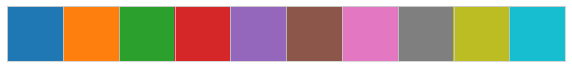

In [166]:
paletteCat = sns.color_palette()
sns.palplot(paletteCat)

In [167]:
familyCancerList = ['RAF', 'RAS', 'RHO', 'RAC', 'FOXA', 'FGFR', 'COL5A1', 'AKT']

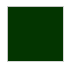

In [168]:
sns.palplot(sns.xkcd_palette(["dark green"]))

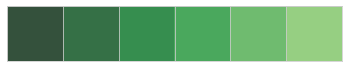

In [169]:
paletteMut = sns.color_palette("YlGn_d")
sns.palplot(paletteMut)

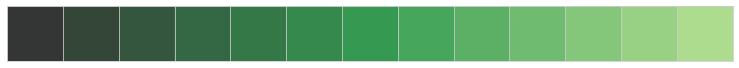

In [170]:
colorMapRGB = sns.color_palette("YlGn_d", 61)
paletteMutCmap = sns.blend_palette(colorMapRGB, as_cmap=True, input='rgb')
sns.palplot([paletteMutCmap(x) for x in np.arange(0, 1, 0.08)])

{'RAF': (1.0, 0.4980392156862745, 0.054901960784313725),
 'RAS': (0.21341022683583236, 0.558723567858516, 0.31175189029860306),
 'RHO': (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 'RAC': (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 'FOXA': (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 'FGFR': (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 'COL5A1': (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
 'AKT': (0.011764705882352941, 0.20784313725490197, 0.0)}

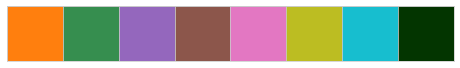

In [171]:
paletteFamily = {familyCancerList[iFamily]:(sns.color_palette() + sns.xkcd_palette(["dark green"]))[iColor]
                 for iFamily, iColor in enumerate([1, 2, 4, 5, 6, 8, 9, 10])}
paletteFamily['RAS'] = paletteMut[2]
sns.palplot(paletteFamily.values())
plt.savefig(outputPath / 'paletteFamily.png')
paletteFamily

In [172]:
[(fam, mcolors.to_hex(c), ) for fam, c in paletteFamily.items()]

[('RAF', '#ff7f0e'),
 ('RAS', '#368e4f'),
 ('RHO', '#9467bd'),
 ('RAC', '#8c564b'),
 ('FOXA', '#e377c2'),
 ('FGFR', '#bcbd22'),
 ('COL5A1', '#17becf'),
 ('AKT', '#033500')]

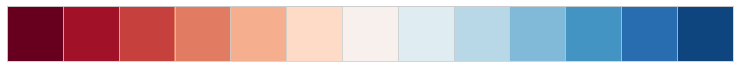

In [173]:
paletteCodon = get_divergent_color_map("RdBu")
paletteCodon = plt.get_cmap("RdBu")
sns.palplot([paletteCodon(x) for x in np.arange(0, 1, 0.08)])
plt.savefig(outputPath / 'paletteCodon.png')

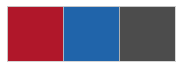

In [174]:
paletteCodonPoles = [paletteCodon(x) for x in [0.1, 0.9]]
paletteCodonProl = paletteCodonPoles[0]
paletteCodonDiff = paletteCodonPoles[1]
paletteCodonNeutral = '0.3'
alphaNeutral = 0.5
alpha = 1.0
sns.palplot(paletteCodonPoles + [paletteCodonNeutral])
plt.savefig(outputPath / 'palettePoles.png')

In [175]:
[('proliferation', mcolors.to_hex(paletteCodonProl)),
 ('differentiation', mcolors.to_hex(paletteCodonDiff)),
 ('neutral', mcolors.to_hex(paletteCodonNeutral)),
]

[('proliferation', '#b1182b'),
 ('differentiation', '#2065ab'),
 ('neutral', '#4c4c4c')]

In [176]:
paletteDict = {
    'random':paletteCodonNeutral,
    'all':paletteCodonNeutral,
    'other':paletteCodonNeutral,
    'high_95%':paletteCat[4],
    'proliferation':paletteCodonProl,
    'differentiation':paletteCodonDiff,
    'positive regulation of mitotic cell cycle':paletteCodonProl,
    'mitotic M phase':paletteCodonProl,
    'pattern specification process':paletteCodonDiff}

alphaDict = {
    'random':alphaNeutral,
    'all':alphaNeutral,
    'other':alphaNeutral,
    'high_95%':alpha,
    'proliferation':alpha,
    'differentiation':alpha,
    'positive regulation of mitotic cell cycle':alpha,
    'mitotic M phase':alpha,
    'pattern specification process':alpha}

## Define pair of gene sets

In [295]:
setPair = ['positive regulation of mitotic cell cycle',
           'pattern specification process']
setPairWithRandom = ['random'] + setPair
setPairWithRandom

['random',
 'positive regulation of mitotic cell cycle',
 'pattern specification process']

In [296]:
cat1, cat2 = setPair

In [297]:
annotateUniprotIdList = ['P49450', 'Q8WVK7', 'P42677', 'Q8NBT2',
                'Q5TAB7', 'P14653', 'P57055']

## Compute CAI for all gene sets

In [ ]:
queryDownSample = 400
queryDownSample = 1e10
querySetDfList = [(geneSetDf[geneSetDf['set'] == label]\
                   .sample(min(queryDownSample, len(geneSetDf[geneSetDf['set'] == label]))), label)
                  for label in querySetList]
refSetDfList = [(geneSetDf[geneSetDf['set'] == label], label) for label in refSetList]

dfList = []
for queryDf, queryLabel in querySetDfList:
    if len(queryDf) > 0:
        df = compute_CAI_df(queryDf, refSetDfList)
        dfList.append(df)
        df.head()

geneCAIDf = pd.concat(dfList)

In [ ]:
(cat1, cat2)

In [ ]:
geneCAIDf['metric_ratio'] = geneCAIDf['metric ' + cat2]/geneCAIDf['metric ' + cat1]
geneCAIDf['CAI_ratio'] = geneCAIDf['CAI ' + cat2]/geneCAIDf['CAI ' + cat1]
geneCAIDf.head(2)

In [48]:
geneCAIDf.to_csv(outputPath / 'geneCAIDf.csv')

In [546]:
geneCAIDf = pd.read_csv(outputPath / 'geneCAIDf.csv', index_col=0)
print(len(geneCAIDf))
geneCAIDf.head()

19101


,CCDS_id,CDS,GO_acc,GO_name,GO_super_acc,GO_super_name,abundance category,gene,set,species_taxid,...,CAI positive regulation of mitotic cell cycle,metric positive regulation of mitotic cell cycle,CAI pattern specification process,metric pattern specification process,CAI mitotic M phase,metric mitotic M phase,CAI all,metric all,metric_ratio,CAI_ratio
10702,CCDS56585.1,ATGGCGGACCAGCAAGGACCTCATCAGAATAGGTTTCCATCGTGTG...,NaN,NaN,NaN,NaN,NaN,ODF2,all,NaN,...,0.844944,0.655336,0.782286,0.590526,0.771237,0.917658,0.815952,0.556214,0.643515,1.014326
18344,CCDS61813.1,ATGCGCACTCACACGGACGAGCGGCCGCACGCCTGCCACCTGTGCG...,NaN,NaN,NaN,NaN,NaN,ZSCAN10,all,NaN,...,0.889961,4.897068,0.900930,4.118563,0.662188,6.567816,0.900747,4.428519,0.627083,1.360535
12033,CCDS33681.1,ATGTTCTGGAAGTTTGACTTGAACACCACGTCCCATGTTGACAAGC...,NaN,NaN,NaN,NaN,NaN,PPP6R2,all,NaN,...,0.876908,0.931679,0.839237,0.593239,0.737263,1.848593,0.861722,0.688317,0.320914,1.138314
3378,CCDS3275.1,ATGTCTAAAACTGGAACCAAGATTACTTTCTATGAAGACAAAAATT...,NaN,NaN,NaN,NaN,NaN,CRYGS,all,NaN,...,0.851521,1.625370,0.776999,1.661597,0.777584,1.897232,0.816863,1.567457,0.875801,0.999248
10919,CCDS31095.1,ATGGACACAGGCAACAAAACTCTGCCCCAGGACTTTCTCTTACTGG...,NaN,NaN,NaN,NaN,NaN,OR6F1,all,NaN,...,0.877154,0.779719,0.811949,0.700065,0.771905,1.333876,0.843628,0.701385,0.524835,1.051877


## Codon usage of all human genes

#### Select GO sets

In [317]:
termDf.set_index('acc')[['min_distance_to_root']]

,min_distance_to_root
acc,
GO:0000001,5.0
GO:0000002,5.0
GO:0000003,1.0
GO:0042254,4.0
GO:0000011,5.0
...,...
GO:2001313,4.0
GO:2001314,5.0
GO:2001315,5.0


In [318]:
# Add minimum distance to root
GOSetDf2 = GOSetDf.set_index('GO_acc').join(termDf.set_index('acc')[['min_distance_to_root']])
GOSetDf2.index.name = 'GO_acc'

In [319]:
# Add nb of sequences
nseq = GOSetDf.groupby('GO_acc').size()
nseq.name = 'n_seq'
GOSetDf2 = GOSetDf2.join(nseq).reset_index()
GOSetDf2.head(3)

,GO_acc,GO_term_id,GO_name,uniprot_id,species_taxid,synonym,CCDS_id,gene,CDS,min_distance_to_root,n_seq
0,GO:0000002,31,mitochondrial genome maintenance,P09874,9606,PARP1_HUMAN|PARP1|ADPRT|PPOL,CCDS1554.1,PARP1,ATGGCGGAGTCTTCGGATAAGCTCTATCGAGTCGAGTACGCCAAGA...,5.0,27
1,GO:0000002,31,mitochondrial genome maintenance,P36776,9606,LONM_HUMAN|LONP1|PRSS15,CCDS12148.1,LONP1,ATGGCGGCGAGCACTGGCTACGTGCGACTGTGGGGAGCGGCGCGGT...,5.0,27
2,GO:0000002,31,mitochondrial genome maintenance,P58004,9606,SESN2_HUMAN|SESN2|Hi95|SEST2,CCDS321.1,SESN2,ATGATCGTGGCGGACTCCGAGTGCCGCGCAGAGCTCAAGGACTACC...,5.0,27


In [320]:
len(GOSetDf2)

1484332

In [321]:
# Reduce to only GO sets, not proteins
GOSetOnlySetDf = GOSetDf2.drop(['uniprot_id', 'species_taxid', 'synonym', 'CCDS_id', 'gene', 'CDS'], axis=1)
GOSetOnlySetDf = GOSetOnlySetDf.drop_duplicates()
print(len(GOSetOnlySetDf))
GOSetOnlySetDf.head(3)

15663


,GO_acc,GO_term_id,GO_name,min_distance_to_root,n_seq
0,GO:0000002,31,mitochondrial genome maintenance,5.0,27
27,GO:0000003,32,reproduction,1.0,1370
1397,GO:0000011,46,vacuole inheritance,5.0,1


In [323]:
print(len(GOSetOnlySetDf))
GOSetPCDf3 = GOSetOnlySetDf
GOSetPCDf3 = GOSetPCDf3[GOSetPCDf3['min_distance_to_root'] <= 3]
GOSetPCDf3 = GOSetPCDf3[GOSetPCDf3['n_seq'] >= 30]
# GOSetPCDf3 = GOSetPCDf3[GOSetPCDf3['n_seq'] <= 400]
print(len(GOSetPCDf3))

15663
708


In [324]:
GOSetPCDf3.head()

,GO_acc,GO_term_id,GO_name,min_distance_to_root,n_seq
27,GO:0000003,32,reproduction,1.0,1370
2029,GO:0000075,108,cell cycle checkpoint,2.0,215
9419,GO:0000422,445,mitophagy,3.0,75
12492,GO:0000910,673,cytokinesis,3.0,143
12993,GO:0001101,857,response to acid chemical,3.0,319


In [325]:
GOSetList = GOSetPCDf3['GO_acc'].values
print(len(GOSetList))

708


In [326]:
GOSetDf1 = GOSetDf.set_index('GO_acc').loc[GOSetList].reset_index()
print(len(GOSetDf1))
GOSetDf1.head()

723861


,GO_acc,GO_term_id,GO_name,uniprot_id,species_taxid,synonym,CCDS_id,gene,CDS
0,GO:0000003,32,reproduction,P05186,9606,PPBT_HUMAN|ALPL,CCDS217.1,ALPL,ATGATTTCACCATTCTTAGTACTGGCCATTGGCACCTGCCTTACTA...
1,GO:0000003,32,reproduction,P09603,9606,CSF1_HUMAN|CSF1,CCDS30797.1,CSF1,ATGACCGCGCCGGGCGCCGCCGGGCGCTGCCCTCCCACGACATGGC...
2,GO:0000003,32,reproduction,P61764,9606,STXB1_HUMAN|STXBP1|UNC18A,CCDS35146.1,STXBP1,ATGGCCCCCATTGGCCTCAAAGCTGTTGTCGGAGAGAAGATTATGC...
3,GO:0000003,32,reproduction,O15240,9606,VGF_HUMAN|VGF,CCDS5712.1,VGF,ATGAAAGCCCTCAGATTGTCGGCTTCCGCCCTCTTCTGCCTTCTGC...
4,GO:0000003,32,reproduction,P09430,9606,STP1_HUMAN|TNP1,CCDS2406.1,TNP1,ATGTCGACCAGCCGCAAATTAAAGAGTCATGGCATGAGGAGGAGCA...


Degree of overlap between gene sets?

In [328]:
GOSetDf1.groupby('uniprot_id').size().describe()

count    16380.000000
mean        44.191758
std         35.582737
min          1.000000
25%         20.000000
50%         33.000000
75%         58.000000
max        337.000000
dtype: float64

Yes, there is a lot of overlap, in average each gene appears in 44 different GO sets. However, if we choose a distance to root even longer, e.g. 4, we get many more sets with even more overlap (each gene in 12 GO sets in this case, with a total of ~1200 sets).

### Select GO terms poles

In [ ]:
subsetListDiff = []
for term in ['cell differentiation', 'multicellular organism development']:
    # get all descendants of GO term
    df = graphPathDf3[graphPathDf3['GO_name1'] == term].dropna(subset=['GO_acc2']).set_index('GO_acc2')
    # Restrict to the reduced set of GO sets
    df = df.loc[df.index.intersection(GOSetList)]
    subsetIndex = df.index.drop_duplicates()
    subsetListDiff.append((term, subsetIndex))

subsetListProl = []
for term in ['cell cycle', 'positive regulation of cell proliferation']:
    # get all descendants of GO term
    df = graphPathDf3[graphPathDf3['GO_name1'] == term].dropna(subset=['GO_acc2']).set_index('GO_acc2')
    # Restrict to the reduced set of GO sets
    df = df.loc[df.index.intersection(GOSetList)]
    subsetIndex = df.index.drop_duplicates()
    subsetListProl.append((term, subsetIndex))

In [330]:
subsetListProl

[('cell cycle',
  Index(['GO:0051321', 'GO:1903046', 'GO:0044786', 'GO:0051304', 'GO:0098813',
         'GO:0007062', 'GO:0008608', 'GO:0007051', 'GO:0007099', 'GO:0007098',
         'GO:0051298', 'GO:0007093', 'GO:0031570', 'GO:0031577', 'GO:1901976',
         'GO:0000075', 'GO:1903047', 'GO:0000910', 'GO:0010564', 'GO:0010948',
         'GO:0090068', 'GO:0007050', 'GO:0022402', 'GO:0044770', 'GO:0045023',
         'GO:0051653', 'GO:0007049'],
        dtype='object', name='GO_acc2')),
 ('positive regulation of cell proliferation',
  Index(['GO:0008284'], dtype='object'))]

In [331]:
subsetListDiff

[('cell differentiation',
  Index(['GO:0007281', 'GO:0009994', 'GO:0048515', 'GO:0048588', 'GO:0002292',
         'GO:0002293', 'GO:0002294', 'GO:0045058', 'GO:0043368', 'GO:0014009',
         'GO:0031424', 'GO:0016358', 'GO:0060996', 'GO:0048468'],
        dtype='object', name='GO_acc2')),
 ('multicellular organism development',
  Index(['GO:0001892', 'GO:0045137', 'GO:0048608', 'GO:0060674', 'GO:0007566',
         'GO:0060348', 'GO:0001525', 'GO:0045190', 'GO:0002562', 'GO:0048514',
         'GO:0001568', 'GO:0002088', 'GO:0060041', 'GO:0060042', 'GO:0003407',
         'GO:0001822', 'GO:0072006', 'GO:0072028', 'GO:0032835', 'GO:0001824',
         'GO:0001704', 'GO:0001756', 'GO:0002292', 'GO:0002293', 'GO:0002294',
         'GO:0045058', 'GO:0043368', 'GO:0001942', 'GO:0016445', 'GO:0002200',
         'GO:0002520', 'GO:0048534', 'GO:0003151', 'GO:0003206', 'GO:0060411',
         'GO:0003179', 'GO:0003170', 'GO:0003279', 'GO:0003205', 'GO:0055017',
         'GO:0007272', 'GO:0007389',

Check that at least there is no GO term overlap between the two subsets of GO sets.

Obvisouly we may have overlap in genes, but we hope there is no GO term that descend both from cell cycle and from cell differentiation.

In [332]:
subsetUnionDiff = set.union(*[set(l) for name, l in subsetListDiff])
subsetUnionProl = set.union(*[set(l) for name, l in subsetListProl])

subsetUnionDiff & subsetUnionProl

set()

In [333]:
subsetListDiff

[('cell differentiation',
  Index(['GO:0007281', 'GO:0009994', 'GO:0048515', 'GO:0048588', 'GO:0002292',
         'GO:0002293', 'GO:0002294', 'GO:0045058', 'GO:0043368', 'GO:0014009',
         'GO:0031424', 'GO:0016358', 'GO:0060996', 'GO:0048468'],
        dtype='object', name='GO_acc2')),
 ('multicellular organism development',
  Index(['GO:0001892', 'GO:0045137', 'GO:0048608', 'GO:0060674', 'GO:0007566',
         'GO:0060348', 'GO:0001525', 'GO:0045190', 'GO:0002562', 'GO:0048514',
         'GO:0001568', 'GO:0002088', 'GO:0060041', 'GO:0060042', 'GO:0003407',
         'GO:0001822', 'GO:0072006', 'GO:0072028', 'GO:0032835', 'GO:0001824',
         'GO:0001704', 'GO:0001756', 'GO:0002292', 'GO:0002293', 'GO:0002294',
         'GO:0045058', 'GO:0043368', 'GO:0001942', 'GO:0016445', 'GO:0002200',
         'GO:0002520', 'GO:0048534', 'GO:0003151', 'GO:0003206', 'GO:0060411',
         'GO:0003179', 'GO:0003170', 'GO:0003279', 'GO:0003205', 'GO:0055017',
         'GO:0007272', 'GO:0007389',

In [334]:
GOSetPoleDf = []

for parent_term, subsetList in subsetListDiff:
    for acc in subsetList:
        GOSetPoleDf.append({'GO_acc':acc, 'parent_term':parent_term, 'pole':'differentiation'})

for parent_term, subsetList in subsetListProl:
    for acc in subsetList:
        GOSetPoleDf.append({'GO_acc':acc, 'parent_term':parent_term, 'pole':'proliferation'})
    
GOSetPoleDf = pd.DataFrame(GOSetPoleDf)
GOSetPoleDf.head()

,GO_acc,parent_term,pole
0,GO:0007281,cell differentiation,differentiation
1,GO:0009994,cell differentiation,differentiation
2,GO:0048515,cell differentiation,differentiation
3,GO:0048588,cell differentiation,differentiation
4,GO:0002292,cell differentiation,differentiation


In [335]:
GOSetPoleDf.tail()

,GO_acc,parent_term,pole
127,GO:0044770,cell cycle,proliferation
128,GO:0045023,cell cycle,proliferation
129,GO:0051653,cell cycle,proliferation
130,GO:0007049,cell cycle,proliferation
131,GO:0008284,positive regulation of cell proliferation,proliferation


### PCA codon usage gene-based

#### Fit PCA transform for all human genes

In [336]:
geneAllDf = geneAllDf.set_index('CCDS_id')
geneAllDf.head(3)

,GO_term_id,GO_name,GO_acc,uniprot_id,species_taxid,synonym,gene,CDS,set,abundance category
CCDS_id,,,,,,,,,,
CCDS34394.1,NaN,NaN,NaN,P01889,NaN,NaN,HLA-B,ATGCTGGTCATGGCGCCCCGAACCGTCCTCCTGCTGCTCTCGGCGG...,all,NaN
CCDS34373.1,NaN,NaN,NaN,P04439,NaN,NaN,HLA-A,ATGGCCGTCATGGCGCCCCGAACCCTCCTCCTGCTACTCTCGGGGG...,all,NaN
CCDS34393.1,NaN,NaN,NaN,P10321,NaN,NaN,HLA-C,ATGCGGGTCATGGCGCCCCGAGCCCTCCTCCTGCTGCTCTCGGGAG...,all,NaN


In [337]:
queryDf = geneSetDf[geneSetDf['set'] == 'all']
queryDf = queryDf.set_index('CCDS_id')
print(len(queryDf))
queryDf.head()

18386


,GO_term_id,GO_name,GO_acc,uniprot_id,species_taxid,synonym,gene,CDS,set,abundance category
CCDS_id,,,,,,,,,,
CCDS34394.1,NaN,NaN,NaN,P01889,NaN,NaN,HLA-B,ATGCTGGTCATGGCGCCCCGAACCGTCCTCCTGCTGCTCTCGGCGG...,all,NaN
CCDS34373.1,NaN,NaN,NaN,P04439,NaN,NaN,HLA-A,ATGGCCGTCATGGCGCCCCGAACCCTCCTCCTGCTACTCTCGGGGG...,all,NaN
CCDS34393.1,NaN,NaN,NaN,P10321,NaN,NaN,HLA-C,ATGCGGGTCATGGCGCCCCGAGCCCTCCTCCTGCTGCTCTCGGGAG...,all,NaN
CCDS1666.1,NaN,NaN,NaN,P27348,NaN,NaN,YWHAQ,ATGGAGAAGACTGAGCTGATCCAGAAGGCCAAGCTGGCCGAGCAGG...,all,NaN
CCDS13339.1,NaN,NaN,NaN,P31946,NaN,NaN,YWHAB,ATGACAATGGATAAAAGTGAGCTGGTACAGAAAGCCAAACTCGCTG...,all,NaN


In [338]:
codonFreqDf = compute_codon_usage_series(queryDf['CDS'], aaCodonDict, checkLengthMultipleOf3=True, verbose=2)
codonFreqDf.head()

ERROR: seq length is not multiple of 3.


*                   A                                       C  \
             TAA  TAG  TGA       GCA       GCC       GCG       GCT       TGC   
CCDS_id                                                                        
CCDS34394.1  0.0  0.0  1.0  0.105263  0.368421  0.263158  0.263158  0.833333   
CCDS34373.1  0.0  0.0  1.0  0.055556  0.416667  0.305556  0.222222  0.800000   
CCDS34393.1  0.0  0.0  1.0  0.108108  0.378378  0.270270  0.243243  0.777778   
CCDS1666.1   1.0  0.0  0.0  0.208333  0.416667  0.083333  0.291667  0.600000   
CCDS13339.1  1.0  0.0  0.0  0.428571  0.238095  0.000000  0.333333  0.500000   

                              D  ...         T                             V  \
                  TGT       GAC  ...       ACC       ACG       ACT       GTA   
CCDS_id                          ...                                           
CCDS34394.1  0.166667  0.818182  ...  0.625000  0.041667  0.125000  0.040000   
CCDS34373.1  0.200000  0.750000  ...  0.551724  0.172414  0.103448  0.000000   
CCDS34393.1  0.222222  0.809524  ...  0.680000  0.160000  0.040000  0.000000   
CCDS1666.1   0.400000  0.500000  ...  0.375000  0.250000  0.125000  0.100000   
CCDS13339.1  0.500000  0.500000  ...  0.083333  0.166667  0.250000  0.181818   

                                             W         Y            
                  GTC       GTG       GTT  TGG       TAC       TAT  
CCDS_id                                                             
CCDS34394.1  0.240000  0.640000  0.080000  1.0  0.875000  0.125000  
CCDS34373.1  0.090909  0.863636  0.045455  1.0  0.785714  0.214286  
CCDS34393.1  0.250000  0.650000  0.100000  1.0  0.769231  0.230769  
CCDS1666.1   0.300000  0.500000  0.100000  1.0  0.636364  0.363636  
CCDS13339.1  0.272727  0.363636  0.181818  1.0  0.454545  0.545455  

[5 rows x 64 columns]

In [339]:
codonFreqAllGenesDf = codonFreqDf.copy()

In [340]:
codonFreqDf = codonFreqAllGenesDf.copy()

In [341]:
avgCodonFreq = codonFreqDf.mean(axis=0).drop(['M', 'W', '*'])
avgCodonFreq.head(10)

/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


A  GCA    0.232148
   GCC    0.395523
   GCG    0.107973
   GCT    0.264356
C  TGC    0.553410
   TGT    0.446590
D  GAC    0.560345
   GAT    0.439655
E  GAA    0.405386
   GAG    0.594614
dtype: float64

We drop the stop codons, which could bias the analysis.

In [342]:
codonFreqDf2 = codonFreqDf.drop('*', axis=1)

In [343]:
codonFreqDf2.apply(lambda x: x.isnull().sum(), axis=0).sort_values(ascending=False)

W  TGG    1201
C  TGC     499
   TGT     499
H  CAC     338
   CAT     338
          ... 
S  TCA       8
   TCC       8
   TCG       8
   TCT       8
M  ATG       3
Length: 61, dtype: int64

We also drop single codon families.

In [344]:
codonFreqDf2 = codonFreqDf2.drop(['M', 'W'], axis=1)

In [345]:
len(codonFreqDf2)

18386

In [346]:
(len(codonFreqDf2) - len(codonFreqDf2.dropna())) / len(codonFreqDf2)

0.06733384096595235

There are many sequences that miss a few codon families, about 10% when including single codon families, and 6.7% when excluding single codon families (M and W). We drop these sequences, because otherwise we can only apply PCA to data points that have all valid coordinates.

In the case of sequences that have 0 counts in a codon family (often, cysteine), we cannot replace the frequencies by zero, because then we would classify sequences based on their amino acid content, not codon usage. We can either:

1. remove cys codons frequencies features for all sequences
2. remove sequences that have no cysteine counts.

The more unbiased approach would be 1.

In Ginglod they did not have this problem because they considered gene sets.

We will use approach 2 and keep the Cys codon usage feature.

If a sequence is missing some codon count (0 count), we replace them by the average codon usage.

In [347]:
pcaGeneBasedavgCodonFreq = avgCodonFreq.copy()

In [349]:
avgCodonFreq.head(10)

A  GCA    0.232148
   GCC    0.395523
   GCG    0.107973
   GCT    0.264356
C  TGC    0.553410
   TGT    0.446590
D  GAC    0.560345
   GAT    0.439655
E  GAA    0.405386
   GAG    0.594614
dtype: float64

In [351]:
emptyCysIndex = codonFreqDf2[codonFreqDf2[('C', 'TGC')].isnull()].index
codonFreqDf2.loc[emptyCysIndex].head()

A                                 C             D  \
                  GCA       GCC       GCG       GCT TGC TGT       GAC   
CCDS_id                                                                 
CCDS2126.1   0.200000  0.500000  0.000000  0.300000 NaN NaN  0.500000   
CCDS9838.1   0.666667  0.000000  0.000000  0.333333 NaN NaN  0.600000   
CCDS7381.1   0.142857  0.500000  0.214286  0.142857 NaN NaN  1.000000   
CCDS982.1    0.500000  0.333333  0.000000  0.166667 NaN NaN  0.571429   
CCDS34398.1  0.000000  0.500000  0.250000  0.250000 NaN NaN  0.500000   

                              E            ...         T                      \
                  GAT       GAA       GAG  ...       ACA       ACC       ACG   
CCDS_id                                    ...                                 
CCDS2126.1   0.500000  0.250000  0.750000  ...  0.285714  0.142857  0.142857   
CCDS9838.1   0.400000  0.833333  0.166667  ...  0.400000  0.200000  0.000000   
CCDS7381.1   0.000000  0.500000  0.500000  ...  0.142857  0.714286  0.000000   
CCDS982.1    0.428571  0.571429  0.428571  ...  0.250000  0.500000  0.000000   
CCDS34398.1  0.500000  0.300000  0.700000  ...  0.333333  0.000000  0.333333   

                              V                                   Y        
                  ACT       GTA       GTC       GTG       GTT   TAC   TAT  
CCDS_id                                                                    
CCDS2126.1   0.428571  0.333333  0.000000  0.333333  0.333333  0.75  0.25  
CCDS9838.1   0.400000  0.222222  0.222222  0.555556  0.000000  0.50  0.50  
CCDS7381.1   0.142857  0.000000  0.000000  1.000000  0.000000   NaN   NaN  
CCDS982.1    0.250000  0.000000  0.333333  0.333333  0.333333  1.00  0.00  
CCDS34398.1  0.333333  0.000000  0.500000  0.500000  0.000000  0.50  0.50  

[5 rows x 59 columns]

In [352]:
codonFreqDf3 = codonFreqDf2.apply(lambda row: row.fillna(avgCodonFreq), axis=1)

In [353]:
codonFreqDf3.loc[emptyCysIndex].head()

A                                      C           \
                  GCA       GCC       GCG       GCT      TGC      TGT   
CCDS_id                                                                 
CCDS2126.1   0.200000  0.500000  0.000000  0.300000  0.55341  0.44659   
CCDS9838.1   0.666667  0.000000  0.000000  0.333333  0.55341  0.44659   
CCDS7381.1   0.142857  0.500000  0.214286  0.142857  0.55341  0.44659   
CCDS982.1    0.500000  0.333333  0.000000  0.166667  0.55341  0.44659   
CCDS34398.1  0.000000  0.500000  0.250000  0.250000  0.55341  0.44659   

                    D                   E            ...         T            \
                  GAC       GAT       GAA       GAG  ...       ACA       ACC   
CCDS_id                                              ...                       
CCDS2126.1   0.500000  0.500000  0.250000  0.750000  ...  0.285714  0.142857   
CCDS9838.1   0.600000  0.400000  0.833333  0.166667  ...  0.400000  0.200000   
CCDS7381.1   1.000000  0.000000  0.500000  0.500000  ...  0.142857  0.714286   
CCDS982.1    0.571429  0.428571  0.571429  0.428571  ...  0.250000  0.500000   
CCDS34398.1  0.500000  0.500000  0.300000  0.700000  ...  0.333333  0.000000   

                                        V                                \
                  ACG       ACT       GTA       GTC       GTG       GTT   
CCDS_id                                                                   
CCDS2126.1   0.142857  0.428571  0.333333  0.000000  0.333333  0.333333   
CCDS9838.1   0.000000  0.400000  0.222222  0.222222  0.555556  0.000000   
CCDS7381.1   0.000000  0.142857  0.000000  0.000000  1.000000  0.000000   
CCDS982.1    0.000000  0.250000  0.000000  0.333333  0.333333  0.333333   
CCDS34398.1  0.333333  0.333333  0.000000  0.500000  0.500000  0.000000   

                   Y           
                 TAC      TAT  
CCDS_id                        
CCDS2126.1   0.75000  0.25000  
CCDS9838.1   0.50000  0.50000  
CCDS7381.1   0.57246  0.42754  
CCDS982.1    1.00000  0.00000  
CCDS34398.1  0.50000  0.50000  

[5 rows x 59 columns]

This gets down to about 6.7% of sequences. We have to drop them out now.

In [354]:
print(len(codonFreqDf2))
print(len(codonFreqDf2.dropna()))

18386
17148


In [355]:
print(len(codonFreqDf3))
print(len(codonFreqDf3.dropna()))

18386
18386


In [356]:
pcaGeneBasedcodonFreqDf3 = codonFreqDf3.copy()
codonFreqDf3 = pcaGeneBasedcodonFreqDf3.copy()

aaList = list(set([aa for aa, codon in codonFreqDf3.columns]))
lastSynCodon = [(aa, codonFreqDf3[aa].columns[-1]) for aa in aaList]

In [357]:
codonFreqDf4 = codonFreqDf3#.drop(lastSynCodon, axis=1)
codonFreqDf4.head()

A                                       C            \
                  GCA       GCC       GCG       GCT       TGC       TGT   
CCDS_id                                                                   
CCDS34394.1  0.105263  0.368421  0.263158  0.263158  0.833333  0.166667   
CCDS34373.1  0.055556  0.416667  0.305556  0.222222  0.800000  0.200000   
CCDS34393.1  0.108108  0.378378  0.270270  0.243243  0.777778  0.222222   
CCDS1666.1   0.208333  0.416667  0.083333  0.291667  0.600000  0.400000   
CCDS13339.1  0.428571  0.238095  0.000000  0.333333  0.500000  0.500000   

                    D                   E            ...         T            \
                  GAC       GAT       GAA       GAG  ...       ACA       ACC   
CCDS_id                                              ...                       
CCDS34394.1  0.818182  0.181818  0.037037  0.962963  ...  0.208333  0.625000   
CCDS34373.1  0.750000  0.250000  0.000000  1.000000  ...  0.172414  0.551724   
CCDS34393.1  0.809524  0.190476  0.038462  0.961538  ...  0.120000  0.680000   
CCDS1666.1   0.500000  0.500000  0.307692  0.692308  ...  0.250000  0.375000   
CCDS13339.1  0.500000  0.500000  0.500000  0.500000  ...  0.500000  0.083333   

                                        V                                \
                  ACG       ACT       GTA       GTC       GTG       GTT   
CCDS_id                                                                   
CCDS34394.1  0.041667  0.125000  0.040000  0.240000  0.640000  0.080000   
CCDS34373.1  0.172414  0.103448  0.000000  0.090909  0.863636  0.045455   
CCDS34393.1  0.160000  0.040000  0.000000  0.250000  0.650000  0.100000   
CCDS1666.1   0.250000  0.125000  0.100000  0.300000  0.500000  0.100000   
CCDS13339.1  0.166667  0.250000  0.181818  0.272727  0.363636  0.181818   

                    Y            
                  TAC       TAT  
CCDS_id                          
CCDS34394.1  0.875000  0.125000  
CCDS34373.1  0.785714  0.214286  
CCDS34393.1  0.769231  0.230769  
CCDS1666.1   0.636364  0.363636  
CCDS13339.1  0.454545  0.545455  

[5 rows x 59 columns]

In [358]:
x = codonFreqDf4.values
x

array([[0.10526316, 0.36842105, 0.26315789, ..., 0.08      , 0.875     ,
        0.125     ],
       [0.05555556, 0.41666667, 0.30555556, ..., 0.04545455, 0.78571429,
        0.21428571],
       [0.10810811, 0.37837838, 0.27027027, ..., 0.1       , 0.76923077,
        0.23076923],
       ...,
       [0.30769231, 0.23076923, 0.38461538, ..., 0.41666667, 0.8       ,
        0.2       ],
       [0.25      , 0.35714286, 0.        , ..., 0.41176471, 0.2       ,
        0.8       ],
       [0.35294118, 0.15686275, 0.01960784, ..., 0.09302326, 0.14285714,
        0.85714286]])

Scaling the data to standard distribution.

In [359]:
nComponents = 4
pcaPipe = Pipeline([('scale', StandardScaler()), ('PCA', PCA(n_components=nComponents))])
principalComponents = pcaPipe.fit_transform(x)
pcLabelList = ['PC{:d}'.format(i + 1) for i in range(nComponents)]
pcLabelList

['PC1', 'PC2', 'PC3', 'PC4']

In [360]:
pcaPipe.steps[1][1].explained_variance_ratio_

array([0.42514162, 0.03368587, 0.02573109, 0.02213309])

In [361]:
valuesIndex = [(aa, codon) for aa, codon in codonFreqDf4.columns]
print(len(valuesIndex))
valuesIndex;

59


In [362]:
component1 = pcaPipe.steps[1][1].components_[0]
print(len(component1))
component1 = pd.Series(component1, index=pd.MultiIndex.from_tuples(valuesIndex))
component1.head()

59


A  GCA   -0.134830
   GCC    0.142634
   GCG    0.099947
   GCT   -0.124270
C  TGC    0.124015
dtype: float64

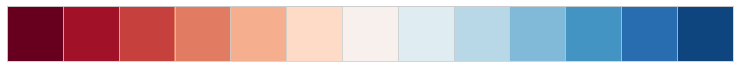

In [363]:
sns.palplot([paletteCodon(x) for x in np.arange(0, 1, 0.08)])

In [364]:
from pandas import IndexSlice as idx

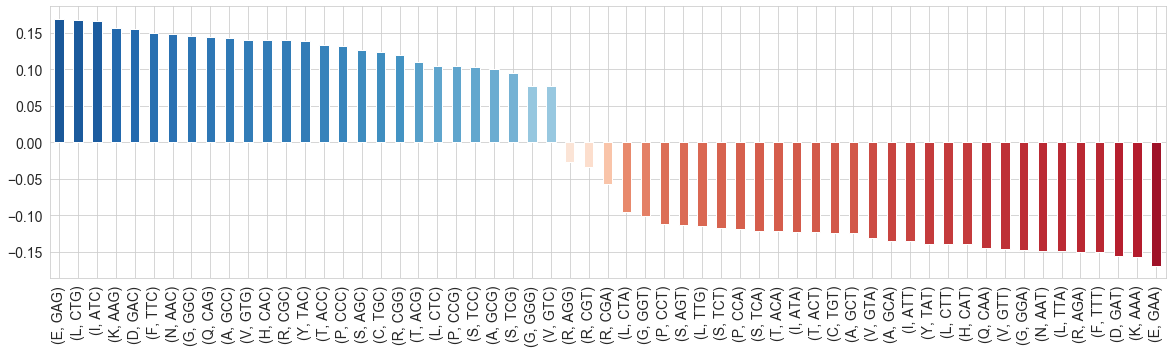

In [365]:
matplotlib.rcParams['font.size'] = 14

plotDf = component1.sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(20,5))
norm = mcolors.Normalize(vmin=-0.2, vmax=0.2)
colorList = plotDf.map(lambda x: paletteCodon(norm(x)))
plotDf.plot.bar(ax=ax, color=colorList)

In [ ]:
df2 = plotDf.reset_index()
df2.columns = ['aa', 'codon', 'component1']
filename = str(outputPath / 'PCA_projection_gene-based_component1.xlsx')
df2.to_excel(filename)
df2.head()

In [368]:
pcaPipe.get_params()

{'memory': None,
 'steps': [('scale', StandardScaler(copy=True, with_mean=True, with_std=True)),
  ('PCA',
   PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
       svd_solver='auto', tol=0.0, whiten=False))],
 'verbose': False,
 'scale': StandardScaler(copy=True, with_mean=True, with_std=True),
 'PCA': PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
     svd_solver='auto', tol=0.0, whiten=False),
 'scale__copy': True,
 'scale__with_mean': True,
 'scale__with_std': True,
 'PCA__copy': True,
 'PCA__iterated_power': 'auto',
 'PCA__n_components': 4,
 'PCA__random_state': None,
 'PCA__svd_solver': 'auto',
 'PCA__tol': 0.0,
 'PCA__whiten': False}

In [369]:
pcaGeneBasedPipe = pcaPipe

In [370]:
geneCDSSeries = queryDf.iloc[4:8]['CDS']
codonFreqAllGenesDf.loc[geneCDSSeries.index]

*                   A                                      C  \
             TAA  TAG  TGA       GCA       GCC      GCG       GCT       TGC   
CCDS_id                                                                       
CCDS13339.1  1.0  0.0  0.0  0.428571  0.238095  0.00000  0.333333  0.500000   
CCDS288.1    0.0  0.0  1.0  0.076923  0.807692  0.00000  0.115385  1.000000   
CCDS5584.1   1.0  0.0  0.0  0.086957  0.521739  0.26087  0.130435  1.000000   
CCDS11001.1  0.0  0.0  1.0  0.360000  0.160000  0.12000  0.360000  0.333333   

                              D  ...         T                         V  \
                  TGT       GAC  ...       ACC       ACG   ACT       GTA   
CCDS_id                          ...                                       
CCDS13339.1  0.500000  0.500000  ...  0.083333  0.166667  0.25  0.181818   
CCDS288.1    0.000000  0.933333  ...  0.600000  0.100000  0.20  0.083333   
CCDS5584.1   0.000000  0.823529  ...  0.454545  0.363636  0.00  0.000000   
CCDS11001.1  0.666667  0.545455  ...  0.000000  0.200000  0.30  0.230769   

                                             W         Y            
                  GTC       GTG       GTT  TGG       TAC       TAT  
CCDS_id                                                             
CCDS13339.1  0.272727  0.363636  0.181818  1.0  0.454545  0.545455  
CCDS288.1    0.166667  0.750000  0.000000  1.0  0.800000  0.200000  
CCDS5584.1   0.200000  0.733333  0.066667  1.0  0.928571  0.071429  
CCDS11001.1  0.000000  0.461538  0.307692  1.0  0.416667  0.583333  

[4 rows x 64 columns]

In [371]:
def compute_PC_geneBased(geneCDSSeries, computeSet=False, codonFreqAllGenesDf=codonFreqAllGenesDf,
                         fillMissingCodonWithAvgCodonFreq=True,
                         avgCodonFreq=pcaGeneBasedavgCodonFreq):
    
    if not computeSet:
        codonUsage = compute_codon_usage_series(geneCDSSeries, aaCodonDict, checkLengthMultipleOf3=True)
    else:
        # Computing the codon frequency by concatenating the protein sequences
#         codonUsage = compute_codon_usage_dict(geneCDSSeries, aaCodonDict, checkLengthMultipleOf3=True, verbose=0)
#         codonUsage = codonUsage.to_frame().T
        
        # Computing the mean of codon frequency of each protein
#         codonUsage = compute_codon_usage_series(geneCDSSeries, aaCodonDict, checkLengthMultipleOf3=True)
        # Using pre-computed codon usage of all genes
        codonUsage = codonFreqAllGenesDf.loc[geneCDSSeries.index]        
        codonUsage = codonUsage.mean().to_frame().T
            
    codonUsage = codonUsage.drop(['M', 'W', '*'], axis=1, errors='ignore')
#     codonUsage = codonUsage.drop(lastSynCodon, axis=1)
    # If codon have zero counts (NaN codon freq), we replace it by the *average* codon frequency over all human genes
    if fillMissingCodonWithAvgCodonFreq:
        codonUsage2 = codonUsage.fillna(avgCodonFreq)
    else:
        codonUsage2 = codonUsage.dropna()
    codonUsageArr = codonUsage2.values
    
    pc = pcaGeneBasedPipe.transform(codonUsageArr)
    pcLabelList = ['PC{:d}'.format(i + 1) for i in range(nComponents)]
    principalDf = pd.DataFrame(data=pc, columns=pcLabelList, index=codonUsage2.index)
    return principalDf, codonUsage

principalDf, codonUsage = compute_PC_geneBased(queryDf.iloc[4:8]['CDS'])
principalDf

,PC1,PC2,PC3,PC4
CCDS_id,,,,
CCDS13339.1,-1.314161,4.559298,1.136495,1.256014
CCDS288.1,-3.140546,-0.619938,-3.331614,0.916685
CCDS5584.1,-3.306160,0.791348,-1.839442,1.439690
CCDS11001.1,-3.082873,6.905251,-0.177932,0.725967


In [372]:
geneSetPCAMethod = 'geneSetPCAFreqMeanMethod'

In [373]:
pcaGeneBasedGeneDf = geneAllDf.join(compute_PC_geneBased(geneAllDf['CDS'])[0])
print(len(pcaGeneBasedGeneDf))
pcaGeneBasedGeneDf.head()

18388


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


,GO_term_id,GO_name,GO_acc,uniprot_id,species_taxid,synonym,gene,CDS,set,abundance category,PC1,PC2,PC3,PC4
CCDS_id,,,,,,,,,,,,,,
CCDS10.1,NaN,NaN,NaN,Q9Y5U5,NaN,NaN,TNFRSF18,ATGGCACAGCACGGGGCGATGGGCGCGTTTCGGGCCCTGTGCGGCC...,all,NaN,7.299647,2.571495,1.278043,0.587341
CCDS100.2,NaN,NaN,NaN,Q5UAW9,NaN,NaN,GPR157,ATGCAGCCGTCCCCGCCGCCCACCGAGCTGGTGCCGTCGGAGCGCG...,all,NaN,7.739260,2.053917,0.140419,-0.826161
CCDS1000.1,NaN,NaN,NaN,Q9NNX1,NaN,NaN,TUFT1,ATGAACGGGACGCGGAACTGGTGTACCCTGGTGGACGTGCACCCAG...,all,NaN,0.945298,0.050649,0.332022,2.489062
CCDS10000.1,NaN,NaN,NaN,O95848,NaN,NaN,NUDT14,ATGGAGCGCATCGAGGGGGCGTCCGTGGGCCGCTGCGCCGCCTCAC...,all,NaN,4.696337,-0.021666,-2.190346,0.619664
CCDS10001.1,NaN,NaN,NaN,Q92994,NaN,NaN,BRF1,ATGACGGGCCGCGTGTGCCGCGGTTGCGGCGGCACGGACATCGAGC...,all,NaN,5.350035,0.788759,1.148910,0.596510


In [374]:
pcaGeneBasedGeneDf = pcaGeneBasedGeneDf[['gene', 'uniprot_id'] + pcLabelList].dropna(subset=['PC1'])
print(len(pcaGeneBasedGeneDf))
pcaGeneBasedGeneDf.head()

18388


,gene,uniprot_id,PC1,PC2,PC3,PC4
CCDS_id,,,,,,
CCDS10.1,TNFRSF18,Q9Y5U5,7.299647,2.571495,1.278043,0.587341
CCDS100.2,GPR157,Q5UAW9,7.739260,2.053917,0.140419,-0.826161
CCDS1000.1,TUFT1,Q9NNX1,0.945298,0.050649,0.332022,2.489062
CCDS10000.1,NUDT14,O95848,4.696337,-0.021666,-2.190346,0.619664
CCDS10001.1,BRF1,Q92994,5.350035,0.788759,1.148910,0.596510


In [429]:
pcaGeneBasedGeneDf.to_csv(outputPath / 'pcaGeneBasedGeneDf.csv')

In [375]:
pcaGeneBasedGeneDf = pd.read_csv(outputPath / 'pcaGeneBasedGeneDf.csv', index_col=0)
pcaGeneBasedGeneDf.head()

,gene,uniprot_id,PC1,PC2,PC3,PC4
CCDS_id,,,,,,
CCDS10.1,TNFRSF18,Q9Y5U5,7.299647,2.574849,1.284763,0.762616
CCDS100.2,GPR157,Q5UAW9,7.739260,2.054957,0.144181,-0.739597
CCDS1000.1,TUFT1,Q9NNX1,0.945298,0.052726,0.301444,2.414820
CCDS10000.1,NUDT14,O95848,4.696337,-0.022438,-2.203740,0.598976
CCDS10001.1,BRF1,Q92994,5.350035,0.787794,1.152289,0.560182


#### Select GO terms poles and associated genes

We use the definition of the GO set poles as defined in the PCA based on GO sets. However, we will only use the list of GO sets. **The PCa projection is different thus we have to delete the PC1 and PC2 values**.

In [376]:
GOSetDf5 = pd.merge(GOSetDf1, GOSetPoleDf, on='GO_acc', how='left')
GOSetDf5.head()

,GO_acc,GO_term_id,GO_name,uniprot_id,species_taxid,synonym,CCDS_id,gene,CDS,parent_term,pole
0,GO:0000003,32,reproduction,P05186,9606,PPBT_HUMAN|ALPL,CCDS217.1,ALPL,ATGATTTCACCATTCTTAGTACTGGCCATTGGCACCTGCCTTACTA...,NaN,NaN
1,GO:0000003,32,reproduction,P09603,9606,CSF1_HUMAN|CSF1,CCDS30797.1,CSF1,ATGACCGCGCCGGGCGCCGCCGGGCGCTGCCCTCCCACGACATGGC...,NaN,NaN
2,GO:0000003,32,reproduction,P61764,9606,STXB1_HUMAN|STXBP1|UNC18A,CCDS35146.1,STXBP1,ATGGCCCCCATTGGCCTCAAAGCTGTTGTCGGAGAGAAGATTATGC...,NaN,NaN
3,GO:0000003,32,reproduction,O15240,9606,VGF_HUMAN|VGF,CCDS5712.1,VGF,ATGAAAGCCCTCAGATTGTCGGCTTCCGCCCTCTTCTGCCTTCTGC...,NaN,NaN
4,GO:0000003,32,reproduction,P09430,9606,STP1_HUMAN|TNP1,CCDS2406.1,TNP1,ATGTCGACCAGCCGCAAATTAAAGAGTCATGGCATGAGGAGGAGCA...,NaN,NaN


In [377]:
GOSetDf5[~GOSetDf5['pole'].isnull()].tail(2)

,GO_acc,GO_term_id,GO_name,uniprot_id,species_taxid,synonym,CCDS_id,gene,CDS,parent_term,pole
722480,GO:1903047,41076,mitotic cell cycle process,Q9Y5B0,9606,CTDP1_HUMAN|CTDP1|FCP1,CCDS12017.1,CTDP1,ATGGAGGTGCCGGCCGCGGGTCGCGTTCCTGCCGAGGGCGCCCCGA...,cell cycle,proliferation
722481,GO:1903047,41076,mitotic cell cycle process,Q9NRC8,9606,SIR7_HUMAN|SIRT7|SIR2L7,CCDS11792.1,SIRT7,ATGGCAGCCGGGGGTCTGAGCCGCTCCGAGCGCAAAGCGGCGGAGC...,cell cycle,proliferation


In [378]:
len(GOSetDf5['GO_acc'].unique())

708

#### Compute PCA gene-based of GO gene sets

In [ ]:
pcaGeneBasedGOSetGenesDf = GOSetDf5.copy()
pcaGeneBasedGOSetGenesDf.head()

In [380]:
print(len(pcaGeneBasedGOSetGenesDf))

724646


In [381]:
geneCDSSeries = pcaGeneBasedGOSetGenesDf[pcaGeneBasedGOSetGenesDf['pole'] == 'differentiation'].set_index('CCDS_id')['CDS']
principalDf, codonUsage = compute_PC_geneBased(geneCDSSeries, computeSet=True)
principalDf

/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


,PC1,PC2,PC3,PC4
0,1.221333,0.217382,-0.049825,-0.061664


In [382]:
geneCDSSeries = pcaGeneBasedGOSetGenesDf[pcaGeneBasedGOSetGenesDf['pole'] == 'proliferation'].set_index('CCDS_id')['CDS']
principalDf, codonUsage = compute_PC_geneBased(geneCDSSeries, computeSet=True)
principalDf

/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


,PC1,PC2,PC3,PC4
0,-1.183508,0.213598,-0.274958,0.093172


In [383]:
dfList = []
codonUsageList = []
for i, (goAcc, df) in enumerate(pcaGeneBasedGOSetGenesDf.groupby('GO_acc')):
    print(i, goAcc)
    df1, codonUsage = compute_PC_geneBased(df.set_index('CCDS_id')['CDS'], computeSet=True)
    df1['GO_acc'] = goAcc
    df1 = df1.set_index('GO_acc')
    codonUsage['GO_acc'] = goAcc
    codonUsage = codonUsage.set_index('GO_acc')
    dfList.append(df1)
    codonUsageList.append(codonUsage)
#     if i>3: break
    
pcaGeneBasedGOSetDf = pd.concat(dfList)
pcaGeneBasedGOSetDf.head()

0 GO:0000003
1 GO:0000075
2 GO:0000422
3 GO:0000910
4 GO:0001101


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

5 GO:0001503
6 GO:0001505
7 GO:0001525
8 GO:0001558
9 GO:0001568
10 GO:0001662


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

11 GO:0001666
12 GO:0001704
13 GO:0001756
14 GO:0001763
15 GO:0001775
16 GO:0001776


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

17 GO:0001816
18 GO:0001822
19 GO:0001824
20 GO:0001892
21 GO:0001906
22 GO:0001909


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

23 GO:0001910
24 GO:0001912
25 GO:0001942
26 GO:0002027
27 GO:0002088
28 GO:0002200


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

29 GO:0002209
30 GO:0002218
31 GO:0002250
32 GO:0002252
33 GO:0002253
34 GO:0002260


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

35 GO:0002262
36 GO:0002263
37 GO:0002274
38 GO:0002279
39 GO:0002283
40 GO:0002285


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

41 GO:0002286
42 GO:0002287
43 GO:0002292
44 GO:0002293
45 GO:0002294
46 GO:0002312


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

47 GO:0002323
48 GO:0002366
49 GO:0002367
50 GO:0002376
51 GO:0002377
52 GO:0002433


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

53 GO:0002437
54 GO:0002440
55 GO:0002443
56 GO:0002504
57 GO:0002520
58 GO:0002532


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

59 GO:0002562
60 GO:0002682
61 GO:0002683
62 GO:0002684
63 GO:0002685
64 GO:0002686


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

65 GO:0002687
66 GO:0002694
67 GO:0002695
68 GO:0002696
69 GO:0002697
70 GO:0002698


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

71 GO:0002699
72 GO:0002700
73 GO:0002701
74 GO:0002702
75 GO:0002757
76 GO:0002764


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

77 GO:0002831
78 GO:0002832
79 GO:0002833
80 GO:0002931
81 GO:0003006
82 GO:0003008


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

83 GO:0003012
84 GO:0003013
85 GO:0003014
86 GO:0003016
87 GO:0003151
88 GO:0003170


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

89 GO:0003179
90 GO:0003205
91 GO:0003206
92 GO:0003279
93 GO:0003407
94 GO:0005975


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

95 GO:0006081
96 GO:0006082
97 GO:0006091
98 GO:0006099
99 GO:0006139
100 GO:0006403


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

101 GO:0006413
102 GO:0006457
103 GO:0006458
104 GO:0006482
105 GO:0006486
106 GO:0006520


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

107 GO:0006575
108 GO:0006629
109 GO:0006725
110 GO:0006730
111 GO:0006790
112 GO:0006793


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

113 GO:0006805
114 GO:0006807
115 GO:0006810
116 GO:0006903
117 GO:0006914


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

118 GO:0006928
119 GO:0006935
120 GO:0006949
121 GO:0006950
122 GO:0006952
123 GO:0006955


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

124 GO:0006956
125 GO:0006959
126 GO:0006970
127 GO:0006979
128 GO:0006984
129 GO:0006996


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

130 GO:0007017
131 GO:0007049
132 GO:0007050
133 GO:0007051
134 GO:0007059
135 GO:0007062


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

136 GO:0007093
137 GO:0007098
138 GO:0007099
139 GO:0007154
140 GO:0007155


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

141 GO:0007162
142 GO:0007163
143 GO:0007164
144 GO:0007165
145 GO:0007166


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

146 GO:0007186
147 GO:0007267
148 GO:0007269
149 GO:0007272
150 GO:0007275


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

151 GO:0007276
152 GO:0007281
153 GO:0007340
154 GO:0007389
155 GO:0007420
156 GO:0007423


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

157 GO:0007507
158 GO:0007548
159 GO:0007565
160 GO:0007566
161 GO:0007568
162 GO:0007584


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

163 GO:0007585
164 GO:0007586
165 GO:0007588
166 GO:0007602
167 GO:0007610
168 GO:0007611


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

169 GO:0007618
170 GO:0007622
171 GO:0007623
172 GO:0007626
173 GO:0007631
174 GO:0007632


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

175 GO:0008037
176 GO:0008104
177 GO:0008150
178 GO:0008152


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

179 GO:0008207
180 GO:0008217
181 GO:0008219
182 GO:0008283
183 GO:0008284
184 GO:0008285


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

185 GO:0008344
186 GO:0008360
187 GO:0008608
188 GO:0009056
189 GO:0009058


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

190 GO:0009266
191 GO:0009268
192 GO:0009314
193 GO:0009408
194 GO:0009409
195 GO:0009410


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

196 GO:0009566
197 GO:0009581
198 GO:0009582
199 GO:0009593
200 GO:0009605
201 GO:0009607


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

202 GO:0009611
203 GO:0009612
204 GO:0009628
205 GO:0009636
206 GO:0009653
207 GO:0009719


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

208 GO:0009725
209 GO:0009755
210 GO:0009791
211 GO:0009887
212 GO:0009888
213 GO:0009889


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

214 GO:0009890
215 GO:0009891
216 GO:0009892
217 GO:0009893
218 GO:0009894


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

219 GO:0009895
220 GO:0009896
221 GO:0009966
222 GO:0009967
223 GO:0009968
224 GO:0009987


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

225 GO:0009991
226 GO:0009994
227 GO:0010033
228 GO:0010035
229 GO:0010171
230 GO:0010243


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

231 GO:0010256
232 GO:0010463
233 GO:0010469
234 GO:0010506
235 GO:0010507
236 GO:0010508


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

237 GO:0010564
238 GO:0010646
239 GO:0010647
240 GO:0010648
241 GO:0010817
242 GO:0010876
243 GO:0010927
244 GO:0010948
245 GO:0014009
246 GO:0014823
247 GO:0014888


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

248 GO:0015980
249 GO:0016032
250 GO:0016043
251 GO:0016049
252 GO:0016079
253 GO:0016236


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

254 GO:0016358
255 GO:0016445
256 GO:0016458
257 GO:0016477
258 GO:0016486
259 GO:0017144


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

260 GO:0019080
261 GO:0019222
262 GO:0019226
263 GO:0019538
264 GO:0019637


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

265 GO:0019725
266 GO:0019748
267 GO:0019827
268 GO:0019835
269 GO:0019882
270 GO:0019884


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

271 GO:0019915
272 GO:0019953
273 GO:0021517
274 GO:0021536
275 GO:0021537
276 GO:0021543


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

277 GO:0021549
278 GO:0021575
279 GO:0021587
280 GO:0021675
281 GO:0021695
282 GO:0021696


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

283 GO:0021700
284 GO:0021766
285 GO:0021772
286 GO:0021915
287 GO:0021987
288 GO:0021988


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

289 GO:0022037
290 GO:0022402
291 GO:0022404
292 GO:0022406
293 GO:0022411
294 GO:0022412


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

295 GO:0022414
296 GO:0022600
297 GO:0022602
298 GO:0022603
299 GO:0022607
300 GO:0022610


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

301 GO:0022613
302 GO:0022900
303 GO:0023014
304 GO:0023051
305 GO:0023052


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

306 GO:0023056
307 GO:0023057
308 GO:0030029
309 GO:0030030
310 GO:0030155
311 GO:0030307


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

312 GO:0030308
313 GO:0030323
314 GO:0030324
315 GO:0030431
316 GO:0030522
317 GO:0030534


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

318 GO:0030595
319 GO:0030900
320 GO:0030901
321 GO:0030902
322 GO:0030968
323 GO:0031016


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

324 GO:0031018
325 GO:0031099
326 GO:0031128
327 GO:0031294
328 GO:0031295
329 GO:0031323


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

330 GO:0031324
331 GO:0031325
332 GO:0031341
333 GO:0031343
334 GO:0031424
335 GO:0031570


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

336 GO:0031577
337 GO:0031589
338 GO:0031623
339 GO:0031640
340 GO:0031647
341 GO:0031668


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

342 GO:0032094
343 GO:0032101
344 GO:0032102
345 GO:0032103
346 GO:0032259
347 GO:0032409


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

348 GO:0032501
349 GO:0032502
350 GO:0032504
351 GO:0032535
352 GO:0032835


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

353 GO:0032844
354 GO:0032879
355 GO:0032922
356 GO:0032940
357 GO:0032941
358 GO:0032989


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

359 GO:0033002
360 GO:0033036
361 GO:0033059
362 GO:0033554
363 GO:0033555
364 GO:0033627


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

365 GO:0034101
366 GO:0034330
367 GO:0034381
368 GO:0034405
369 GO:0034641
370 GO:0034754


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

371 GO:0035036
372 GO:0035107
373 GO:0035148
374 GO:0035176
375 GO:0035239
376 GO:0035264


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

377 GO:0035265
378 GO:0035295
379 GO:0035383
380 GO:0035556
381 GO:0035637
382 GO:0035821


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

383 GO:0035966
384 GO:0038034
385 GO:0040007
386 GO:0040008
387 GO:0040011
388 GO:0040012


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

389 GO:0040013
390 GO:0040017
391 GO:0042092
392 GO:0042127
393 GO:0042180
394 GO:0042221


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

395 GO:0042246
396 GO:0042267
397 GO:0042269
398 GO:0042303
399 GO:0042330
400 GO:0042391


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

401 GO:0042440
402 GO:0042445
403 GO:0042446
404 GO:0042493
405 GO:0042592
406 GO:0042594


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

407 GO:0042698
408 GO:0042752
409 GO:0042755
410 GO:0042769
411 GO:0043062
412 GO:0043114


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

413 GO:0043170
414 GO:0043207
415 GO:0043299
416 GO:0043368
417 GO:0043414


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

418 GO:0043473
419 GO:0043487
420 GO:0043500
421 GO:0043502
422 GO:0043627
423 GO:0043647


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

424 GO:0043900
425 GO:0043901
426 GO:0043902
427 GO:0043933
428 GO:0043954
429 GO:0044033


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

430 GO:0044057
431 GO:0044085
432 GO:0044087
433 GO:0044089
434 GO:0044091
435 GO:0044092


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

436 GO:0044093
437 GO:0044236
438 GO:0044237
439 GO:0044238
440 GO:0044248
441 GO:0044249
442 GO:0044255
443 GO:0044260
444 GO:0044262
445 GO:0044281


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

446 GO:0044364
447 GO:0044403
448 GO:0044419
449 GO:0044699
450 GO:0044700


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

451 GO:0044702
452 GO:0044703
453 GO:0044706
454 GO:0044707
455 GO:0044708
456 GO:0044710


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

457 GO:0044711
458 GO:0044712
459 GO:0044723
460 GO:0044763
461 GO:0044764


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

462 GO:0044765
463 GO:0044766
464 GO:0044767
465 GO:0044770
466 GO:0044786


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

467 GO:0044802
468 GO:0044803
469 GO:0045023
470 GO:0045058
471 GO:0045087
472 GO:0045103


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

473 GO:0045123
474 GO:0045137
475 GO:0045184
476 GO:0045185
477 GO:0045190
478 GO:0045321


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

479 GO:0045494
480 GO:0045785
481 GO:0045926
482 GO:0045927
483 GO:0046483
484 GO:0046649


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

485 GO:0046677
486 GO:0046685
487 GO:0046907
488 GO:0046928
489 GO:0048002
490 GO:0048066


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

491 GO:0048144
492 GO:0048167
493 GO:0048286
494 GO:0048468
495 GO:0048511
496 GO:0048512


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

497 GO:0048513
498 GO:0048514
499 GO:0048515
500 GO:0048518
501 GO:0048519


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

502 GO:0048522
503 GO:0048523
504 GO:0048534
505 GO:0048565
506 GO:0048568


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

507 GO:0048583
508 GO:0048584
509 GO:0048585
510 GO:0048588
511 GO:0048589


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

512 GO:0048598
513 GO:0048608
514 GO:0048609
515 GO:0048638
516 GO:0048639
517 GO:0048640
518 GO:0048645
519 GO:0048646
520 GO:0048729
521 GO:0048731
522 GO:0048732
523 GO:0048736


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

524 GO:0048771
525 GO:0048791
526 GO:0048839
527 GO:0048856
528 GO:0048857
529 GO:0048869


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

530 GO:0048870
531 GO:0048871
532 GO:0050673
533 GO:0050776
534 GO:0050777
535 GO:0050778


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

536 GO:0050789
537 GO:0050790
538 GO:0050793
539 GO:0050794


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

540 GO:0050795
541 GO:0050803
542 GO:0050808
543 GO:0050817
544 GO:0050877
545 GO:0050878


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

546 GO:0050879
547 GO:0050886
548 GO:0050896
549 GO:0050900
550 GO:0050906


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

551 GO:0051090
552 GO:0051093
553 GO:0051094
554 GO:0051098
555 GO:0051128
556 GO:0051129


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

557 GO:0051130
558 GO:0051171
559 GO:0051172
560 GO:0051173
561 GO:0051179


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

562 GO:0051186
563 GO:0051204
564 GO:0051234
565 GO:0051235
566 GO:0051236
567 GO:0051238


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

568 GO:0051239
569 GO:0051240
570 GO:0051241
571 GO:0051298
572 GO:0051301
573

/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

 GO:0051304
574 GO:0051321
575 GO:0051341
576 GO:0051353
577 GO:0051602
578 GO:0051606
579 GO:0051607


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

580 GO:0051640
581 GO:0051641
582 GO:0051649
583 GO:0051651
584 GO:0051653
585 GO:0051656


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

586 GO:0051668
587 GO:0051674
588 GO:0051701
589 GO:0051702
590 GO:0051703
591 GO:0051704


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

592 GO:0051705
593 GO:0051716
594 GO:0051817
595 GO:0052126
596 GO:0052192
597 GO:0055017
598 GO:0055086
599 GO:0055114
600 GO:0060021
601 GO:0060041
602 GO:0060042


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

603 GO:0060135
604 GO:0060322
605 GO:0060323
606 GO:0060324
607 GO:0060325
608 GO:0060341


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

609 GO:0060348
610 GO:0060395
611 GO:0060411
612 GO:0060560
613 GO:0060674
614 GO:0060996


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

615 GO:0061024
616 GO:0061061
617 GO:0061077
618 GO:0061351
619 GO:0061383
620 GO:0065007


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

621 GO:0065008
622 GO:0065009
623 GO:0070085
624 GO:0070271
625 GO:0070482


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

626 GO:0070489
627 GO:0070661
628 GO:0070727
629 GO:0070849
630 GO:0070887
631 GO:0070988


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

632 GO:0071166
633 GO:0071214
634 GO:0071216
635 GO:0071495
636 GO:0071496
637 GO:0071559


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

638 GO:0071674
639 GO:0071695
640 GO:0071704
641 GO:0071772
642 GO:0071774


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

643 GO:0071804
644 GO:0071827
645 GO:0071840
646 GO:0072006
647 GO:0072028
648 GO:0072089
649 GO:0072376
650 GO:0072395
651 GO:0072593
652 GO:0072676
653 GO:0080090


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

654 GO:0080134
655 GO:0086065
656 GO:0090066
657 GO:0090068
658 GO:0090102
659 GO:0090130


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

660 GO:0090559
661 GO:0097006
662 GO:0097164
663 GO:0097190
664 GO:0097194
665 GO:0097435


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

666 GO:0097529
667 GO:0097722
668 GO:0098602
669 GO:0098609
670 GO:0098727
671 GO:0098754


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

672 GO:0098813
673 GO:0098869
674 GO:0098900
675 GO:0099531
676 GO:1900046
677 GO:1901135


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

678 GO:1901360
679 GO:1901564
680 GO:1901568
681 GO:1901575
682 GO:1901576


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

683 GO:1901615
684 GO:1901657
685 GO:1901698
686 GO:1901700
687 GO:1901976
688 GO:1902578


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

689 GO:1902579
690 GO:1902580
691 GO:1902581
692 GO:1902589
693 GO:1902742
694 GO:1903046


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

695 GO:1903047
696 GO:1903409
697 GO:1904888
698 GO:1990089
699 GO:1990748
700 GO:2000145


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

701 GO:2000146
702 GO:2000147
703 GO:2000241
704 GO:2000242
705 GO:2000243
706 GO:2000257


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter m

707 GO:2001057


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


,PC1,PC2,PC3,PC4
GO_acc,,,,
GO:0000003,-0.294948,0.127879,-0.021877,-0.033004
GO:0000075,-1.730257,0.227077,-0.463711,0.145563
GO:0000422,-0.182575,0.230892,-0.527005,0.079223
GO:0000910,-0.672015,0.212254,-0.325759,0.059790
GO:0001101,1.255010,0.004447,-0.225033,-0.222288


In [384]:
pcaGeneBasedGOSetCodonUsageDf = pd.concat(codonUsageList)
pcaGeneBasedGOSetCodonUsageDf.head(3)

A                                       C            \
                 GCA       GCC       GCG       GCT       TGC       TGT   
GO_acc                                                                   
GO:0000003  0.240771  0.387672  0.106545  0.265012  0.545972  0.454028   
GO:0000075  0.271699  0.349794  0.096802  0.281705  0.469407  0.530593   
GO:0000422  0.231537  0.397351  0.100798  0.270314  0.537420  0.462580   

                   D                   E            ...         T            \
                 GAC       GAT       GAA       GAG  ...       ACA       ACC   
GO_acc                                              ...                       
GO:0000003  0.552888  0.447112  0.420379  0.579621  ...  0.271487  0.361524   
GO:0000075  0.498121  0.501879  0.468191  0.531809  ...  0.302438  0.318776   
GO:0000422  0.524891  0.475109  0.412597  0.587403  ...  0.284840  0.353561   

                                       V                                \
                 ACG       ACT       GTA       GTC       GTG       GTT   
GO_acc                                                                   
GO:0000003  0.122073  0.244916  0.125109  0.233265  0.459587  0.182038   
GO:0000075  0.107602  0.271184  0.143568  0.204881  0.430018  0.221533   
GO:0000422  0.143959  0.217640  0.108957  0.228771  0.477137  0.185135   

                   Y            
                 TAC       TAT  
GO_acc                          
GO:0000003  0.571590  0.428410  
GO:0000075  0.537720  0.462280  
GO:0000422  0.588368  0.411632  

[3 rows x 59 columns]

In [389]:
pcaGeneBasedGOSetDfDict = dict()

In [390]:
pcaGeneBasedGOSetDfDict[geneSetPCAMethod] = pcaGeneBasedGOSetDfDict.copy()

In [391]:
pcaGeneBasedGOSetCodonUsageDfDict = dict()

In [392]:
pcaGeneBasedGOSetCodonUsageDfDict[geneSetPCAMethod] = pcaGeneBasedGOSetCodonUsageDf.copy()

In [393]:
pcaGeneBasedGOSetDf.head(3)

,PC1,PC2,PC3,PC4
GO_acc,,,,
GO:0000003,-0.294948,0.127879,-0.021877,-0.033004
GO:0000075,-1.730257,0.227077,-0.463711,0.145563
GO:0000422,-0.182575,0.230892,-0.527005,0.079223


We redefine the PCA of the previsouly defined GO sets poles.

In [394]:
pcaGeneBasedGOSetGenesDf2 = pd.merge(pcaGeneBasedGOSetGenesDf, pcaGeneBasedGOSetDf.reset_index(), on='GO_acc')
pcaGeneBasedGOSetGenesDf2.head()

,GO_acc,GO_term_id,GO_name,uniprot_id,species_taxid,synonym,CCDS_id,gene,CDS,parent_term,pole,PC1,PC2,PC3,PC4
0,GO:0000003,32,reproduction,P05186,9606,PPBT_HUMAN|ALPL,CCDS217.1,ALPL,ATGATTTCACCATTCTTAGTACTGGCCATTGGCACCTGCCTTACTA...,NaN,NaN,-0.294948,0.127879,-0.021877,-0.033004
1,GO:0000003,32,reproduction,P09603,9606,CSF1_HUMAN|CSF1,CCDS30797.1,CSF1,ATGACCGCGCCGGGCGCCGCCGGGCGCTGCCCTCCCACGACATGGC...,NaN,NaN,-0.294948,0.127879,-0.021877,-0.033004
2,GO:0000003,32,reproduction,P61764,9606,STXB1_HUMAN|STXBP1|UNC18A,CCDS35146.1,STXBP1,ATGGCCCCCATTGGCCTCAAAGCTGTTGTCGGAGAGAAGATTATGC...,NaN,NaN,-0.294948,0.127879,-0.021877,-0.033004
3,GO:0000003,32,reproduction,O15240,9606,VGF_HUMAN|VGF,CCDS5712.1,VGF,ATGAAAGCCCTCAGATTGTCGGCTTCCGCCCTCTTCTGCCTTCTGC...,NaN,NaN,-0.294948,0.127879,-0.021877,-0.033004
4,GO:0000003,32,reproduction,P09430,9606,STP1_HUMAN|TNP1,CCDS2406.1,TNP1,ATGTCGACCAGCCGCAAATTAAAGAGTCATGGCATGAGGAGGAGCA...,NaN,NaN,-0.294948,0.127879,-0.021877,-0.033004


In [395]:
pcaGeneBasedGOSetGenesDf2['pole'] = pcaGeneBasedGOSetGenesDf2['pole'].fillna('other')

In [519]:
pcaGeneBasedGOSetGenesDf2.to_csv(outputPath / 'pcaGeneBasedGOSetGenesDf2.csv')

In [517]:
pcaGeneBasedGOSetGenesDf2 = pd.read_csv(outputPath / 'pcaGeneBasedGOSetGenesDf2.csv.gz', index_col=0)
pcaGeneBasedGOSetGenesDf2.head()

/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (10,11) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,GO_acc,GO_term_id,GO_name,uniprot_id,species_taxid,synonym,CCDS_id,gene,CDS,parent_term,pole,PC1,PC2,PC3,PC4
0,GO:0000003,32,reproduction,P05186,9606,PPBT_HUMAN|ALPL,CCDS217.1,ALPL,ATGATTTCACCATTCTTAGTACTGGCCATTGGCACCTGCCTTACTA...,NaN,NaN,-0.294948,0.12788,-0.021543,-0.033396
1,GO:0000003,32,reproduction,P09603,9606,CSF1_HUMAN|CSF1,CCDS30797.1,CSF1,ATGACCGCGCCGGGCGCCGCCGGGCGCTGCCCTCCCACGACATGGC...,NaN,NaN,-0.294948,0.12788,-0.021543,-0.033396
2,GO:0000003,32,reproduction,P61764,9606,STXB1_HUMAN|STXBP1|UNC18A,CCDS35146.1,STXBP1,ATGGCCCCCATTGGCCTCAAAGCTGTTGTCGGAGAGAAGATTATGC...,NaN,NaN,-0.294948,0.12788,-0.021543,-0.033396
3,GO:0000003,32,reproduction,O15240,9606,VGF_HUMAN|VGF,CCDS5712.1,VGF,ATGAAAGCCCTCAGATTGTCGGCTTCCGCCCTCTTCTGCCTTCTGC...,NaN,NaN,-0.294948,0.12788,-0.021543,-0.033396
4,GO:0000003,32,reproduction,P09430,9606,STP1_HUMAN|TNP1,CCDS2406.1,TNP1,ATGTCGACCAGCCGCAAATTAAAGAGTCATGGCATGAGGAGGAGCA...,NaN,NaN,-0.294948,0.12788,-0.021543,-0.033396


In [820]:
pcaGOSetDf = pcaGeneBasedGOSetGenesDf2.groupby('GO_acc').first().drop(['uniprot_id', 'species_taxid',
       'synonym', 'CCDS_id', 'gene', 'CDS'], axis=1)
s = pcaGeneBasedGOSetGenesDf2.groupby('GO_acc').size()
s.name = 'n_seq'
pcaGOSetDf = pcaGOSetDf.join(s)
pcaGOSetDf.head()

,GO_term_id,GO_name,parent_term,pole,PC1,PC2,PC3,PC4,n_seq
GO_acc,,,,,,,,,
GO:0000003,32,reproduction,NaN,other,-0.294948,0.127880,-0.021543,-0.033396,1370
GO:0000075,108,cell cycle checkpoint,cell cycle,proliferation,-1.730257,0.227142,-0.463765,0.149426,215
GO:0000422,445,mitophagy,NaN,other,-0.182575,0.230575,-0.526772,0.072597,75
GO:0000910,673,cytokinesis,cell cycle,proliferation,-0.672015,0.212194,-0.326552,0.047303,143
GO:0001101,857,response to acid chemical,NaN,other,1.255010,0.004544,-0.223070,-0.219063,319


In [821]:
pcaGOSetDf.to_csv(outputPath / 'pcaGOSetDf.csv')

In [516]:
pcaGOSetDf = pd.read_csv(outputPath / 'pcaGOSetDf.csv', index_col=0)
pcaGOSetDf.head()

,GO_term_id,GO_name,parent_term,pole,PC1,PC2,PC3,PC4,n_seq
GO_acc,,,,,,,,,
GO:0000003,32,reproduction,NaN,other,-0.294948,0.127880,-0.021543,-0.033396,1370
GO:0000075,108,cell cycle checkpoint,cell cycle,proliferation,-1.730257,0.227142,-0.463765,0.149426,215
GO:0000422,445,mitophagy,NaN,other,-0.182575,0.230575,-0.526772,0.072597,75
GO:0000910,673,cytokinesis,cell cycle,proliferation,-0.672015,0.212194,-0.326552,0.047303,143
GO:0001101,857,response to acid chemical,NaN,other,1.255010,0.004544,-0.223070,-0.219063,319


#### Compute PCA cancer gene families

In [ ]:
pcaGeneBasedFamilyDf = familyDf5.join(compute_PC_geneBased(familyDf5['CDS'])[0]).copy()
pcaGeneBasedFamilyDf.head()

In [137]:
pcaGeneBasedFamilyDf.to_csv(outputPath / 'pcaGeneBasedFamilyDf.csv')

In [138]:
pcaGeneBasedFamilyDf = pd.read_csv(outputPath / 'pcaGeneBasedFamilyDf.csv', index_col=0)
pcaGeneBasedFamilyDf.head()

,family,gene,dn/ds,dn/ds_Genie,is_cancer_family,mutation_count,mutation_count_Genie,sequence_identity_to_representative,similarity_cutoff,mutation_count_norm_within_family,dn/ds_norm_within_family,CCDS_id,CDS,uniprot_id,n_members,PC1,PC2,PC3,PC4
0,ACAP2,ACAP1,1.355703,NaN,False,52.0,NaN,52.8378,52.496882,1.000000,1.000000,CCDS11101.1,ATGACGGTCAAGCTGGATTTCGAGGAGTGTCTCAAGGACTCACCCC...,Q15027,3,2.680433,-1.203593,-1.357188,0.053761
1,ACAP2,ACAP2,1.306269,NaN,False,40.0,NaN,NaN,52.496882,0.769231,0.963536,CCDS33924.1,ATGAAGATGACTGTGGATTTCGAGGAGTGTCTGAAGGACTCGCCCC...,Q15057,3,-6.785611,0.462997,0.077277,0.815446
2,ACAP2,ACAP3,0.772458,NaN,False,31.0,NaN,57.0743,52.496882,0.596154,0.569784,CCDS19.2,ATGACCGTGGAGTTCGAGGAGTGCGTCAAGGACTCCCCGCGCTTCA...,Q96P50,3,7.427330,0.932669,-0.367447,0.766639
3,ACTN4,ACTN1,0.765308,NaN,False,48.0,NaN,83.9168,64.880258,0.424779,0.785437,CCDS45129.1,ATGGACCATTATGATTCTCAGCAAACCAACGATTACATGCAGCCAG...,P12814,3,5.609032,-1.163486,-0.883158,0.329770
4,ACTN4,ACTN2,0.974372,NaN,False,113.0,NaN,77.2931,64.880258,1.000000,1.000000,CCDS1613.1,ATGAACCAGATAGAGCCCGGCGTGCAGTACAACTACGTGTACGACG...,P35609,3,3.096375,-0.071123,-0.330841,0.467464


#### Plot PCA

In [472]:
paletteDict['other'] = '0.3'
alphaDict['other'] = 0.7
alphaDict['random'] = 0.1

In [473]:
alphaDict

{'random': 0.1,
 'all': 0.5,
 'other': 0.7,
 'high_95%': 1.0,
 'proliferation': 1.0,
 'differentiation': 1.0,
 'positive regulation of mitotic cell cycle': 1.0,
 'mitotic M phase': 1.0,
 'pattern specification process': 1.0}

In [474]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

In [475]:
df = pcaGeneBasedGOSetGenesDf2.groupby('GO_acc').first().copy()

for pole in ['other', 'differentiation', 'proliferation']:
    df1 = df[df['pole'] == pole]
    print(len(df1))

585
95
28


In [476]:
len(pcaGeneBasedFamilyDf[pcaGeneBasedFamilyDf['family'].map(lambda x: x in familyCancerList)])

24

In [477]:
familyCancerList

['RHO', 'RAS', 'RAF', 'RAC', 'FOXA', 'FGFR', 'COL5A1', 'AKT']

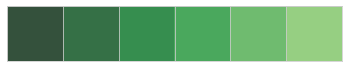

In [478]:
sns.palplot(paletteMut)

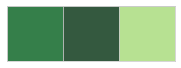

In [479]:
norm = mcolors.Normalize(vmin=0, vmax=1)
mutValues = familyDf5[familyDf5['family'] == 'RAS']['mutation_count_norm_within_family'].values
sns.palplot(paletteMutCmap(norm(mutValues)))

PC1: 25.1%
PC2: 2.0%
PC3: 1.5%
PC4: 1.3%
Bbox(x0=366.03800000000007, y0=255.62665233076638, x1=433.86300000000006, y1=296.4454023307664)
[[0.2112753  0.50161431 0.29396084 1.        ]
 [0.20571002 0.35274306 0.24758351 1.        ]
 [0.71962578 0.88297322 0.57635781 1.        ]]


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:572: UserWarning: The handle <matplotlib.collections.PathCollection object at 0x7f4d3f568c40> has a label of '_nolegend_' which cannot be automatically added to the legend.
  ax.legend(handles, labels, loc="best", title=title)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:572: UserWarning: The handle <matplotlib.collections.PathCollection object at 0x7f4d3f568c40> has a label of '_nolegend_' which cannot be automatically added to the legend.
  ax.legend(handles, labels, loc="best", title=title)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:572: UserWarning: The handle <matplotlib.collections.PathCollection object at 0x7f4d3f568c40> has a label of '_nolegend_' which cannot be automatically added to the legend.
  ax.legend(handles, labels, loc="best", title=title)
/home/m

Bbox(x0=366.03800000000007, y0=118.47894460699406, x1=436.63800000000003, y1=206.07894460699407)


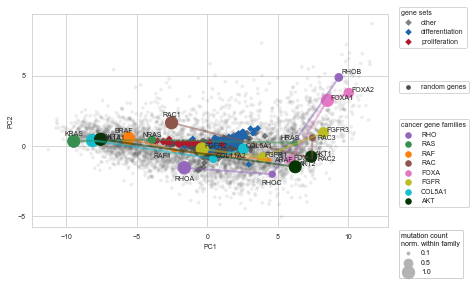

In [515]:
set_fontsize_paper()

xlabel = 'PC1'
ylabel = 'PC2'
# ylabel = pcLabelList[2]

aspect = 1/1
width = 5.5
legendX = 1.02
markerSize = 22
fig, ax = plt.subplots(figsize=(width, width*aspect))
ax.set_aspect('equal')

# Plot PCA of random background genes

label = 'random'
plotDf = pcaGeneBasedGeneDf.sample(5000)
markerSizeRandom = 0.6*markerSize
sns.regplot(ax=ax, x=xlabel, y=ylabel, data=plotDf, fit_reg=False, label='_no_legend_',
            color=paletteDict[label], scatter_kws={'s':markerSizeRandom, 'alpha':alphaDict[label],
                                                   'edgecolor':'none'})

### Plot PCA of gene sets
df = pcaGeneBasedGOSetGenesDf2.groupby('GO_acc').first().copy()

for pole in ['other', 'differentiation', 'proliferation']:
    df1 = df[df['pole'] == pole]
    sns.regplot(ax=ax, x=xlabel, y=ylabel, data=df1, fit_reg=False, label=pole, color=paletteDict[pole],
                marker='D', scatter_kws={'s':markerSize, 'alpha':alphaDict[pole], 'edgecolor':'none'})

explVarString = "\n".join(["{}: {:.1f}%".format(label, var) for label, var in zip(pcLabelList, pcaPipe.named_steps.PCA.explained_variance_)])
print(explVarString)

legendGO = plt.legend(bbox_to_anchor=(legendX, 1.05), loc='upper left', title='gene sets')
legendGO._legend_box.align = 'left'
nlines = len(ax.lines)
ax.add_artist(legendGO)

# Legend for random genes
fig.canvas.draw()
legendGOBbox = legendGO.get_window_extent()
print(legendGOBbox)
legend_elements = [plt.scatter([], [], color=paletteDict['random'], s=markerSizeRandom)]
legend3 = ax.legend(legend_elements, ['random genes'], loc='upper left',
                     bbox_to_anchor=(legendX, 0.7))
legend3._legend_box.align = 'left'
ax.add_artist(legend3)


### Plot PCA of genes within GO sets

# df = pcaGeneBasedGoSetGenesDf
# for pole in ['differentiation', 'proliferation']:
#     df1 = df[df['pole'] == pole].drop_duplicates(subset=['uniprot_id'])
#     if pole == 'other':
#         df1 = df1.sample(4000)
#     sns.regplot(ax=ax, x=xlabel, y=ylabel, data=df1, fit_reg=False, label=pole,
#                 color=paletteDict[pole], scatter_kws={'s':markerSize, 'alpha':0.25, 'edgecolor':'none'})

# Plot cancer gene families

plotFamilyDf = pcaGeneBasedFamilyDf
mutCol = 'mutation_count_norm_within_family'
markerSizeScaling = 40

if mutCol == 'mutation_count':
    markerSizeScaling = 1
    legendMutvalues = [1, 10, 100]
elif mutCol in ['mutation_count_norm_within_family', 'dn/ds_norm_within_family']:
    markerSizeScaling = 150
    legendMutvalues = [0.05, 0.5, 1]
elif mutCol == 'dn/ds':
    markerSizeScaling = 20
    legendMutvalues = [1, 5, 20]

def compute_marker_size(values, markerSizeScaling):
    # The marker size in matplolib already increases the **area** of the marker disk
    return 1*markerSizeScaling*values
    

colorList = []
plotFamilyList = ['RAS', 'RAF', 'RAC', 'RHO']
plotFamilyList = familyCancerList
# plotFamilyList = ['RAS']

p = 2.5
labelGeneFamilyDict = {
    'HRAS':{'offset':(-2*p, 1*p), 'ha':'center', 'va':'bottom'},
    'NRAS':{'offset':(0, p), 'ha':'center', 'va':'bottom'},
    'KRAS':{'offset':(0, 2*p), 'ha':'center', 'va':'bottom'},
    'BRAF':{'offset':(-2*p, 2*p), 'ha':'center', 'va':'bottom'},
    'RAF1':{'offset':(-p, -p), 'ha':'right', 'va':'top'},
    'ARAF':{'offset':(2*p, 0), 'ha':'left', 'va':'center'},
    'RAC1':{'offset':(0, 2*p), 'ha':'center', 'va':'bottom'},
    'RAC3':{'offset':(2*p, 0), 'ha':'left', 'va':'center'},
    'RAC2':{'offset':(2*p, 0), 'ha':'left', 'va':'center'},
    'RHOA':{'offset':(0, -3*p), 'ha':'center', 'va':'top'},
    'RHOC':{'offset':(0, -2*p), 'ha':'center', 'va':'top'},
    'RHOB':{'offset':(p, p), 'ha':'left', 'va':'bottom'},
}

for i, family in enumerate(plotFamilyList):
    plotDf = plotFamilyDf[plotFamilyDf['family'] == family].sort_values('PC1')
    sizeS = compute_marker_size(plotDf[mutCol], markerSizeScaling)
    isCancerFamily = plotDf['is_cancer_family'].iloc[0]
    if family == 'RAS':
        norm = mcolors.Normalize(vmin=0, vmax=1)
        mutValues = familyDf5[familyDf5['family'] == family]['mutation_count_norm_within_family'].values
        colors = paletteMutCmap(norm(mutValues))
        print(colors)

    color = paletteFamily[family]
    colorList.append(color)
    alpha = 1
    alphaLine = 0.5
    label = family
#     if family == 'RAS':
    if False:
        # does not work very well
        sns.regplot(ax=ax, x=xlabel, y=ylabel, data=plotDf, fit_reg=False,
                    scatter_kws={'s':sizeS, 'alpha':alpha, 'facecolors':colors, 'edgecolors':colors},
                    label=label)
    else:
        sns.regplot(ax=ax, x=xlabel, y=ylabel, data=plotDf, fit_reg=False,
                    color=color, scatter_kws={'s':sizeS, 'alpha':alpha},
                    label=label)
    # Add labels to each point
    for index, row in plotDf.iterrows():
        if row['gene'] in labelGeneFamilyDict.keys():
            offset = labelGeneFamilyDict[row['gene']]['offset']
            xy = (row[xlabel], row[ylabel])
            ha = labelGeneFamilyDict[row['gene']]['ha']
            va = labelGeneFamilyDict[row['gene']]['va']
        else:
            offset = (p, 0)
            xy = (row[xlabel], row[ylabel])
            ha = 'left'
            va = 'bottom'
        label1 = row['gene'] if len(plotFamilyList) < 6 else ''
        label1 = row['gene']
        ax.annotate(label1, xy=xy, xytext=offset, ha=ha, va=va, textcoords='offset points')
    # Add line between family members
    plotDf.plot(ax=ax, x=xlabel, y=ylabel, alpha=alphaLine, color=color, lw=2, label='_nolegend_')

legend_elements = [plt.scatter([], [], color=colorList[i], s=markerSizeScaling*0.5)
                   for i, fam in enumerate(plotFamilyList)]
legend2 = ax.legend(legend_elements, plotFamilyList, loc='center left',
                     bbox_to_anchor=(legendX, 0.3), title='cancer gene families')
legend2._legend_box.align = 'left'
for handle in legend2.legendHandles:
    handle._sizes = [30]
ax.add_artist(legend2)
fig.canvas.draw()
legend2Bbox = legend2.get_window_extent()
print(legend2Bbox)

ax.set_yticks(ax.get_xticks())

legendBubbleColor = '0.7'
legendBubbles = [plt.scatter([],[], s=compute_marker_size(value, markerSizeScaling), c=legendBubbleColor)
                 for value in legendMutvalues]
if mutCol == 'mutation_count_norm_within_family':
    title = 'mutation count\nnorm. within family'
else:
    title = mutCol
title = re.sub(r'_', r' ', title)
legendBubbleLabels = ['{:.1f}'.format(l) for l in legendMutvalues]
legend3 = plt.legend(legendBubbles, legendBubbleLabels, title=title,
                     loc='upper left', bbox_to_anchor=(legendX, 0.0))
legend3._legend_box.align = 'left'
ax.add_artist(legend3)
    
plt.tight_layout()
suffix = geneSetPCAMethod
if plotFamilyList == ['RAS']:
    suffix2 = 'RAS'
else:
    suffix2 = 'allFamilies'
filename = str(outputPath / 'GO sets' / 'PCA_projection_gene-based_{}_withnames'.format(suffix2))
plt.savefig(filename + '.png', dpi=600, bbox_inches='tight')
plt.savefig(filename + '.svg')

#### Examine gene set poles

We choose the extreme gene sets as the sets with the most extreme PC1 but with at least 50 genes. We try to choose GO terms that are related to the general functions differentiation / proliferation.

In [499]:
pcaGOSetDf.sort_values('PC1').to_excel(outputPath / 'GO sets' / 'pcaGOSetDf.xlsx')

In [500]:
import scipy.stats

In [518]:
df = pcaGOSetDf.sort_values('PC1')
n = 30

df1 = df.iloc[:n]
df2 = df.iloc[n:]

pole = 'proliferation'
print(len(df1))
nObsPole = (df1['pole'] == pole).sum()
nObsNotPole = (df1['pole'] != pole).sum()
print(len(df2))
nRefPole = (df2['pole'] == pole).sum()
nRefNotPole = (df2['pole'] != pole).sum()
print(nObsPole, nObsNotPole, nRefPole, nRefNotPole)

contingencyTable = [[nObsPole, nRefPole], [nObsNotPole, nRefNotPole]]
oddsRatio, pvalue = scipy.stats.fisher_exact(contingencyTable, alternative='two-sided')
oddsRatio, pvalue

30
678
16 14 12 666


(63.42857142857143, 2.1834230336411287e-17)

In [519]:
df1

,GO_term_id,GO_name,parent_term,pole,PC1,PC2,PC3,PC4,n_seq
GO_acc,,,,,,,,,
GO:0007099,6024,centriole replication,cell cycle,proliferation,-4.015491,0.501403,-0.247749,0.253540,31
GO:0007062,5989,sister chromatid cohesion,cell cycle,proliferation,-3.702697,0.314548,-0.470800,0.144980,130
GO:0008608,7102,attachment of spindle microtubules to kinetochore,cell cycle,proliferation,-3.533791,0.390218,-0.418181,0.148652,33
GO:0098813,37081,nuclear chromosome segregation,cell cycle,proliferation,-3.130826,0.272370,-0.359398,0.049152,299
GO:1901976,40031,regulation of cell cycle checkpoint,cell cycle,proliferation,-3.130791,0.351533,-0.709025,0.170116,31
GO:0007059,102,chromosome segregation,NaN,other,-3.000098,0.304980,-0.353815,0.003262,346
GO:0051304,28406,chromosome separation,cell cycle,proliferation,-2.868304,0.253578,-0.377036,-0.035067,75
GO:0007098,6023,centrosome cycle,cell cycle,proliferation,-2.813828,0.360801,-0.204793,0.045422,114
GO:0031577,15582,spindle checkpoint,cell cycle,proliferation,-2.703098,0.418761,-0.614328,-0.109981,32


In [520]:
df = pcaGOSetDf.sort_values('PC1')
n = 30

df1 = df.iloc[-n:]
df2 = df.iloc[:-n]

pole = 'differentiation'
print(len(df1))
nObsPole = (df1['pole'] == pole).sum()
nObsNotPole = (df1['pole'] != pole).sum()
print(len(df2))
nRefPole = (df2['pole'] == pole).sum()
nRefNotPole = (df2['pole'] != pole).sum()
print(nObsPole, nObsNotPole, nRefPole, nRefNotPole)

contingencyTable = [[nObsPole, nRefPole], [nObsNotPole, nRefNotPole]]
oddsRatio, pvalue = scipy.stats.fisher_exact(contingencyTable, alternative='two-sided')
oddsRatio, pvalue

30
678
14 16 81 597


(6.449074074074074, 5.794169774377978e-06)

In [521]:
print((df['pole'] == 'differentiation').sum())
print(len(df))

95
708


In [529]:
term = 'cell proliferation'
# get all descendants of GO term
df = pcaGOSetDf.loc[pcaGOSetDf.index.intersection(graphPathDf3[graphPathDf3['GO_name1'] == term]
                                             ['GO_acc2'].dropna().values)].dropna(subset=['PC1'])
df

,GO_term_id,GO_name,parent_term,pole,PC1,PC2,PC3,PC4,n_seq
GO:0008283,6803,cell proliferation,NaN,other,0.814454,0.108192,0.003792,-0.040211,1952
GO:0008284,6804,positive regulation of cell proliferation,positive regulation of cell proliferation,proliferation,1.077496,0.111335,0.072082,-0.044716,848
GO:0008284,6804,positive regulation of cell proliferation,positive regulation of cell proliferation,proliferation,1.077496,0.111335,0.072082,-0.044716,848
GO:0008285,6805,negative regulation of cell proliferation,NaN,other,1.222305,0.147684,0.012166,-0.042993,650
GO:0008285,6805,negative regulation of cell proliferation,NaN,other,1.222305,0.147684,0.012166,-0.042993,650
GO:0010463,8890,mesenchymal cell proliferation,NaN,other,2.833757,0.917508,-0.030534,0.050335,47
GO:0014009,9439,glial cell proliferation,cell differentiation,differentiation,2.171352,0.390506,-0.182327,-0.161831,68
GO:0033002,16945,muscle cell proliferation,NaN,other,0.851055,0.282867,-0.087024,-0.198305,172
GO:0042127,20999,regulation of cell proliferation,NaN,other,1.096511,0.139454,0.030602,-0.051447,1544
GO:0048144,26489,fibroblast proliferation,NaN,other,1.215469,-0.019495,-0.231377,-0.155655,82


In [532]:
term = 'cell cycle'
# get all descendants of GO term
df = pcaGOSetDf.loc[pcaGOSetDf.index.intersection(graphPathDf3[graphPathDf3['GO_name1'] == term]
                                             ['GO_acc2'].dropna().values)].dropna(subset=['PC1'])
df

,GO_term_id,GO_name,parent_term,pole,PC1,PC2,PC3,PC4,n_seq
GO:0000075,108,cell cycle checkpoint,cell cycle,proliferation,-1.730257,0.227142,-0.463765,0.149426,215
GO:0000075,108,cell cycle checkpoint,cell cycle,proliferation,-1.730257,0.227142,-0.463765,0.149426,215
GO:0000910,673,cytokinesis,cell cycle,proliferation,-0.672015,0.212194,-0.326552,0.047303,143
GO:0007049,5978,cell cycle,cell cycle,proliferation,-1.006931,0.242761,-0.249497,0.090680,1799
GO:0007050,5979,cell cycle arrest,cell cycle,proliferation,0.178622,0.290165,-0.201614,0.050441,242
GO:0007050,5979,cell cycle arrest,cell cycle,proliferation,0.178622,0.290165,-0.201614,0.050441,242
GO:0007050,5979,cell cycle arrest,cell cycle,proliferation,0.178622,0.290165,-0.201614,0.050441,242
GO:0007051,5980,spindle organization,cell cycle,proliferation,-2.017822,0.232531,-0.337580,0.094652,177
GO:0007062,5989,sister chromatid cohesion,cell cycle,proliferation,-3.702697,0.314548,-0.470800,0.144980,130
GO:0007093,6018,mitotic cell cycle checkpoint,cell cycle,proliferation,-1.395166,0.205480,-0.485680,0.141347,163


In [533]:
term = 'transport'
df = pcaGOSetDf.loc[pcaGOSetDf.index.intersection(graphPathDf3[graphPathDf3['GO_name1'] == term]
                                             ['GO_acc2'].dropna().values)].dropna(subset=['PC1'])
df

,GO_term_id,GO_name,parent_term,pole,PC1,PC2,PC3,PC4,n_seq
GO:0002433,1929,immune response-regulating cell surface recept...,NaN,other,0.324478,-0.166067,-0.290632,-0.140074,73
GO:0006810,5768,transport,NaN,other,0.294553,-0.046728,-0.155256,-0.109704,4791
GO:0006903,4531,vesicle targeting,NaN,other,-1.015442,-0.030160,-0.283311,-0.124161,81
GO:0007269,6177,neurotransmitter secretion,NaN,other,1.199788,0.163884,-0.107748,-0.046580,145
GO:0016079,10639,synaptic vesicle exocytosis,NaN,other,0.809949,0.119512,-0.123636,0.079735,87
GO:0016079,10639,synaptic vesicle exocytosis,NaN,other,0.809949,0.119512,-0.123636,0.079735,87
GO:0031623,15628,receptor internalization,NaN,other,0.792327,-0.079691,0.026170,-0.179897,92
GO:0032409,16377,regulation of transporter activity,NaN,other,1.303213,-0.033940,-0.011689,-0.281638,234
GO:0032940,16883,secretion by cell,NaN,other,0.706979,-0.062905,-0.089418,-0.176691,1427
GO:0032941,16884,secretion by tissue,NaN,other,1.220356,-0.013674,-0.069573,-0.345377,83


#### Compare PC1 to general CAI

In [548]:
geneCAIDf[['CCDS_id', 'CAI all']].head()

,CCDS_id,CAI all
10702,CCDS56585.1,0.815952
18344,CCDS61813.1,0.900747
12033,CCDS33681.1,0.861722
3378,CCDS3275.1,0.816863
10919,CCDS31095.1,0.843628


In [549]:
print(len(pcaGeneBasedGeneDf))
pcaGeneBasedGeneDf.head()

18388


,gene,uniprot_id,PC1,PC2,PC3,PC4
CCDS_id,,,,,,
CCDS10.1,TNFRSF18,Q9Y5U5,7.299647,2.574849,1.284763,0.762616
CCDS100.2,GPR157,Q5UAW9,7.739260,2.054957,0.144181,-0.739597
CCDS1000.1,TUFT1,Q9NNX1,0.945298,0.052726,0.301444,2.414820
CCDS10000.1,NUDT14,O95848,4.696337,-0.022438,-2.203740,0.598976
CCDS10001.1,BRF1,Q92994,5.350035,0.787794,1.152289,0.560182


In [550]:
geneCAIPCADf = pcaGeneBasedGeneDf.join(geneCAIDf[['CCDS_id', 'CAI all']].set_index('CCDS_id'))
geneCAIPCADf.head()

,gene,uniprot_id,PC1,PC2,PC3,PC4,CAI all
CCDS_id,,,,,,,
CCDS10.1,TNFRSF18,Q9Y5U5,7.299647,2.574849,1.284763,0.762616,0.833090
CCDS100.2,GPR157,Q5UAW9,7.739260,2.054957,0.144181,-0.739597,0.865442
CCDS1000.1,TUFT1,Q9NNX1,0.945298,0.052726,0.301444,2.414820,0.830515
CCDS10000.1,NUDT14,O95848,4.696337,-0.022438,-2.203740,0.598976,0.873478
CCDS10001.1,BRF1,Q92994,5.350035,0.787794,1.152289,0.560182,0.863763


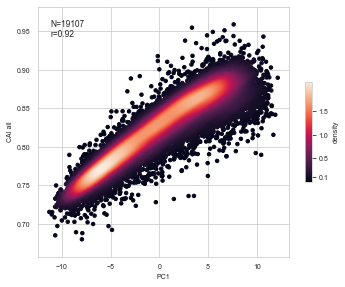

In [551]:
xlabel = 'PC1'
ylabel = 'CAI all'
df = geneCAIPCADf.dropna(subset=[xlabel, ylabel])
# df1 = df.sample(5000)
df1 = df

fig, ax = plt.subplots(figsize=(5, 4))

df1, x, y, z = compute_scatter_density(df1, xlabel, ylabel, ax)
df1['x'] = x
df1['y'] = y
df1['density'] = z
points = ax.scatter(x=x, y=y, c=z, marker="o", s=12)
plt.colorbar(points, label='density', shrink=0.4, aspect=15, ticks = [0.1, 0.5, 1, 1.5])
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

pearson = df1[[xlabel, ylabel]].corr().iloc[0, 1]
ax.annotate('N={:d}\nr={:.2f}'.format(len(df1), pearson), xy=(0.05, 0.95),
            xycoords='axes fraction', ha='left', va='top', fontsize='large')
plt.tight_layout()
plt.savefig(str(outputPath / 'CAI_computation_compare' / 'PC1_CAI_all.png'), dpi=300)

#### Compare PC1 to prol/diff axis

In [552]:
cat1, cat2

('positive regulation of mitotic cell cycle', 'pattern specification process')

In [560]:
geneCAIDf.head()

,CCDS_id,CDS,GO_acc,GO_name,GO_super_acc,GO_super_name,abundance category,gene,set,species_taxid,...,CAI positive regulation of mitotic cell cycle,metric positive regulation of mitotic cell cycle,CAI pattern specification process,metric pattern specification process,CAI mitotic M phase,metric mitotic M phase,CAI all,metric all,metric_ratio,CAI_ratio
10702,CCDS56585.1,ATGGCGGACCAGCAAGGACCTCATCAGAATAGGTTTCCATCGTGTG...,NaN,NaN,NaN,NaN,NaN,ODF2,all,NaN,...,0.844944,0.655336,0.782286,0.590526,0.771237,0.917658,0.815952,0.556214,0.643515,1.014326
18344,CCDS61813.1,ATGCGCACTCACACGGACGAGCGGCCGCACGCCTGCCACCTGTGCG...,NaN,NaN,NaN,NaN,NaN,ZSCAN10,all,NaN,...,0.889961,4.897068,0.900930,4.118563,0.662188,6.567816,0.900747,4.428519,0.627083,1.360535
12033,CCDS33681.1,ATGTTCTGGAAGTTTGACTTGAACACCACGTCCCATGTTGACAAGC...,NaN,NaN,NaN,NaN,NaN,PPP6R2,all,NaN,...,0.876908,0.931679,0.839237,0.593239,0.737263,1.848593,0.861722,0.688317,0.320914,1.138314
3378,CCDS3275.1,ATGTCTAAAACTGGAACCAAGATTACTTTCTATGAAGACAAAAATT...,NaN,NaN,NaN,NaN,NaN,CRYGS,all,NaN,...,0.851521,1.625370,0.776999,1.661597,0.777584,1.897232,0.816863,1.567457,0.875801,0.999248
10919,CCDS31095.1,ATGGACACAGGCAACAAAACTCTGCCCCAGGACTTTCTCTTACTGG...,NaN,NaN,NaN,NaN,NaN,OR6F1,all,NaN,...,0.877154,0.779719,0.811949,0.700065,0.771905,1.333876,0.843628,0.701385,0.524835,1.051877


In [563]:
geneCAIDf2 = geneCAIDf.set_index('CCDS_id').join(geneCAIPCADf.drop(['gene', 'uniprot_id', 'CAI all'], axis=1))
geneCAIDf2.head()

,CDS,GO_acc,GO_name,GO_super_acc,GO_super_name,abundance category,gene,set,species_taxid,synonym,...,CAI mitotic M phase,metric mitotic M phase,CAI all,metric all,metric_ratio,CAI_ratio,PC1,PC2,PC3,PC4
CCDS_id,,,,,,,,,,,,,,,,,,,,,
CCDS10.1,ATGGCACAGCACGGGGCGATGGGCGCGTTTCGGGCCCTGTGCGGCC...,NaN,NaN,NaN,NaN,NaN,TNFRSF18,all,NaN,NaN,...,0.650452,4.624000,0.833090,2.963613,0.593451,1.269942,7.299647,2.574849,1.284763,0.762616
CCDS100.2,ATGCAGCCGTCCCCGCCGCCCACCGAGCTGGTGCCGTCGGAGCGCG...,NaN,NaN,NaN,NaN,NaN,GPR157,all,NaN,NaN,...,0.678183,4.200337,0.865442,2.383945,0.515342,1.264040,7.739260,2.054957,0.144181,-0.739597
CCDS1000.1,ATGAACGGGACGCGGAACTGGTGTACCCTGGTGGACGTGCACCCAG...,NaN,NaN,NaN,NaN,NaN,TUFT1,all,NaN,NaN,...,0.761688,1.382281,0.830515,0.767907,0.548486,1.051391,0.945298,0.052726,0.301444,2.414820
CCDS10000.1,ATGGAGCGCATCGAGGGGGCGTCCGTGGGCCGCTGCGCCGCCTCAC...,NaN,NaN,NaN,NaN,NaN,NUDT14,all,NaN,NaN,...,0.738459,2.716861,0.873478,1.418195,0.480405,1.152836,4.696337,-0.022438,-2.203740,0.598976
CCDS10001.1,ATGACGGGCCGCGTGTGCCGCGGTTGCGGCGGCACGGACATCGAGC...,NaN,NaN,NaN,NaN,NaN,BRF1,all,NaN,NaN,...,0.710072,2.449532,0.863763,1.001627,0.330971,1.199802,5.350035,0.787794,1.152289,0.560182


In [565]:
df = geneCAIDf2[geneCAIDf2['set'] == 'all'].dropna(subset=[xlabel, ylabel])
len(df)
df.iloc[:, -12:].corr()#.style.background_gradient(cmap=get_divergent_color_map(), low=0.2, high=0.2)

,CAI pattern specification process,metric pattern specification process,CAI mitotic M phase,metric mitotic M phase,CAI all,metric all,metric_ratio,CAI_ratio,PC1,PC2,PC3,PC4
CAI pattern specification process,1.000000,0.076521,-0.832834,0.648659,0.988511,0.191314,-0.680404,0.949074,0.963054,-0.155634,-0.043517,0.011144
metric pattern specification process,0.076521,1.000000,-0.196592,0.789587,0.036361,0.992171,-0.031242,0.174693,0.134197,0.196752,0.048331,-0.065186
CAI mitotic M phase,-0.832834,-0.196592,1.000000,-0.727806,-0.745970,-0.313364,0.623905,-0.960608,-0.942269,-0.213401,-0.143748,0.030615
metric mitotic M phase,0.648659,0.789587,-0.727806,1.000000,0.589621,0.859086,-0.445896,0.739912,0.711434,0.151501,0.063159,-0.053583
CAI all,0.988511,0.036361,-0.745970,0.589621,1.000000,0.143786,-0.666689,0.893387,0.917140,-0.272363,-0.084220,0.012032
metric all,0.191314,0.992171,-0.313364,0.859086,0.143786,1.000000,-0.114004,0.294848,0.254396,0.209589,0.056166,-0.063129
metric_ratio,-0.680404,-0.031242,0.623905,-0.445896,-0.666689,-0.114004,1.000000,-0.655406,-0.686113,0.140176,-0.064077,-0.012783
CAI_ratio,0.949074,0.174693,-0.960608,0.739912,0.893387,0.294848,-0.655406,1.000000,0.991938,0.063790,0.051446,-0.011208
PC1,0.963054,0.134197,-0.942269,0.711434,0.917140,0.254396,-0.686113,0.991938,1.000000,-0.000509,0.001123,0.000824
PC2,-0.155634,0.196752,-0.213401,0.151501,-0.272363,0.209589,0.140176,0.063790,-0.000509,1.000000,0.000697,0.000194


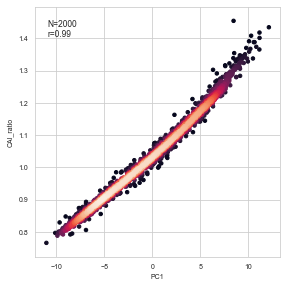

In [566]:
xlabel = 'PC1'
ylabel = 'CAI_ratio'
plotDf = geneCAIDf2[geneCAIDf2['set'] == 'all'].dropna(subset=[xlabel, ylabel]).sample(2000)

fig, ax = plt.subplots(figsize=(4, 4))

plotDf, x, y, z = compute_scatter_density(plotDf, xlabel, ylabel, ax)
ax.scatter(x=x, y=y, c=z, marker="o", s=12)
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
# xmin = 0.6
# xmax = 1
# ax.axis('equal')
# ax.plot([xmin,xmin], [xmax,xmax], lw=10, c='black')
# ax.set_xlim((xmin,xmax))
# ax.set_ylim((xmin,xmax))

pearson = plotDf[[xlabel, ylabel]].corr().iloc[0, 1]
ax.annotate('N={:d}\nr={:.2f}'.format(len(plotDf), pearson), xy=(0.05, 0.95),
            xycoords='axes fraction', ha='left', va='top', fontsize='large')
plt.tight_layout()
plt.savefig(str(outputPath / 'CAI_computation_compare' / 'PC1_CAI_ratio.png'), dpi=300)

There is a strong overlap/correlation between the general CAI axis and the CAI ratio.

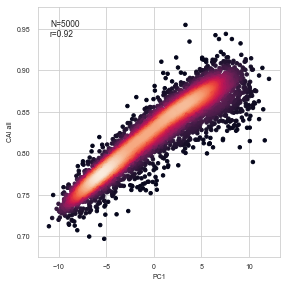

In [569]:
#### xlabel = 'CAI_ratio'
ylabel = 'CAI all'
plotDf = geneCAIDf2[geneCAIDf2['set'] == 'all'].dropna(subset=[xlabel, ylabel]).sample(5000)

fig, ax = plt.subplots(figsize=(4, 4))

plotDf, x, y, z = compute_scatter_density(plotDf, xlabel, ylabel, ax)
ax.scatter(x=x, y=y, c=z, marker="o", s=12)
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
# xmin = 0.6
# xmax = 1
# ax.axis('equal')
# ax.plot([xmin,xmin], [xmax,xmax], lw=10, c='black')
# ax.set_xlim((xmin,xmax))
# ax.set_ylim((xmin,xmax))

pearson = plotDf[[xlabel, ylabel]].corr().iloc[0, 1]
ax.annotate('N={:d}\nr={:.2f}'.format(len(plotDf), pearson), xy=(0.05, 0.95),
            xycoords='axes fraction', ha='left', va='top', fontsize='large')
plt.tight_layout()
plt.savefig(str(outputPath / 'CAI_computation_compare' / 'CAI_all_CAI_ratio.png'), dpi=300)

## Gene families

For now we use the set of reference sequences retrieved from Ensembl above, for the 2 GO categories.

### Compute CAI and metric

In [570]:
familyCAIPCADf = pcaGeneBasedFamilyDf
familyCAIPCADf.head()

,gene,dn/ds,dn/ds_Genie,family,is_cancer_family,mutation_count,mutation_count_Genie,sequence_identity_to_representative,similarity_cutoff,mutation_count_norm_within_family,dn/ds_norm_within_family,CCDS_id,CDS,uniprot_id,n_members,PC1,PC2,PC3,PC4
171,PCDHA1,0.813784,NaN,PCDHA6,False,131.0,NaN,80.9474,79.373909,0.977612,0.244675,CCDS54912.1,ATGGTGTTTTCTAGGAGAGGGGGCCTGGGAGCCCGGGATCTGCTTC...,Q9Y5I3,12,0.744821,2.354484,0.362967,-0.853076
172,PCDHA10,0.313736,NaN,PCDHA6,False,115.0,NaN,81.2236,79.373909,0.858209,0.094329,CCDS34255.1,ATGGTTTCCAGATGTAGCTGCCTGGGGGTCCAGTGTCTGCTGCTCT...,Q9Y5I2,12,1.047981,2.755294,0.404832,-0.222558
173,PCDHA11,2.119512,NaN,PCDHA6,False,116.0,NaN,81.2434,79.373909,0.865672,0.637259,CCDS47284.1,ATGTTTGGTTTTCAGAGAAGGGGATTGGGCACCCCACGACTACAGC...,Q9Y5I1,12,2.636393,3.914601,-0.018011,-0.366692
174,PCDHA12,2.550970,NaN,PCDHA6,False,107.0,NaN,81.4028,79.373909,0.798507,0.766983,CCDS47285.1,ATGGTGATTATCGGACCAAGAGGCCCGGGATCCCAGCGTCTGCTGC...,Q9UN75,12,2.492887,4.240856,-0.022660,0.198635
175,PCDHA13,0.478978,NaN,PCDHA6,False,100.0,NaN,80.5263,79.373909,0.746269,0.144011,CCDS4240.1,ATGCTGTCTTCCTGGCAAGGAGGCCCAAGACCGCGGCAACTACTGC...,Q9Y5I0,12,2.321692,4.375330,0.339700,0.239023


In [574]:
familyCAIPCADf.to_csv(outputPath / 'familyCAIPCADf.csv')

In [143]:
familyCAIPCADf = pd.read_csv(outputPath / 'familyCAIPCADf.csv', index_col=0)
familyCAIPCADf.head()

,gene,dn/ds,dn/ds_Genie,family,is_cancer_family,mutation_count,mutation_count_Genie,sequence_identity_to_representative,similarity_cutoff,mutation_count_norm_within_family,dn/ds_norm_within_family,CCDS_id,CDS,uniprot_id,n_members,PC1,PC2,PC3,PC4
171,PCDHA1,0.813784,NaN,PCDHA6,False,131.0,NaN,80.9474,79.373909,0.977612,0.244675,CCDS54912.1,ATGGTGTTTTCTAGGAGAGGGGGCCTGGGAGCCCGGGATCTGCTTC...,Q9Y5I3,12,0.744821,2.354484,0.362967,-0.853076
172,PCDHA10,0.313736,NaN,PCDHA6,False,115.0,NaN,81.2236,79.373909,0.858209,0.094329,CCDS34255.1,ATGGTTTCCAGATGTAGCTGCCTGGGGGTCCAGTGTCTGCTGCTCT...,Q9Y5I2,12,1.047981,2.755294,0.404832,-0.222558
173,PCDHA11,2.119512,NaN,PCDHA6,False,116.0,NaN,81.2434,79.373909,0.865672,0.637259,CCDS47284.1,ATGTTTGGTTTTCAGAGAAGGGGATTGGGCACCCCACGACTACAGC...,Q9Y5I1,12,2.636393,3.914601,-0.018011,-0.366692
174,PCDHA12,2.550970,NaN,PCDHA6,False,107.0,NaN,81.4028,79.373909,0.798507,0.766983,CCDS47285.1,ATGGTGATTATCGGACCAAGAGGCCCGGGATCCCAGCGTCTGCTGC...,Q9UN75,12,2.492887,4.240856,-0.022660,0.198635
175,PCDHA13,0.478978,NaN,PCDHA6,False,100.0,NaN,80.5263,79.373909,0.746269,0.144011,CCDS4240.1,ATGCTGTCTTCCTGGCAAGGAGGCCCAAGACCGCGGCAACTACTGC...,Q9Y5I0,12,2.321692,4.375330,0.339700,0.239023


### Pattern signifiance: covariance

#### Covariance

We are taking all background families, even the ones for which there is almost no difference in mutation frequency. A different measure for the intensity of the pattern would be the *covariance* in the family in the space PC1 - mutation frequency. The meaning is that for families which have large difference both in codon usage *and* in mutation frequency, these difference tend to be negatively correlated in the case of cancer families, while in the background families these differences are randomly distributed between positive and negative correlations. Families with little variation in either codon usage or mutation frequency are not significantly contributing to the pattern.

In [149]:
from scipy import stats

import mwTools
import mwTools.plot
from mwTools.plot import pvalAnnotation_text
from statannot.statannot import add_stat_annotation

In [144]:
familyCAIPCADf.head()

,gene,dn/ds,dn/ds_Genie,family,is_cancer_family,mutation_count,mutation_count_Genie,sequence_identity_to_representative,similarity_cutoff,mutation_count_norm_within_family,dn/ds_norm_within_family,CCDS_id,CDS,uniprot_id,n_members,PC1,PC2,PC3,PC4
171,PCDHA1,0.813784,NaN,PCDHA6,False,131.0,NaN,80.9474,79.373909,0.977612,0.244675,CCDS54912.1,ATGGTGTTTTCTAGGAGAGGGGGCCTGGGAGCCCGGGATCTGCTTC...,Q9Y5I3,12,0.744821,2.354484,0.362967,-0.853076
172,PCDHA10,0.313736,NaN,PCDHA6,False,115.0,NaN,81.2236,79.373909,0.858209,0.094329,CCDS34255.1,ATGGTTTCCAGATGTAGCTGCCTGGGGGTCCAGTGTCTGCTGCTCT...,Q9Y5I2,12,1.047981,2.755294,0.404832,-0.222558
173,PCDHA11,2.119512,NaN,PCDHA6,False,116.0,NaN,81.2434,79.373909,0.865672,0.637259,CCDS47284.1,ATGTTTGGTTTTCAGAGAAGGGGATTGGGCACCCCACGACTACAGC...,Q9Y5I1,12,2.636393,3.914601,-0.018011,-0.366692
174,PCDHA12,2.550970,NaN,PCDHA6,False,107.0,NaN,81.4028,79.373909,0.798507,0.766983,CCDS47285.1,ATGGTGATTATCGGACCAAGAGGCCCGGGATCCCAGCGTCTGCTGC...,Q9UN75,12,2.492887,4.240856,-0.022660,0.198635
175,PCDHA13,0.478978,NaN,PCDHA6,False,100.0,NaN,80.5263,79.373909,0.746269,0.144011,CCDS4240.1,ATGCTGTCTTCCTGGCAAGGAGGCCCAAGACCGCGGCAACTACTGC...,Q9Y5I0,12,2.321692,4.375330,0.339700,0.239023


In [145]:
xlabel2 = 'PC1'
ylabel2 = 'mutation_count_norm_within_family'

In [146]:
familyCAIPCADf[familyCAIPCADf['family'] == 'RAS'][[xlabel2, ylabel2]].cov().iloc[0,1]

-3.0621654114951653

In [153]:
from sklearn.linear_model import LinearRegression  
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

mutCol = 'mutation_count_norm_within_family'

PC1min = -11
PC1max = -PC1min

famDf = familyCAIPCADf.copy()
xlabel, ylabel = (mutCol, 'PC1')

familyUnvalidMutValue = famDf[famDf[mutCol] < 0]['family'].unique()
print(familyUnvalidMutValue)

print(len(famDf))
famDf = famDf[famDf['family'].map(lambda fam: fam not in familyUnvalidMutValue)]
print(len(famDf))

# Perform the linear regression for all families.

regressionCoeffList = []

for family, group in famDf.groupby('family'):

    # Linear regression
    regressor = LinearRegression()
    X = group[[xlabel]]
    y = group[ylabel]
    linearReg = regressor.fit(X, y)
    yPred = linearReg.predict(X)
    MSE = mean_squared_error(y, yPred)

    # Covariance
    covar = group[[xlabel, ylabel]].cov().iloc[0, 1]

    regressionCoeffList.append(pd.Series({'family':family,
                                          'regression_coeff':linearReg.coef_[0],
                                          'regression_MSE':MSE,
                                          'covariance':covar
                                         }))
regressionCoeffDf = pd.DataFrame(regressionCoeffList)
print("regressionCoeffDf.head()", regressionCoeffDf.head())

famDf = pd.merge(famDf, regressionCoeffDf, on='family', how='left')
print(famDf.head())

familyCancerList = famDf[famDf['is_cancer_family']]['family'].unique()

familyCancerDf = famDf[famDf['is_cancer_family']]
familyCancerDf = familyCancerDf[familyCancerDf['n_members'] > 2]

familyCancerList = familyCancerDf['family'].unique()
print("len(familyCancerList)", len(familyCancerList))

familyNotCancerDf = famDf[~famDf['is_cancer_family']]
familyNotCancerDf = familyNotCancerDf[familyNotCancerDf['n_members'] > 2]

familyNotCancerList = familyNotCancerDf['family'].unique()
print("len(familyNotCancerList)", len(familyNotCancerList))
familyNotCancerList

regressionCoeffDf2 = regressionCoeffDf.set_index('family')
regressionCoeffDf2['is_cancer_family'] = np.nan
regressionCoeffDf2.loc[familyCancerList, 'is_cancer_family'] = True
regressionCoeffDf2.loc[familyNotCancerList, 'is_cancer_family'] = False
regressionCoeffDf2 = regressionCoeffDf2[~regressionCoeffDf2['is_cancer_family'].isnull()]
print(len(regressionCoeffDf2))

cancerCoeff = regressionCoeffDf2.loc[familyCancerList]['covariance']
notCancerCoeff = regressionCoeffDf2.loc[familyNotCancerList]['covariance']

[]
267
267


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/frame.py:7605: RuntimeWarning: Degrees of freedom <= 0 for slice
  baseCov = np.cov(mat.T)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


regressionCoeffDf.head()   family  regression_coeff  regression_MSE  covariance
0  ACAP2         -8.901587    3.273669e+01   -0.365413
1  ACTN4         -6.525489    1.130915e+00   -0.698253
2    AKT        -65.215242    2.085862e+01   -0.583883
3    ALK         -2.255552    0.000000e+00   -0.464526
4    ANK        -21.072700    4.437343e-30   -1.631873
      gene     dn/ds  dn/ds_Genie  family  is_cancer_family  mutation_count  \
0   PCDHA1  0.813784          NaN  PCDHA6             False           131.0   
1  PCDHA10  0.313736          NaN  PCDHA6             False           115.0   
2  PCDHA11  2.119512          NaN  PCDHA6             False           116.0   
3  PCDHA12  2.550970          NaN  PCDHA6             False           107.0   
4  PCDHA13  0.478978          NaN  PCDHA6             False           100.0   

   mutation_count_Genie  sequence_identity_to_representative  \
0                   NaN                              80.9474   
1                   NaN                   

#### Covariance final plot

In [154]:
mutCol = 'mutation_count_norm_within_family'

PC1min = -11
PC1max = -PC1min

famDf = familyCAIPCADf.copy()
xlabel, ylabel = (mutCol, 'PC1')

familyUnvalidMutValue = famDf[famDf[mutCol] < 0]['family'].unique()
print(familyUnvalidMutValue)

print(len(famDf))
famDf = famDf[famDf['family'].map(lambda fam: fam not in familyUnvalidMutValue)]
print(len(famDf))

[]
267
267


In [155]:
regressionCoeffList = []

for family, group in famDf.groupby('family'):

    # Linear regression
    regressor = LinearRegression()
    X = group[[xlabel]]
    y = group[ylabel]
    linearReg = regressor.fit(X, y)
    yPred = linearReg.predict(X)
    MSE = mean_squared_error(y, yPred)

    # Covariance
    covar = group[[xlabel, ylabel]].cov().iloc[0, 1]

    regressionCoeffList.append(pd.Series({'family':family,
                                          'regression_coeff':linearReg.coef_[0],
                                          'regression_MSE':MSE,
                                          'covariance':covar
                                         }))
regressionCoeffDf = pd.DataFrame(regressionCoeffList)
print("regressionCoeffDf.head()", regressionCoeffDf.head())

famDf = pd.merge(famDf, regressionCoeffDf, on='family', how='left')
famDf.head()

/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/frame.py:7605: RuntimeWarning: Degrees of freedom <= 0 for slice
  baseCov = np.cov(mat.T)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


regressionCoeffDf.head()   family  regression_coeff  regression_MSE  covariance
0  ACAP2         -8.901587    3.273669e+01   -0.365413
1  ACTN4         -6.525489    1.130915e+00   -0.698253
2    AKT        -65.215242    2.085862e+01   -0.583883
3    ALK         -2.255552    0.000000e+00   -0.464526
4    ANK        -21.072700    4.437343e-30   -1.631873


,gene,dn/ds,dn/ds_Genie,family,is_cancer_family,mutation_count,mutation_count_Genie,sequence_identity_to_representative,similarity_cutoff,mutation_count_norm_within_family,...,CDS,uniprot_id,n_members,PC1,PC2,PC3,PC4,regression_coeff,regression_MSE,covariance
0,PCDHA1,0.813784,NaN,PCDHA6,False,131.0,NaN,80.9474,79.373909,0.977612,...,ATGGTGTTTTCTAGGAGAGGGGGCCTGGGAGCCCGGGATCTGCTTC...,Q9Y5I3,12,0.744821,2.354484,0.362967,-0.853076,-2.866376,0.461986,-0.024192
1,PCDHA10,0.313736,NaN,PCDHA6,False,115.0,NaN,81.2236,79.373909,0.858209,...,ATGGTTTCCAGATGTAGCTGCCTGGGGGTCCAGTGTCTGCTGCTCT...,Q9Y5I2,12,1.047981,2.755294,0.404832,-0.222558,-2.866376,0.461986,-0.024192
2,PCDHA11,2.119512,NaN,PCDHA6,False,116.0,NaN,81.2434,79.373909,0.865672,...,ATGTTTGGTTTTCAGAGAAGGGGATTGGGCACCCCACGACTACAGC...,Q9Y5I1,12,2.636393,3.914601,-0.018011,-0.366692,-2.866376,0.461986,-0.024192
3,PCDHA12,2.550970,NaN,PCDHA6,False,107.0,NaN,81.4028,79.373909,0.798507,...,ATGGTGATTATCGGACCAAGAGGCCCGGGATCCCAGCGTCTGCTGC...,Q9UN75,12,2.492887,4.240856,-0.022660,0.198635,-2.866376,0.461986,-0.024192
4,PCDHA13,0.478978,NaN,PCDHA6,False,100.0,NaN,80.5263,79.373909,0.746269,...,ATGCTGTCTTCCTGGCAAGGAGGCCCAAGACCGCGGCAACTACTGC...,Q9Y5I0,12,2.321692,4.375330,0.339700,0.239023,-2.866376,0.461986,-0.024192


In [156]:
famDf.sort_values(['covariance', 'family'], inplace=True)

In [157]:
famDf[~famDf['is_cancer_family']][['family', 'gene', 'covariance']].reset_index(drop=True).to_excel(outputPath / 'gene family' / 'famDf1.xlsx')

In [158]:
famDf.to_csv(outputPath / 'gene family' / 'famDf.csv')

In [159]:
famDf = pd.read_csv(outputPath / 'gene family' / 'famDf.csv', index_col=0)
famDf.head()

,gene,dn/ds,dn/ds_Genie,family,is_cancer_family,mutation_count,mutation_count_Genie,sequence_identity_to_representative,similarity_cutoff,mutation_count_norm_within_family,...,CDS,uniprot_id,n_members,PC1,PC2,PC3,PC4,regression_coeff,regression_MSE,covariance
74,NRAS,4.750884,0.788494,RAS,True,175.0,534.0,85.1852,74.741478,0.356415,...,ATGACTGAGTACAAACTGGTGGTGGTTGGAGCAGGTGGTGTTGGGA...,P01111,3,-3.918689,0.437520,0.887135,3.090817,-16.296346,9.000525e+00,-3.062165
75,HRAS,5.635593,0.894685,RAS,True,86.0,177.0,100.0000,74.741478,0.175153,...,ATGACGGAATATAAGCTGGTGGTGGTGGGCGCCGGCGGTGTGGGCA...,P01112,3,6.221500,0.216370,-2.894585,1.912780,-16.296346,9.000525e+00,-3.062165
76,KRAS,25.681069,0.733630,RAS,True,491.0,2774.0,84.6561,74.741478,1.000000,...,ATGACTGAATATAAACTTGTGGTAGTTGGAGCTGGTGGCGTAGGCA...,P01116,3,-9.483024,0.336131,-0.582128,1.752785,-16.296346,9.000525e+00,-3.062165
248,PTPN6,0.649018,0.858458,PTPN,True,26.0,0.0,51.7628,49.644816,0.426230,...,ATGCTGTCCCGTGGGTGGTTTCACCGAGACCTCAGTGGGCTGGATG...,P29350,2,5.567257,-0.614236,-1.674603,-0.197559,-17.599986,1.577722e-30,-2.897068
249,PTPN11,1.080303,0.771892,PTPN,True,61.0,176.0,100.0000,49.644816,1.000000,...,ATGACATCGCGGAGATGGTTTCACCCAAATATCACTGGTGTGGAGG...,Q06124,2,-4.531095,0.477330,0.650594,-0.725335,-17.599986,1.577722e-30,-2.897068


In [160]:
len(regressionCoeffDf)

87

Note that we include background non-cancer families with more than 3 members (there are with 10-12 members!).

In [162]:
familyCancerList = famDf[famDf['is_cancer_family']]['family'].unique()

familyCancerDf = famDf[famDf['is_cancer_family']]
familyCancerDf = familyCancerDf[familyCancerDf['n_members'] > 2]

familyCancerList = familyCancerDf['family'].unique()
print("len(familyCancerList)", len(familyCancerList))

familyNotCancerDf = famDf[~famDf['is_cancer_family']]
familyNotCancerDf = familyNotCancerDf[familyNotCancerDf['n_members'] > 2]

familyNotCancerList = familyNotCancerDf['family'].unique()
print("len(familyNotCancerList)", len(familyNotCancerList))
familyNotCancerList

regressionCoeffDf2 = regressionCoeffDf.set_index('family')
regressionCoeffDf2['is_cancer_family'] = np.nan
regressionCoeffDf2.loc[familyCancerList, 'is_cancer_family'] = True
regressionCoeffDf2.loc[familyNotCancerList, 'is_cancer_family'] = False
regressionCoeffDf2 = regressionCoeffDf2[~regressionCoeffDf2['is_cancer_family'].isnull()]
print("len(regressionCoeffDf2)", len(regressionCoeffDf2))

cancerCoeff = regressionCoeffDf2.loc[familyCancerList]['covariance']
notCancerCoeff = regressionCoeffDf2.loc[familyNotCancerList]['covariance']

regressionCoeffDf2.head()

len(familyCancerList) 8
len(familyNotCancerList) 63
len(regressionCoeffDf2) 71


,regression_coeff,regression_MSE,covariance,is_cancer_family
family,,,,
ACAP2,-8.901587,32.736686,-0.365413,False
ACTN4,-6.525489,1.130915,-0.698253,False
AKT,-65.215242,20.858618,-0.583883,True
ASGR1,-3.866501,2.145787,-0.295773,False
BMP1,-17.845631,0.050071,-1.873157,False


0.008596249870576837
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

background v.s. cancer: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.596e-03 U_stat=3.970e+02
covariance_distribution_cancer_vs_background_mutation_count_norm_within_family.png


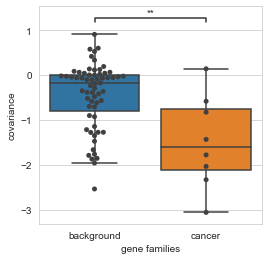

In [163]:
df = regressionCoeffDf2.copy()

fig, ax = plt.subplots(figsize=(4,4))

xlabel = 'is_cancer_family'
ylabel = 'covariance'
cancerTrueLabel = 'cancer'
cancerFalseLabel = 'background'
df[xlabel] = df[xlabel].replace({True:cancerTrueLabel, False:cancerFalseLabel})

sns.boxplot(ax=ax, data=df, x=xlabel, y=ylabel, showfliers=False)

sns.swarmplot(ax=ax, data=df, x=xlabel, y=ylabel, color='0.25')

ax.set_xlabel('gene families')

u_stat, pval = stats.mannwhitneyu(df[df[xlabel] == cancerTrueLabel][ylabel],
                                  df[df[xlabel] == cancerFalseLabel][ylabel], alternative='two-sided')
print(pval)
add_stat_annotation(ax, data=df,  x=xlabel, y=ylabel,
                    box_pairs=[[cancerTrueLabel, cancerFalseLabel]],
                    text_format='star', test='Mann-Whitney', loc='inside', verbose=1)

filename = re.sub(r'/', r'-', 'covariance_distribution_cancer_vs_background_{}.png'.format(mutCol))
print(filename)
plt.savefig(str(outputPath / 'gene family' / filename), dpi=300)
filename = re.sub(r'/', r'-', 'covariance_distribution_cancer_vs_background_{} pvalue.txt'.format(mutCol))
with (outputPath / 'gene family' / filename).open('w') as f:
    f.write(str(pval))

ncols 3


/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:572: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f737f4e38e0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  ax.legend(handles, labels, loc="best", title=title)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:572: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f737f49d280> has a label of '_nolegend_' which cannot be automatically added to the legend.
  ax.legend(handles, labels, loc="best", title=title)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:572: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f737f497c70> has a label of '_nolegend_' which cannot be automatically added to the legend.
  ax.legend(handles, labels, loc="best", title=title)
/home/mweber/.local/anaconda3/envs/kras/lib/pytho

family PC1 - mutation_count_norm_within_family individual families


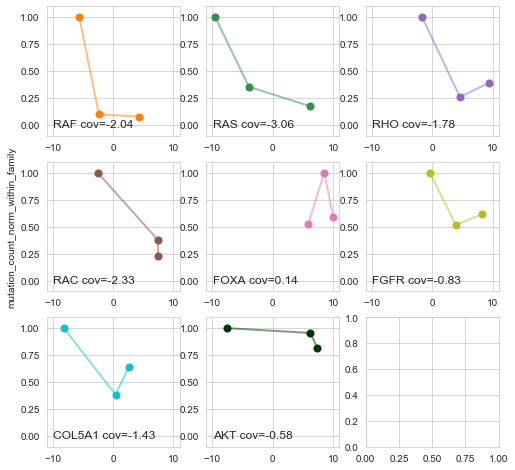

In [178]:
width = 5

xlabel2 = 'PC1'
singleRef = True
ylabel2 = mutCol

xmin = PC1min
xmax = PC1max

# Palette one color per family
catList = familyCAIPCADf[familyCAIPCADf['is_cancer_family']]['family'].unique()
# palette = dict(list(zip(catList, itertools.cycle(current_palette))))
palette = paletteFamily

addLineWithinFamily = True

plotDf0 = familyCAIPCADf.dropna(subset=[xlabel2, ylabel2]).copy()
plotDf0 = plotDf0[plotDf0['is_cancer_family']]


def single_plot(plotDf0, family, ax, **kwargs):
    plotDf = plotDf0[plotDf0['family'] == family]

    aspect = 1
    ax2 = ax

    color = palette[family]
    alpha = 1
    alphaLine = 0.5
    sns.regplot(ax=ax2, x=xlabel2, y=ylabel2, data=plotDf, fit_reg=False,
                color=color, scatter_kws={'s':50, 'alpha':alpha})
    if addLineWithinFamily:
        plotDf = plotDf.sort_values(xlabel2)
        plotDf.plot(ax=ax2, x=xlabel2, y=ylabel2, alpha=alphaLine, color=color, lw=2, label='_nolegend_')

    if mutCol == 'mutation_count_norm_within_family':
        ymin, ymax = -0.1, 1.1
        annotPos = (0.05, 0.05)

    cov = regressionCoeffDf2.loc[family]['covariance']
    ax2.annotate('{} cov={:.2f}'.format(family, cov), xy=annotPos, xycoords='axes fraction', ha='left', va='bottom', size=12)

#     lgd2 = ax2.legend(bbox_to_anchor=(1.05, 1), loc=2, ncol=2)
#     lgd2 = ax2.legend(loc='best', ncol=1)
#     for handle in lgd2.legendHandles:
#         handle._sizes = [30]
    ax2.get_legend().remove()

    ax2.set_xlim((xmin,xmax))
    ax2.set_ylim(ymin, ymax)
    ax2.set_xlabel(xlabel2)
    if xlabel2 == 'CAI_ratio':
        ax2.annotate('<-- ' + cat1, xy=(0, -0.15), xycoords='axes fraction', ha='left')
        ax2.annotate(cat2 + ' -->', xy=(1, -0.15), xycoords='axes fraction', ha='right')


nPlots = len(familyCancerList)
ncols = int(np.sqrt(nPlots + 1))
print("ncols", ncols)
# ncols = 3
nrows = nPlots // ncols + 1
w = 2.7
h = w
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*w, nrows*h))
for i, family in enumerate(familyCancerList):
    irow = i // ncols
    icol = i % ncols
    ax = axes[irow][icol]
    single_plot(plotDf0, family=family, ax=ax)
    if not (irow == nrows and icol == ncols // 2):
        ax.set_xlabel('')
    if not (icol == 0 and irow == nrows // 2):
        ax.set_ylabel('')

filename = re.sub(r'/', r'-', 'family {} - {} individual families'.format(xlabel2, mutCol))
print(filename)        
fig.savefig(outputPath / 'gene family' / (filename + '.png'), dpi=600, bbox_inches='tight')
fig.savefig(outputPath / 'gene family' / (filename + '.svg'))

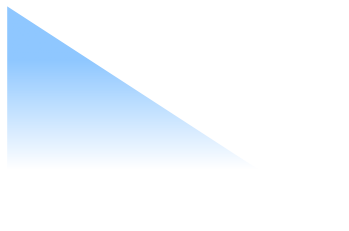

In [180]:
import matplotlib.patches as mpatches
from mwTools.plot import draw_color_gradient
start_color = mcolors.hex2color(mcolors.cnames["dodgerblue"])
end_color = mcolors.to_rgb('1')
fig, ax = plt.subplots()
path = mpatches.Path([[0,0],[0,1],[1,0],[0,0]])
draw_color_gradient(ax, start_color, end_color, path, direction='down', hide_axis=True, alpha=0.5)

63
8
63
axCovBbox Bbox(x0=0.125, y0=0.1250000000000001, x1=0.25862068965517243, y1=0.35150000000000003)
axCovBbox Bbox(x0=0.28534482758620694, y0=0.1250000000000001, x1=0.4189655172413793, y1=0.35150000000000003)
axCovBbox Bbox(x0=0.4456896551724138, y0=0.1250000000000001, x1=0.5793103448275863, y1=0.35150000000000003)
covariance_distribution_cancer_vs_background_mutation_count_norm_within_family


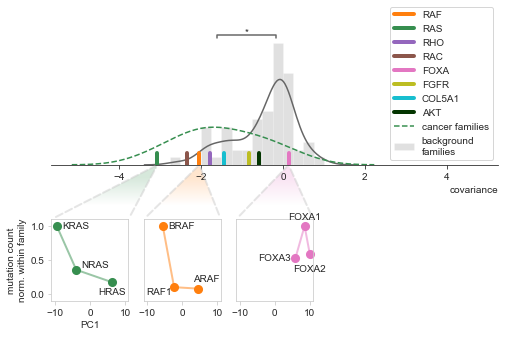

In [181]:
df = regressionCoeffDf2.copy()
cancerDf = df.loc[familyCancerList]

xlabel = 'is_cancer_family'
ylabel = 'covariance'
cancerTrueLabel = 'cancer'
cancerFalseLabel = 'background'

colorBackgroundFam = paletteDict['all']
colorBackgroundFam = '0.4'
colorAxes = sns.axes_style()['axes.edgecolor']

backgroundDf = df[df['is_cancer_family'] != True]
print(len(backgroundDf))

fig, ax = plt.subplots(figsize=(8,5))
# gs1 = GridSpec(3, 5, height_ratios=[0.6, 1, 0.6], hspace=0.5)
gs1 = GridSpec(2, 5, height_ratios=[1, 0.6], hspace=0.5)

### Distribution plot

# by default, kernel='gau', bw='scott',

with sns.axes_style('white', rc={'xtick.bottom': True, 'xtick.direction': 'out'}):
    ax = plt.subplot(gs1[0, :])
    axDist = ax
    sns.distplot(backgroundDf['covariance'], ax=ax, bins=np.arange(-5, 5, 0.25),
                 color=colorBackgroundFam, hist_kws=dict(alpha=0.2), label='background\nfamilies')
    sns.despine(ax=ax, left=True)
    ax.yaxis.set_visible(False)
    ax.grid(False)
    ax.set_xlabel('')
    ax.annotate('covariance', xy=(1, 0), xytext=(0, -20), xycoords='axes fraction',
                textcoords='offset points', ha='right', va='top')
    ax.tick_params(bottom=True, color=sns.axes_style()['axes.edgecolor'])
    
    
### statistical test

xlabel = 'is_cancer_family'
ylabel = 'covariance'
cancerTrueLabel = 'cancer'
cancerFalseLabel = 'background'
df = regressionCoeffDf2.copy()
df[xlabel] = df[xlabel].replace({True:cancerTrueLabel, False:cancerFalseLabel})
covarCancer = df[df[xlabel] == cancerTrueLabel][ylabel]
covarNotCancer = df[df[xlabel] == cancerFalseLabel][ylabel]
print(len(covarCancer))
print(len(covarNotCancer))
u_stat, pval = stats.mannwhitneyu(covarCancer, covarNotCancer, alternative='two-sided')
h = 0.025
y = 1.05
ax.plot([covarCancer.median(), covarCancer.median(), covarNotCancer.median(), covarNotCancer.median()],
        [y, y + h, y + h, y], c='0.4')
ax.annotate('*', xy=((covarCancer.median() + covarNotCancer.median()) / 2, y + h),
            xytext=(0, -1), textcoords='offset points', ha='center', va='bottom', fontsize='medium')
    
### Add a "tick" for each cancer family
ax = axDist
lw = 3
for fam, cov in cancerDf['covariance'].iteritems():
    ax.plot([cov, cov], [0, 0.1], lw=4, c=paletteFamily[fam], label=fam)
# ax.plot([], [], c=)

### Distribution of cancer families

sns.kdeplot(ax=ax, data=cancerDf['covariance'], color=paletteMut[2], ls='--', label='cancer families')

ax.legend()


### covariance plots

mutMin, mutMax = -0.1, 1.1
pc1Min, pc1Max = -11, 11
    
p = 5
labelGeneFamilyDict = {
    'HRAS':{'offset':(0, -p), 'ha':'center', 'va':'top'},
    'NRAS':{'offset':(p, 0), 'ha':'left', 'va':'bottom'},
    'KRAS':{'offset':(p, 0), 'ha':'left', 'va':'center'},
    'BRAF':{'offset':(p, 0), 'ha':'left', 'va':'center'},
    'RAF1':{'offset':(-0.5*p, 0), 'ha':'right', 'va':'top'},
    'ARAF':{'offset':(-p, p), 'ha':'left', 'va':'bottom'},
    'FGFR2':{'offset':(-p, 0), 'ha':'right', 'va':'top'},
    'FGFR1':{'offset':(-p, 0), 'ha':'right', 'va':'top'},
    'FGFR3':{'offset':(0, p), 'ha':'center', 'va':'bottom'},
    'FOXA1':{'offset':(0, p), 'ha':'center', 'va':'bottom'},
    'FOXA2':{'offset':(0, -2*p), 'ha':'center', 'va':'top'},
    'FOXA3':{'offset':(-p, 0), 'ha':'right', 'va':'center'},
}

def single_plot(plotDf0, family, ax, i, **kwargs):
    
    plotDf = plotDf0[plotDf0['family'] == family]
    aspect = 1
    color = paletteFamily[family]
    alpha = 1
    alphaLine = 0.5
    sns.regplot(ax=ax, x=xlabel2, y=ylabel2, data=plotDf, fit_reg=False,
                color=color, scatter_kws=dict(s=50, alpha=alpha, lw=2, clip_on=False))
    if addLineWithinFamily:
        plotDf = plotDf.sort_values(xlabel2)
        plotDf.plot(ax=ax, x=xlabel2, y=ylabel2, alpha=alphaLine, color=color, lw=2)
        
    # Add labels to each point
    for index, row in plotDf.iterrows():
        if row['gene'] in labelGeneFamilyDict.keys():
            offset = labelGeneFamilyDict[row['gene']]['offset']
            xy = (row[xlabel2], row[ylabel2])
            ha = labelGeneFamilyDict[row['gene']]['ha']
            va = labelGeneFamilyDict[row['gene']]['va']
        else:
            offset = (p, 0)
            xy = (row[xlabel2], row[ylabel2])
            ha = 'left'
            va = 'bottom'
        ax.annotate(row['gene'], xy=xy, xytext=offset, ha=ha, va=va, textcoords='offset points')

    annotPos = (0.05, 0.05)
    ax.get_legend().remove()
    ax.set_xlabel('PC1')
    ax.set_ylabel('mutation count\nnorm. within family')
    ax.tick_params(left=True, labelleft=True, bottom=True, labelbottom=True, color=colorAxes)
    if i > 0:
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.tick_params(left=False, labelleft=False)
    ax.grid(False)
    cov = regressionCoeffDf2.loc[family]['covariance']
#     ax.annotate('{} cov={:.2f}'.format(family, cov), xy=annotPos, xycoords='axes fraction', ha='left', va='bottom', size=12)
    ax.set_xlim(pc1Min, pc1Max)
    ax.set_ylim(mutMin, mutMax)

        
selectedFamilyList = ['RAS', 'RAF', 'FGFR', 'FOXA']
selectedFamilyList = ['RAS', 'RAF', 'FOXA']
        
cancerFamDf = famDf[famDf['is_cancer_family']]
axCovList = []
covList = []
for i, fam in enumerate(selectedFamilyList):
    cov = cancerDf.loc[fam, 'covariance']
    ax = plt.subplot(gs1[1, i])
    axCovList.append(ax)
    covList.append(cov)
    single_plot(cancerFamDf, fam, ax, i)

### Add zoom effect

# print(axDist.get_position())
for i, ax in enumerate(axCovList):
    cov = covList[i]
    axCovBbox = ax.get_position()
    print("axCovBbox", axCovBbox)
    axCovUpLeftPos = (axCovBbox.xmin, axCovBbox.ymax)
    axCovUpRightPos = (axCovBbox.xmax, axCovBbox.ymax)
    posTick = (axDist.transData + fig.transFigure.inverted()).transform((cov, 0))    
    x0 = (min(axCovUpLeftPos[0], posTick[0]), axCovUpLeftPos[1])
    x1 = (max(axCovUpRightPos[0], posTick[0]), posTick[1])
    width = x1[0] - x0[0]
    height = x1[1] - x0[1]
    
    # Add dashed lines
    lines = [mpatches.ConnectionPatch(xyA=xyA, xyB=(cov, 0), coordsA="axes fraction", coordsB="data",
                                     axesA=ax, axesB=axDist, arrowstyle='-', clip_on=False,
                                     shrinkA=5, shrinkB=3, ls='--', lw=2, ec=colorAxes, alpha=0.5)
             for xyA in [(0,1), (1,1)]]
    [line.set_zorder(-99) for line in lines]
    [ax.add_artist(line) for line in lines]

    # Add a polygon filled with color gradient
    ax = fig.add_axes([x0[0], x0[1], width, height])
    vertices = [axCovUpLeftPos, axCovUpRightPos, posTick]
    vertices = (fig.transFigure + ax.transData.inverted()).transform(vertices)
    path = mpatches.Path(vertices)
    start_color = paletteFamily[selectedFamilyList[i]]
    end_color = mcolors.to_rgb('white')
    draw_color_gradient(ax, start_color, end_color, path, direction='down', hide_axis=True, alpha=0.2)    
    ax.set_zorder(-99)

# def background_plot(plotDf0, ax, i):
    
#     plotDf = plotDf0
#     aspect = 1
#     alpha = 1
#     alphaLine = 0.5
#     for fam, plotDf2 in plotDf.groupby('family'):
#         plotDf2 = plotDf2.sort_values(xlabel2)
#         plotDf2.plot(ax=ax, x=xlabel2, y=ylabel2, alpha=alphaLine, color=colorBackgroundFam, lw=2)
# #         break

#     ax.get_legend().remove()
#     ax.set_xlabel('PC1')
#     ax.set_ylabel('mutation count\nnorm. within family')
#     ax.set_xlabel('')
#     ax.set_ylabel('')
#     ax.tick_params(left=True, labelleft=True, bottom=True, labelbottom=True, color=colorAxes)
#     ax.grid(False)
# #     cov = regressionCoeffDf2.loc[family]['covariance']
#     ax.set_xlim(pc1Min, pc1Max)
#     ax.set_ylim(mutMin, mutMax)
    

# backgroundFamDf = famDf[~famDf['is_cancer_family']]
# backgroundFamDfPos = backgroundFamDf[backgroundFamDf['covariance'] >= 0]
# backgroundFamDfNeg = backgroundFamDf[backgroundFamDf['covariance'] < 0]
# print("len(backgroundFamDfPos)", len(backgroundFamDfPos))
# print("len(backgroundFamDfNeg)", len(backgroundFamDfNeg))
# print("len(backgroundFamDfPos) families", len(backgroundFamDfPos['family'].unique()))
# print("len(backgroundFamDfNeg) families", len(backgroundFamDfNeg['family'].unique()))
# i = 1
# ax = plt.subplot(gs1[0, i])
# background_plot(backgroundFamDfNeg, ax, i=i)
# i = 3
# ax = plt.subplot(gs1[0, i])
# background_plot(backgroundFamDfPos, ax, i=i)

filename = re.sub(r'/', r'-', 'covariance_distribution_cancer_vs_background_{}'.format(mutCol))
print(filename)
plt.savefig(str(outputPath / 'gene family' / filename) + '.png', dpi=400)
plt.savefig(str(outputPath / 'gene family' / filename) + '.svg', dpi=400)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

background v.s. cancer: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.596e-03 U_stat=3.970e+02
covariance_boxplot_cancer_vs_background_mutation_count_norm_within_family


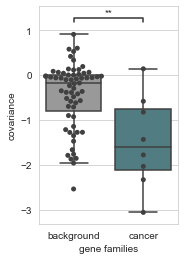

In [182]:
fig, ax = plt.subplots(figsize=(2.5, 4))
df = regressionCoeffDf2.copy()

xlabel = 'is_cancer_family'
ylabel = 'covariance'
cancerTrueLabel = 'cancer'
cancerFalseLabel = 'background'
df[xlabel] = df[xlabel].replace({True:cancerTrueLabel, False:cancerFalseLabel})

sns.boxplot(ax=ax, data=df, x=xlabel, y=ylabel, showfliers=False, palette=['0.6', '#49838aff'])
sns.swarmplot(ax=ax, data=df, x=xlabel, y=ylabel, color='0.25')
ax.set_xlabel('gene families')

u_stat, pval = stats.mannwhitneyu(df[df[xlabel] == cancerTrueLabel][ylabel],
                                  df[df[xlabel] == cancerFalseLabel][ylabel], alternative='two-sided')
add_stat_annotation(ax, data=df,  x=xlabel, y=ylabel,
                    box_pairs=[[cancerTrueLabel, cancerFalseLabel]],
                    text_format='star', test='Mann-Whitney', loc='inside', verbose=2)


filename = re.sub(r'/', r'-', 'covariance_boxplot_cancer_vs_background_{}'.format(mutCol))
print(filename)
plt.savefig(str(outputPath / 'gene family' / filename) + '.png', dpi=300)
plt.savefig(str(outputPath / 'gene family' / filename) + '.svg', dpi=300)

### KRAS (natural and optimized) used in Hannah's experiment

In [ ]:
hannahDf = pd.DataFrame([{'id':cds.id, 'CDS':str(cds.seq)} for cds in
                        SeqIO.parse((KRASPath / 'data' / 'cell_line_experiment_Hannah' /
                                     'RAS_protein_family_sequences_used_by_hannah.fasta').open(), "fasta")])
hannahDf = hannahDf.set_index('id')
hannahDf

In [170]:
queryDf = hannahDf
refSetList = [
    'pattern specification process',
    'mitotic M phase',
    'all']
refSetDfList = [(geneSetDf[geneSetDf['set'] == label], label) for label in refSetList]

df = compute_CAI_df(queryDf, refSetDfList)
hannahDf2 = hannahDf.join(df.drop('CDS', axis=1))
hannahDf2

The corrected synonymous family list is: ['I', 'L1', 'S1', 'L2', 'T', 'C', 'K', 'S2', 'V', 'H', 'Q', 'E', 'A', 'N', 'F', 'P', 'D', 'Y', 'R1', 'G', 'R2']
The corrected synonymous family list is: ['I', 'L1', 'S1', 'L2', 'T', 'C', 'K', 'S2', 'V', 'H', 'Q', 'E', 'A', 'N', 'F', 'P', 'D', 'Y', 'R1', 'G', 'R2']
The corrected synonymous family list is: ['I', 'L1', 'S1', 'L2', 'T', 'C', 'K', 'S2', 'V', 'H', 'Q', 'E', 'A', 'N', 'F', 'P', 'D', 'Y', 'R1', 'G', 'R2']
ERROR: following reference sequences have a length NOT multiple of 3: [16086]


,CDS,CAI pattern specification process,metric pattern specification process,CAI mitotic M phase,metric mitotic M phase,CAI all,metric all
query_index,,,,,,,
HRAS,ATGACGGAATATAAGCTGGTGGTGGTGGGCGCCGGCGGTGTGGGCA...,0.878880,2.938139,0.732518,4.594067,0.894685,3.095169
NRAS,ATGACTGAGTACAAACTGGTGGTGGTTGGAGCAGGTGGTGTTGGGA...,0.750902,2.877046,0.795429,2.709952,0.788494,2.806200
KRAS,ATGACTGAATATAAACTTGTGGTAGTTGGAGCTGGTGGCGTAGGCA...,0.692792,3.660128,0.857310,2.287297,0.746579,3.388925
KRASopt,ATGACGGAATATAAGCTTGTGGTGGTGGGCGCTGGAGGCGTGGGAA...,0.855911,2.654343,0.742880,3.935097,0.875730,2.763243


In [171]:
pc = compute_PC(hannahDf2['CDS'])
hannahDf3 = hannahDf2.join(pc)
hannahDf3

,CDS,CAI pattern specification process,metric pattern specification process,CAI mitotic M phase,metric mitotic M phase,CAI all,metric all,PC1,PC2
query_index,,,,,,,,,
HRAS,ATGACGGAATATAAGCTGGTGGTGGTGGGCGCCGGCGGTGTGGGCA...,0.878880,2.938139,0.732518,4.594067,0.894685,3.095169,6.473159,0.248842
NRAS,ATGACTGAGTACAAACTGGTGGTGGTTGGAGCAGGTGGTGTTGGGA...,0.750902,2.877046,0.795429,2.709952,0.788494,2.806200,-4.025296,0.446493
KRAS,ATGACTGAATATAAACTTGTGGTAGTTGGAGCTGGTGGCGTAGGCA...,0.692792,3.660128,0.857310,2.287297,0.746579,3.388925,-9.233497,0.534120
KRASopt,ATGACGGAATATAAGCTTGTGGTGGTGGGCGCTGGAGGCGTGGGAA...,0.855911,2.654343,0.742880,3.935097,0.875730,2.763243,4.763562,0.072671


In [172]:
hannahDf3.to_excel(str(KRASPath / 'results' / 'cell_line_experiment_Hannah' / 'cell_line_exp_KRAS_codon_usage.xlsx'))

# Silent mutations

In [196]:
silentDf = pd.read_csv(outputPath / 'gene family' / 'familyDf5_silent.csv', index_col=0).set_index('gene')
silentDf.head()

,dn/ds,dn/ds_Genie,family,is_cancer_family,mutation_count,mutation_count_Genie,sequence_identity_to_representative,similarity_cutoff,mutation_count_norm_within_family,dn/ds_norm_within_family,CCDS_id,CDS,uniprot_id,n_members,silent_mutation_count
gene,,,,,,,,,,,,,,,
PCDHA1,0.813784,NaN,PCDHA6,False,131.0,NaN,80.9474,79.373909,0.977612,0.244675,CCDS54912.1,ATGGTGTTTTCTAGGAGAGGGGGCCTGGGAGCCCGGGATCTGCTTC...,Q9Y5I3,12,77
PCDHA10,0.313736,NaN,PCDHA6,False,115.0,NaN,81.2236,79.373909,0.858209,0.094329,CCDS34255.1,ATGGTTTCCAGATGTAGCTGCCTGGGGGTCCAGTGTCTGCTGCTCT...,Q9Y5I2,12,57
PCDHA11,2.119512,NaN,PCDHA6,False,116.0,NaN,81.2434,79.373909,0.865672,0.637259,CCDS47284.1,ATGTTTGGTTTTCAGAGAAGGGGATTGGGCACCCCACGACTACAGC...,Q9Y5I1,12,71
PCDHA12,2.550970,NaN,PCDHA6,False,107.0,NaN,81.4028,79.373909,0.798507,0.766983,CCDS47285.1,ATGGTGATTATCGGACCAAGAGGCCCGGGATCCCAGCGTCTGCTGC...,Q9UN75,12,72
PCDHA13,0.478978,NaN,PCDHA6,False,100.0,NaN,80.5263,79.373909,0.746269,0.144011,CCDS4240.1,ATGCTGTCTTCCTGGCAAGGAGGCCCAAGACCGCGGCAACTACTGC...,Q9Y5I0,12,83


In [197]:
famDf = pd.read_csv(outputPath / 'gene family' / 'famDf.csv', index_col=0).set_index('gene')
famDf.head()

,dn/ds,dn/ds_Genie,family,is_cancer_family,mutation_count,mutation_count_Genie,sequence_identity_to_representative,similarity_cutoff,mutation_count_norm_within_family,dn/ds_norm_within_family,...,CDS,uniprot_id,n_members,PC1,PC2,PC3,PC4,regression_coeff,regression_MSE,covariance
gene,,,,,,,,,,,,,,,,,,,,,
NRAS,4.750884,0.788494,RAS,True,175.0,534.0,85.1852,74.741478,0.356415,0.184996,...,ATGACTGAGTACAAACTGGTGGTGGTTGGAGCAGGTGGTGTTGGGA...,P01111,3,-3.918689,0.437520,0.887135,3.090817,-16.296346,9.000525e+00,-3.062165
HRAS,5.635593,0.894685,RAS,True,86.0,177.0,100.0000,74.741478,0.175153,0.219445,...,ATGACGGAATATAAGCTGGTGGTGGTGGGCGCCGGCGGTGTGGGCA...,P01112,3,6.221500,0.216370,-2.894585,1.912780,-16.296346,9.000525e+00,-3.062165
KRAS,25.681069,0.733630,RAS,True,491.0,2774.0,84.6561,74.741478,1.000000,1.000000,...,ATGACTGAATATAAACTTGTGGTAGTTGGAGCTGGTGGCGTAGGCA...,P01116,3,-9.483024,0.336131,-0.582128,1.752785,-16.296346,9.000525e+00,-3.062165
PTPN6,0.649018,0.858458,PTPN,True,26.0,0.0,51.7628,49.644816,0.426230,0.600774,...,ATGCTGTCCCGTGGGTGGTTTCACCGAGACCTCAGTGGGCTGGATG...,P29350,2,5.567257,-0.614236,-1.674603,-0.197559,-17.599986,1.577722e-30,-2.897068
PTPN11,1.080303,0.771892,PTPN,True,61.0,176.0,100.0000,49.644816,1.000000,1.000000,...,ATGACATCGCGGAGATGGTTTCACCCAAATATCACTGGTGTGGAGG...,Q06124,2,-4.531095,0.477330,0.650594,-0.725335,-17.599986,1.577722e-30,-2.897068


In [198]:
famDf2 = famDf.join(silentDf['silent_mutation_count'])
famDf2.head()

,dn/ds,dn/ds_Genie,family,is_cancer_family,mutation_count,mutation_count_Genie,sequence_identity_to_representative,similarity_cutoff,mutation_count_norm_within_family,dn/ds_norm_within_family,...,uniprot_id,n_members,PC1,PC2,PC3,PC4,regression_coeff,regression_MSE,covariance,silent_mutation_count
gene,,,,,,,,,,,,,,,,,,,,,
NRAS,4.750884,0.788494,RAS,True,175.0,534.0,85.1852,74.741478,0.356415,0.184996,...,P01111,3,-3.918689,0.437520,0.887135,3.090817,-16.296346,9.000525e+00,-3.062165,4
HRAS,5.635593,0.894685,RAS,True,86.0,177.0,100.0000,74.741478,0.175153,0.219445,...,P01112,3,6.221500,0.216370,-2.894585,1.912780,-16.296346,9.000525e+00,-3.062165,4
KRAS,25.681069,0.733630,RAS,True,491.0,2774.0,84.6561,74.741478,1.000000,1.000000,...,P01116,3,-9.483024,0.336131,-0.582128,1.752785,-16.296346,9.000525e+00,-3.062165,7
PTPN6,0.649018,0.858458,PTPN,True,26.0,0.0,51.7628,49.644816,0.426230,0.600774,...,P29350,2,5.567257,-0.614236,-1.674603,-0.197559,-17.599986,1.577722e-30,-2.897068,21
PTPN11,1.080303,0.771892,PTPN,True,61.0,176.0,100.0000,49.644816,1.000000,1.000000,...,Q06124,2,-4.531095,0.477330,0.650594,-0.725335,-17.599986,1.577722e-30,-2.897068,20


In [199]:
dfList = []
for fam, group in famDf2.groupby('family'):
    df = group.copy()
    df['silent_mutation_count_norm_within_family'] = df['silent_mutation_count'] / group['silent_mutation_count'].max()
    dfList.append(df)
    
famDf2 = pd.concat(dfList)
famDf2.head()

,dn/ds,dn/ds_Genie,family,is_cancer_family,mutation_count,mutation_count_Genie,sequence_identity_to_representative,similarity_cutoff,mutation_count_norm_within_family,dn/ds_norm_within_family,...,n_members,PC1,PC2,PC3,PC4,regression_coeff,regression_MSE,covariance,silent_mutation_count,silent_mutation_count_norm_within_family
gene,,,,,,,,,,,,,,,,,,,,,
ACAP1,1.355703,NaN,ACAP2,False,52.0,NaN,52.8378,52.496882,1.000000,1.000000,...,3,2.680433,-1.203593,-1.357188,0.053761,-8.901587,32.736686,-0.365413,19,1.000000
ACAP2,1.306269,NaN,ACAP2,False,40.0,NaN,NaN,52.496882,0.769231,0.963536,...,3,-6.785611,0.462997,0.077277,0.815446,-8.901587,32.736686,-0.365413,16,0.842105
ACAP3,0.772458,NaN,ACAP2,False,31.0,NaN,57.0743,52.496882,0.596154,0.569784,...,3,7.427330,0.932669,-0.367447,0.766639,-8.901587,32.736686,-0.365413,19,1.000000
ACTN1,0.765308,NaN,ACTN4,False,48.0,NaN,83.9168,64.880258,0.424779,0.785437,...,3,5.609032,-1.163486,-0.883158,0.329770,-6.525489,1.130915,-0.698253,34,0.531250
ACTN2,0.974372,NaN,ACTN4,False,113.0,NaN,77.2931,64.880258,1.000000,1.000000,...,3,3.096375,-0.071123,-0.330841,0.467464,-6.525489,1.130915,-0.698253,64,1.000000


In [200]:
mutCol = 'silent_mutation_count_norm_within_family'
includeFamily2Members = False

PC1min = -11
PC1max = -PC1min

famDf = famDf2.copy()
xlabel, ylabel = (mutCol, 'PC1')

familyUnvalidMutValue = famDf[~(famDf[mutCol] > 0)]['family'].unique()
print(familyUnvalidMutValue)

print(len(famDf))
famDf = famDf[famDf['family'].map(lambda fam: fam not in familyUnvalidMutValue)]
print(len(famDf))

['U2AF1']
267
265


In [201]:
regressionCoeffList = []

for family, group in famDf.groupby('family'):
    # Covariance
    covar = group[[xlabel, ylabel]].cov().iloc[0, 1]

    regressionCoeffList.append(pd.Series({'family':family,
                                          'covariance':covar
                                         }))
regressionCoeffDf = pd.DataFrame(regressionCoeffList)
print("regressionCoeffDf.head()", regressionCoeffDf.head())

famDf = pd.merge(famDf, regressionCoeffDf, on='family', how='left', suffixes=['_missense', '_silent'])
famDf.head()

/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/pandas/core/frame.py:7605: RuntimeWarning: Degrees of freedom <= 0 for slice
  baseCov = np.cov(mat.T)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/mweber/.local/anaconda3/envs/kras/lib/python3.8/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


regressionCoeffDf.head()   family  covariance
0  ACAP2    0.623131
1  ACTN4   -0.606517
2    AKT    0.776406
3    ALK   -0.592197
4    ANK   -0.951270


,dn/ds,dn/ds_Genie,family,is_cancer_family,mutation_count,mutation_count_Genie,sequence_identity_to_representative,similarity_cutoff,mutation_count_norm_within_family,dn/ds_norm_within_family,...,PC1,PC2,PC3,PC4,regression_coeff,regression_MSE,covariance_missense,silent_mutation_count,silent_mutation_count_norm_within_family,covariance_silent
0,1.355703,NaN,ACAP2,False,52.0,NaN,52.8378,52.496882,1.000000,1.000000,...,2.680433,-1.203593,-1.357188,0.053761,-8.901587,32.736686,-0.365413,19,1.000000,0.623131
1,1.306269,NaN,ACAP2,False,40.0,NaN,NaN,52.496882,0.769231,0.963536,...,-6.785611,0.462997,0.077277,0.815446,-8.901587,32.736686,-0.365413,16,0.842105,0.623131
2,0.772458,NaN,ACAP2,False,31.0,NaN,57.0743,52.496882,0.596154,0.569784,...,7.427330,0.932669,-0.367447,0.766639,-8.901587,32.736686,-0.365413,19,1.000000,0.623131
3,0.765308,NaN,ACTN4,False,48.0,NaN,83.9168,64.880258,0.424779,0.785437,...,5.609032,-1.163486,-0.883158,0.329770,-6.525489,1.130915,-0.698253,34,0.531250,-0.606517
4,0.974372,NaN,ACTN4,False,113.0,NaN,77.2931,64.880258,1.000000,1.000000,...,3.096375,-0.071123,-0.330841,0.467464,-6.525489,1.130915,-0.698253,64,1.000000,-0.606517


In [202]:
famDf = famDf.sort_values(['covariance_silent', 'family'])

In [203]:
famDf.to_csv(outputPath / 'gene family' / 'famDf_silent.csv')

In [204]:
len(regressionCoeffDf)

86

Note that we include background non-cancer families with more than 3 members (there are with 10-12 members!).

In [205]:
familyCancerList = famDf[famDf['is_cancer_family']]['family'].unique()

familyCancerDf = famDf[famDf['is_cancer_family']]
familyCancerDf = familyCancerDf[familyCancerDf['n_members'] > 2]

familyCancerList = familyCancerDf['family'].unique()
print("len(familyCancerList)", len(familyCancerList))

familyNotCancerDf = famDf[~famDf['is_cancer_family']]
familyNotCancerDf = familyNotCancerDf[familyNotCancerDf['n_members'] > 2]

familyNotCancerList = familyNotCancerDf['family'].unique()
print("len(familyNotCancerList)", len(familyNotCancerList))
familyNotCancerList

regressionCoeffDf2 = regressionCoeffDf.set_index('family')
regressionCoeffDf2['is_cancer_family'] = np.nan
regressionCoeffDf2.loc[familyCancerList, 'is_cancer_family'] = True
regressionCoeffDf2.loc[familyNotCancerList, 'is_cancer_family'] = False
regressionCoeffDf2 = regressionCoeffDf2[~regressionCoeffDf2['is_cancer_family'].isnull()]
print("len(regressionCoeffDf2)", len(regressionCoeffDf2))

cancerCoeff = regressionCoeffDf2.loc[familyCancerList]['covariance']
notCancerCoeff = regressionCoeffDf2.loc[familyNotCancerList]['covariance']

regressionCoeffDf2.head()

len(familyCancerList) 8
len(familyNotCancerList) 63
len(regressionCoeffDf2) 71


,covariance,is_cancer_family
family,,
ACAP2,0.623131,False
ACTN4,-0.606517,False
AKT,0.776406,True
ASGR1,-0.762196,False
BMP1,-0.488811,False


In [206]:
mutCol

'silent_mutation_count_norm_within_family'

0.764139322938244
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

background v.s. cancer: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.641e-01 U_stat=2.350e+02
covariance_distribution_cancer_vs_background_silent_mutation_count_norm_within_family


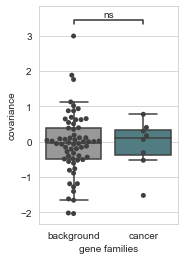

In [210]:
df = regressionCoeffDf2.copy()

fig, ax = plt.subplots(figsize=(2.5,4))

xlabel = 'is_cancer_family'
ylabel = 'covariance'
cancerTrueLabel = 'cancer'
cancerFalseLabel = 'background'
df[xlabel] = df[xlabel].replace({True:cancerTrueLabel, False:cancerFalseLabel})

sns.boxplot(ax=ax, data=df, x=xlabel, y=ylabel, showfliers=False, palette=['0.6', '#49838aff'])
sns.swarmplot(ax=ax, data=df, x=xlabel, y=ylabel, color='0.25')
ax.set_xlabel('gene families')
u_stat, pval = stats.mannwhitneyu(df[df[xlabel] == cancerTrueLabel][ylabel],
                                  df[df[xlabel] == cancerFalseLabel][ylabel], alternative='two-sided')
print(pval)
add_stat_annotation(ax, data=df, x=xlabel, y=ylabel,
                    box_pairs=[[cancerTrueLabel, cancerFalseLabel]],
                    text_format='star', test='Mann-Whitney', loc='inside', verbose=1)

filename = re.sub(r'/', r'-', 'covariance_distribution_cancer_vs_background_{}'.format(mutCol))
print(filename)
plt.savefig(outputPath / 'gene family' / (filename + '.png'), dpi=600, bbox_inches='tight')
plt.savefig(outputPath / 'gene family' / (filename + '.svg'))
filename = re.sub(r'/', r'-', 'covariance_distribution_cancer_vs_background_{} pvalue.txt'.format(mutCol))
with (outputPath / 'gene family' / filename).open('w') as f:
    f.write(str(pval))

----